In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import os
import sys
from datetime import datetime, timedelta
import itertools
import numpy as np
import json
import matplotlib.dates as mdates
from prophet import Prophet
currdir = os.path.abspath('')

temp_module = os.path.join(currdir,"./Workloads/",  "Temporal")
sys.path.append(temp_module)
import temporalWorkload
azure_module = os.path.join(currdir,"./Workloads/",  "Azure")
sys.path.append(azure_module)
import Azure_processing
lwa_module = os.path.join(currdir,"./temp/full_lwa/",  "lets-wait-awhile-master")
sys.path.append(lwa_module)
import simulate
alg_lwa_mod = os.path.join(currdir,"./Algorithms_Workload_Shifting/",  "Lets_Wait_Awhile")
sys.path.append(alg_lwa_mod)
import LWA_algorithm
work_mod = os.path.join(currdir,"./",  "Workloads")
sys.path.append(work_mod)
import country_users
gen_mod = os.path.join(currdir,"./Workloads/",  "GenerativeAI")
sys.path.append(gen_mod)
import genAI
carbon_min_em_module = os.path.join(currdir,"./Algorithms_Workload_Shifting/",  "Carbon_Min")
sys.path.append(carbon_min_em_module)
import carbon_min_algorithm

Importing plotly failed. Interactive plots will not work.


In [12]:
temp_workloadDF = pd.read_csv('./Workloads/Temporal/t_workload.csv', parse_dates=True, index_col='datetime')
temp_workloadDF.head()

jobs
datetime                    
2023-01-01 00:00:00  1146465
2023-01-01 01:00:00  1148655
2023-01-01 02:00:00  1134055
2023-01-01 03:00:00  1119820
2023-01-01 04:00:00  1125660

In [46]:
print(f'Total jobs on day one:{temp_workloadDF.head(24).sum()}')
print(f'Total jobs:{temp_workloadDF.sum()}')
print(f'Average jobs per hour:{temp_workloadDF.mean()}')
print(f'Standard Deviation:{temp_workloadDF.std()}')
print(f'Minimum Jobs:{temp_workloadDF.min()}')
print(f'Maximum Jobs:{temp_workloadDF.max()}')

Total jobs on day one:jobs    27123880
dtype: int64
Total jobs:jobs    9855000000
dtype: int64
Average jobs per hour:jobs    1125000.0
dtype: float64
Standard Deviation:jobs    20314.498422
dtype: float64
Minimum Jobs:jobs    1053025
dtype: int64
Maximum Jobs:jobs    1203405
dtype: int64


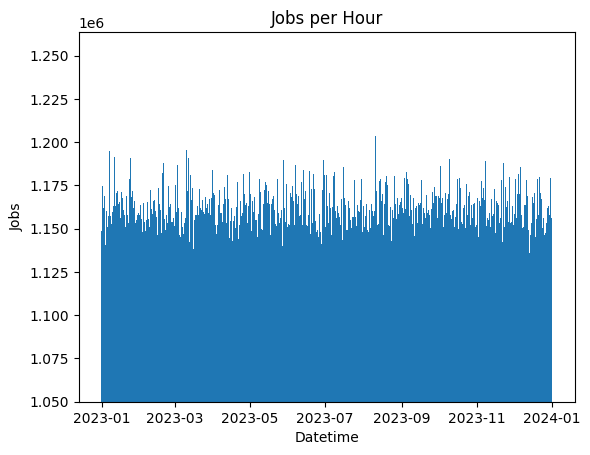

In [48]:
plt.bar(temp_workloadDF.index, temp_workloadDF['jobs'])
plt.title("Jobs per Hour")
plt.xlabel("Datetime")
plt.ylabel("Jobs")
plt.ylim(1050000, None)
plt.show()

In [3]:
azureinvoDF = pd.read_csv('./Workloads/Azure/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt')
azureinvoDF.head()

app   
0  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...  \
1  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
2  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
3  f274d71de386ccc77e4ca74766dbc485461c3053059d47...   
4  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...   

                                                func  end_timestamp  duration  
0  e3cdb48830f66eb8689cc0223514569a69812b77e6611e...       0.079491     0.078  
1  337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...      57.157860    57.154  
2  48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...      59.130478    59.125  
3  3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...       6.252541     6.236  
4  68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...       0.066824     0.050

In [25]:
azureinvoDF['start_timestamp'] = azureinvoDF['end_timestamp'] - azureinvoDF['duration']
azureinvoDF.head()

app   
0  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...  \
1  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
2  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
3  f274d71de386ccc77e4ca74766dbc485461c3053059d47...   
4  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...   

                                                func  end_timestamp  duration   
0  e3cdb48830f66eb8689cc0223514569a69812b77e6611e...       0.079491     0.078  \
1  337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...      57.157860    57.154   
2  48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...      59.130478    59.125   
3  3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...       6.252541     6.236   
4  68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...       0.066824     0.050   

   start_timestamp  start_hour  
0         0.001491           0  
1         0.003860           0  
2         0.005478           0  
3         0.016541           0  
4         0.016824           0

In [5]:
x = azureinvoDF['start_timestamp'] / 3600
azureinvoDF['start_hour'] = x.astype(int)
azureinvoDF

app   
0        7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...  \
1        1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
2        1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
3        f274d71de386ccc77e4ca74766dbc485461c3053059d47...   
4        7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...   
...                                                    ...   
1980946  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980947  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980948  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980949  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980950  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   

                                                      func  end_timestamp   
0        e3cdb48830f66eb8689cc0223514569a69812b77e6611e...   7.949090e-02  \
1        337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...   5.715786e+01   
2        48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...   5.913048e+01   
3        3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...   6.252541e+00   
4        68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...   6.682396e-02   
...                                                    ...            ...   
1980946  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209597e+06   
1980947  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209598e+06   
1980948  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209599e+06   
1980949  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209599e+06   
1980950  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209600e+06   

         duration  start_timestamp  start_hour  
0           0.078     1.490900e-03           0  
1          57.154     3.860041e-03           0  
2          59.125     5.477905e-03           0  
3           6.236     1.654107e-02           0  
4           0.050     1.682396e-02           0  
...           ...              ...         ...  
1980946     0.001     1.209597e+06         335  
1980947     0.001     1.209598e+06         335  
1980948     0.001     1.209599e+06         335  
1980949     0.001     1.209599e+06         335  
1980950     0.001     1.209600e+06         335  

[1980951 rows x 6 columns]

In [19]:
azureinvoDF[['app', 'start_hour']].groupby(['start_hour']).count()

app
start_hour      
0            620
1            905
2           9054
3           6566
4           4842
...          ...
331         4808
332         2498
333         3845
334         5039
335         3837

[336 rows x 1 columns]

In [20]:
requests_per_hour = azureinvoDF['start_hour'].value_counts().sort_index()
requests_per_hour

start_hour
0       620
1       905
2      9054
3      6566
4      4842
       ... 
331    4808
332    2498
333    3845
334    5039
335    3837
Name: count, Length: 336, dtype: int64

In [65]:
print(f'Total jobs:{requests_per_hour.sum()}')
print(f'Average jobs per hour:{requests_per_hour.mean()}')
print(f'Standard Deviation:{requests_per_hour.std()}')
print(f'Minimum Jobs:{requests_per_hour.min()}')
print(f'Maximum Jobs:{requests_per_hour.max()}')
print('Jobs per day:')
requests_per_day = requests_per_hour.groupby(requests_per_hour.index // 24).sum()
requests_per_day

Total jobs:1980951
Average jobs per hour:5895.6875
Standard Deviation:6179.2407421796925
Minimum Jobs:327
Maximum Jobs:46053
Jobs per day:


start_hour
0      80990
1     195825
2     276297
3     289782
4      91589
5      63393
6      46693
7      78845
8     208403
9     132990
10    153642
11    133158
12    135356
13     93988
Name: count, dtype: int64

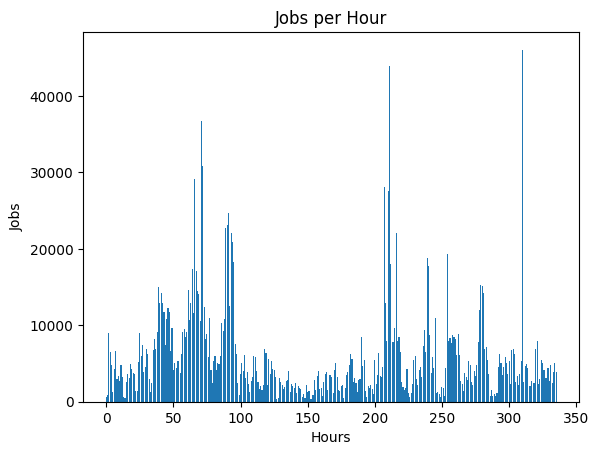

In [49]:
plt.bar(requests_per_hour.index, requests_per_hour)
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

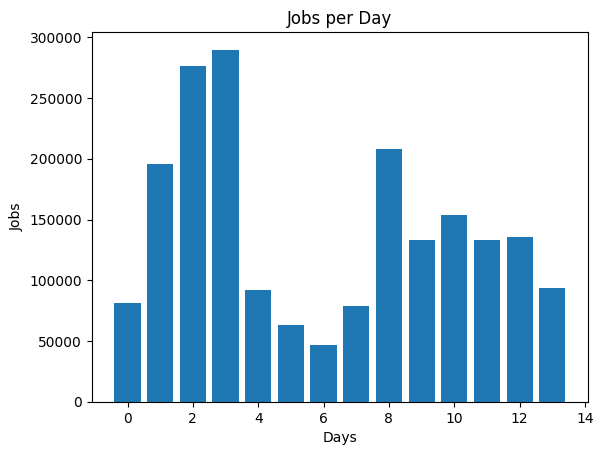

In [41]:
plt.bar(requests_per_day.index, requests_per_day)
plt.title("Jobs per Day")
plt.xlabel("Days")
plt.ylabel("Jobs")
plt.show()

In [2]:
azurevmDF = pd.read_csv('./Workloads/Azure/vmtable.csv', header=None, usecols=[3,4], names=['start_timestamp', 'end_timestamp']).sort_values('start_timestamp')
azurevmDF.head()

start_timestamp  end_timestamp
347144                 0         658200
2510470                0        2591400
830785                 0        2591400
1157491                0        2591400
159416                 0        2591400

In [3]:
x = azurevmDF['start_timestamp'] / 3600
azurevmDF['start_hour'] = x.astype(int)
y = azurevmDF['end_timestamp'] / 3600
azurevmDF['end_hour'] = y.astype(int)
azurevmDF

start_timestamp  end_timestamp  start_hour  end_hour
347144                 0         658200           0       182
2510470                0        2591400           0       719
830785                 0        2591400           0       719
1157491                0        2591400           0       719
159416                 0        2591400           0       719
...                  ...            ...         ...       ...
853709           2591400        2591400         719       719
273685           2591400        2591400         719       719
2503558          2591400        2591400         719       719
2405785          2591400        2591400         719       719
1762977          2591400        2591400         719       719

[2695548 rows x 4 columns]

In [62]:
vms_per_hour = azurevmDF['start_hour'].value_counts().sort_index()
vms_per_hour

start_hour
0      232071
1        3543
2        3596
3        3556
4        3824
        ...  
715      1990
716      1708
717      1923
718      3024
719      2240
Name: count, Length: 720, dtype: int64

In [4]:
end_vms_per_hour = azurevmDF['end_hour'].value_counts().sort_index()
end_vms_per_hour

end_hour
0        4179
1        4543
2        3789
3        3597
4        4348
        ...  
715      2115
716      1770
717      2335
718      2442
719    226686
Name: count, Length: 720, dtype: int64

In [64]:
print(f'Total jobs:{vms_per_hour.sum()}')
print(f'Average jobs per hour:{vms_per_hour.mean()}')
print(f'Standard Deviation:{vms_per_hour.std()}')
print(f'Minimum Jobs:{vms_per_hour.min()}')
print(f'Maximum Jobs:{vms_per_hour.max()}')
print('Jobs per day:')
vms_per_day = vms_per_hour.groupby(vms_per_hour.index // 24).sum()
vms_per_day

Total jobs:2695548
Average jobs per hour:3743.8166666666666
Standard Deviation:8558.291066089385
Minimum Jobs:1336
Maximum Jobs:232071
Jobs per day:


start_hour
0     317222
1      72332
2      65339
3      86746
4      94379
5      89341
6      84732
7      81804
8      72458
9      73290
10     93859
11     93235
12     90005
13     93477
14     88049
15     62655
16     72930
17     86765
18     80447
19     80888
20     94877
21     89079
22     57597
23     53389
24     93807
25     87796
26     97585
27     91418
28     91851
29     58196
Name: count, dtype: int64

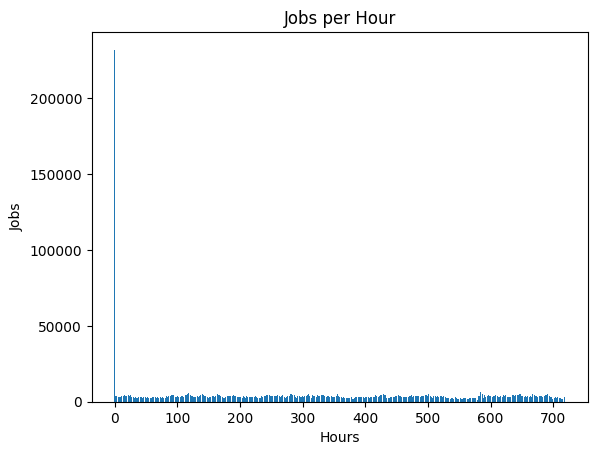

In [66]:
plt.bar(vms_per_hour.index, vms_per_hour)
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

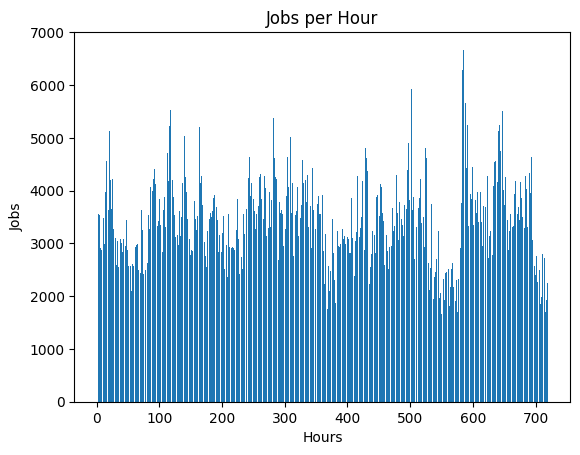

In [67]:
plt.bar(vms_per_hour.drop([0], axis=0).index, vms_per_hour.drop([0], axis=0))
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

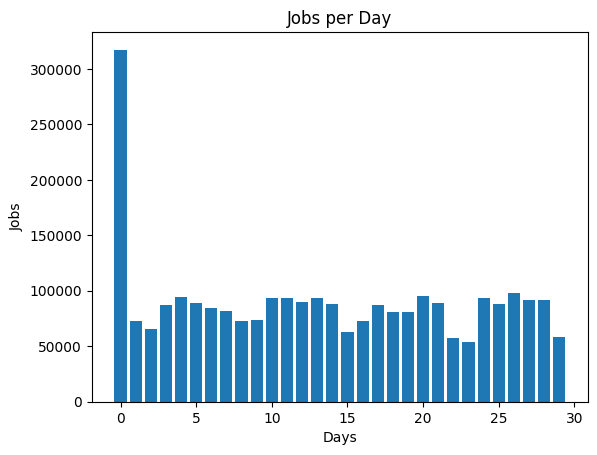

In [68]:
plt.bar(vms_per_day.index, vms_per_day)
plt.title("Jobs per Day")
plt.xlabel("Days")
plt.ylabel("Jobs")
plt.show()

In [5]:
data_df = Azure_processing.AzureFunctionsInvocationTraceForTwoWeeksJan2021()
data_df

start_hour  count
0             0    620
1             1    905
2             2   9054
3             3   6566
4             4   4842
..          ...    ...
331         331   4808
332         332   2498
333         333   3845
334         334   5039
335         335   3837

[336 rows x 2 columns]

In [8]:
time_idx = 'start_hour'
last_start_hour = data_df[time_idx].iloc[-1]
print(last_start_hour)
df_exogenous=pd.DataFrame({time_idx : range(last_start_hour + 1, last_start_hour + 100 + 1)})
df_exogenous

335


start_hour
0          336
1          337
2          338
3          339
4          340
..         ...
95         431
96         432
97         433
98         434
99         435

[100 rows x 1 columns]

In [4]:
import pmdarima as pm
model = pm.auto_arima(data_df['count'])
forecasts = model.predict(100)
forecasts

336    4393.580665
337    4763.996385
338    5133.663304
339    5286.569552
340    5347.818186
          ...     
431    6006.537266
432    6006.537266
433    6006.537266
434    6006.537266
435    6006.537267
Length: 100, dtype: float64

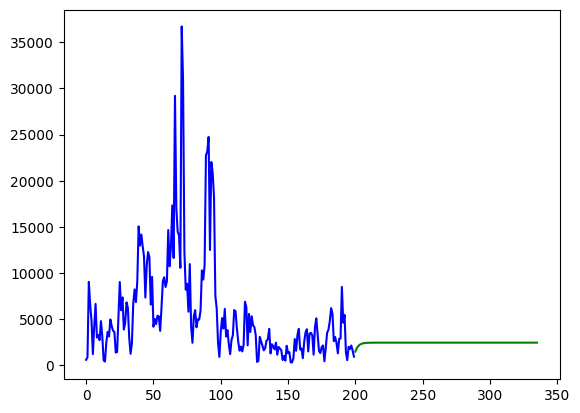

In [8]:
from pmdarima.model_selection import train_test_split
import numpy as np
train, test = train_test_split(data_df['count'], train_size=200)

# Fit your model
model = pm.auto_arima(train)

# make your forecasts
forecasts = model.predict(test.shape[0], seasonal=True, m=12)  # predict N steps into the future

# Visualize the forecasts (blue=train, green=forecasts)
x = np.arange(data_df['count'].shape[0])
plt.plot(x[:200], train, c='blue')
plt.plot(x[200:], forecasts, c='green')
plt.show()

In [9]:
forecasts

200    1504.066255
201    1853.843817
202    2077.480974
203    2220.467785
204    2311.889213
          ...     
331    2473.972317
332    2473.972317
333    2473.972317
334    2473.972317
335    2473.972317
Length: 136, dtype: float64

In [4]:
data_df = data_df.rename(columns={'start_hour': "ds", 'count': "y"})
data_df.head()

Importing plotly failed. Interactive plots will not work.


ds     y
0 2021-01-01 01:00:00   485
1 2021-01-01 02:00:00  5411
2 2021-01-01 03:00:00  3071
3 2021-01-01 04:00:00  3073
4 2021-01-01 05:00:00   644

In [2]:
data_df = Azure_processing.AzureFunctionsInvocationTraceForTwoWeeksJan2021()
#pdf.head()
data_df = data_df.rename(columns={'start_hour': "ds", 'count': "y"})
data_df['ds'] = pd.to_datetime(data_df.ds*3600, origin=pd.Timestamp('2021-01-01'), unit='s')
data_df.head()

ds     y
0 2021-01-01 01:00:00   485
1 2021-01-01 02:00:00  5411
2 2021-01-01 03:00:00  3071
3 2021-01-01 04:00:00  3073
4 2021-01-01 05:00:00   644

In [7]:
m = Prophet()
m.fit(data_df)
future = m.make_future_dataframe(periods=100, freq = 'H')
future.tail()

11:08:43 - cmdstanpy - INFO - Chain [1] start processing
11:08:43 - cmdstanpy - INFO - Chain [1] done processing


ds
385 2021-01-18 23:00:00
386 2021-01-19 00:00:00
387 2021-01-19 01:00:00
388 2021-01-19 02:00:00
389 2021-01-19 03:00:00

In [8]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds         yhat   yhat_lower    yhat_upper
385 2021-01-18 23:00:00  4109.311676 -1943.952114  10144.204787
386 2021-01-19 00:00:00  3966.759638 -1913.834944   9730.537655
387 2021-01-19 01:00:00  2769.826481 -3101.251774   8539.880157
388 2021-01-19 02:00:00  1089.331364 -4640.023758   7359.506214
389 2021-01-19 03:00:00  -111.731460 -6067.427869   5805.481689

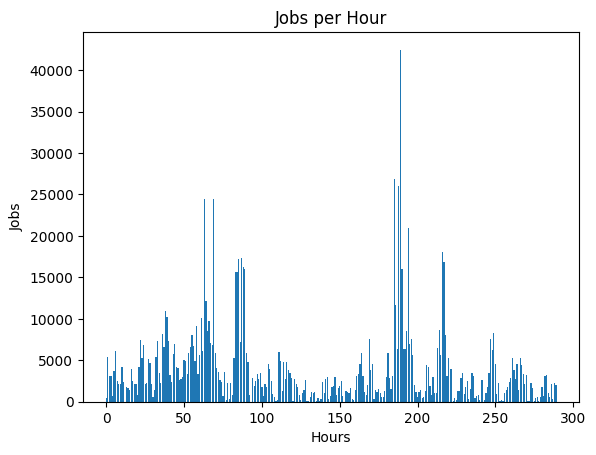

In [9]:
plt.bar(data_df.index, data_df['y'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

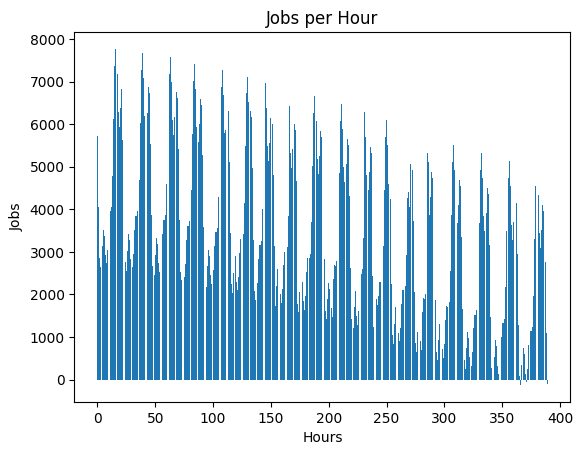

In [10]:
plt.bar(forecast['ds'].index, forecast['yhat'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

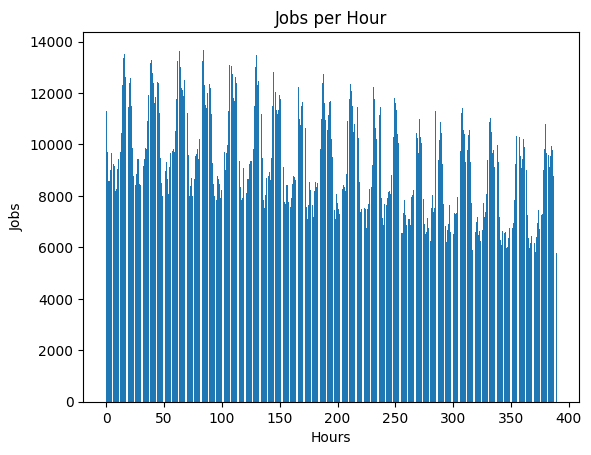

In [9]:
plt.bar(forecast['ds'].index, forecast['yhat_upper'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

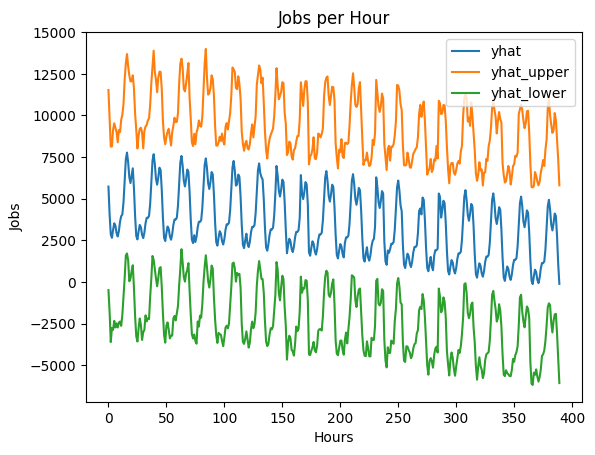

In [13]:
plt.plot(forecast['ds'].index, forecast['yhat'])
plt.plot(forecast['ds'].index, forecast['yhat_upper'])
plt.plot(forecast['ds'].index, forecast['yhat_lower'])
plt.title("Jobs per Hour")
plt.legend(["yhat", "yhat_upper", "yhat_lower"])
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

In [22]:
from prophet.diagnostics import cross_validation, performance_metrics
param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data_df)  # Fit model with given params
    df_cv = cross_validation(m, period = 100, horizon = 180, parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] done processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:12 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Chain [1] start processing
17:00:13 - cmdstanpy - INFO - Ch

    changepoint_prior_scale  seasonality_prior_scale         rmse
0                     0.001                     0.01  5237.079813
1                     0.001                     0.10  5257.362464
2                     0.001                     1.00  5246.500065
3                     0.001                    10.00  5268.825483
4                     0.010                     0.01  5230.367792
5                     0.010                     0.10  5162.820470
6                     0.010                     1.00  5156.544979
7                     0.010                    10.00  5190.122686
8                     0.100                     0.01  5064.880443
9                     0.100                     0.10  4977.214747
10                    0.100                     1.00  4988.531629
11                    0.100                    10.00  4988.055932
12                    0.500                     0.01  4971.265807
13                    0.500                     0.10  4880.522792
14        

In [23]:
best_params = all_params[np.argmin(rmses)]
print(best_params)

{'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1}


In [59]:
df = pd.DataFrame(y, columns=['jobs'])
df.insert(loc=0, column='start_hour', value=df.index)
df

start_hour  jobs
0             0   620
1             1   905
2             2  9054
3             3  6566
4             4  4842
..          ...   ...
431         431  6935
432         432  6758
433         433  5653
434         434  3968
435         435  2444

[436 rows x 2 columns]

In [3]:
azureDF = pd.read_csv('./Workloads/Azure/updated_Azure.csv')
azureDF.head()

start_hour  jobs
0           0   620
1           1   905
2           2  9054
3           3  6566
4           4  4842

In [4]:
azureDF['jobs'].sum()

3130884

In [7]:
data_df = Azure_processing.AzureFunctionsInvocationTraceForTwoWeeksJan2021()
data_df['count'].sum()

1980951

In [2]:
azure1 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d01.csv')
azure1.head()

HashOwner   
0  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...  \
1  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
2  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
3  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
4  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   

                                             HashApp   
0  7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...  \
1  0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
2  a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   
3  a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   
4  a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   

                                        HashFunction        Trigger  1  2  3   
0  520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http  0  0  0  \
1  115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...           http  0  0  0   
2  93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed8...  orchestration  0  0  0   
3  740c5c767e4b9978ee59a97d1829cfbaf755a47806a311...           http  0  0  0   
4  c108b4864b866b38b80d0e4594cc6d038f39668b804a1b...           http  0  0  0   

   4  5  6  ...  1431  1432  1433  1434  1435  1436  1437  1438  1439  1440  
0  1  0  0  ...     0     0     0     1     0     0     0     0     1     0  
1  1  0  0  ...     0     0     0     1     0     0     0     0     1     0  
2  0  0  0  ...     0     0     0     0     0     0     0     0     0     0  
3  0  0  0  ...     0     0     0     0     0     0     0     0     0     0  
4  0  0  0  ...     0     0     0     0     0     0     0     0     0     0  

[5 rows x 1444 columns]

In [41]:
sumdf = azure1.groupby('Trigger')[azure1.columns[4:]].sum()
sumdf

1       2       3       4       5       6       7       8   
Trigger                                                                         
event          187871  187136  199987  212153  192871  203870  265367  283245  \
http           145865  128788  122232  125495  119597  120081  118870  122904   
orchestration   17567   18379   13373   14480    2831    6906    3005    6903   
others            811     349     375     396     178     138     403      62   
queue          286091  252608  225264  224048  232926  242600  219149  239900   
storage          4116    3910    3760    3798    3702    4100    3254    3483   
timer           20271   10463   10998   10929   11278   13831   11436   10353   

                    9      10  ...    1432    1433    1434    1435    1436   
Trigger                        ...                                           
event          318702  290274  ...  171481  175403  172350  171931  167639  \
http           119817  117455  ...  125628  127632  131026  124365  127100   
orchestration    3130    4386  ...    3161    3264    4391    4377    8911   
others             95     420  ...     527     218     231     555     419   
queue          213566  216620  ...  232941  252638  241574  222852  231449   
storage          3471    3241  ...    5415    5779    5804    5302    5294   
timer           11191   11070  ...   10458   10866   10074   11231   13318   

                 1437    1438    1439    1440      total  
Trigger                                                   
event          166027  170662  169099  175227  598478236  
http           123585  126283  126797  122296  391988440  
orchestration    6135    3116    6699    9564   22107232  
others            394     549     190     262    1563876  
queue          226129  231475  222437  221698  757096602  
storage          5049    4747    5598    5305   15318198  
timer           10862   10505   10704   10320   33014174  

[7 rows x 1441 columns]

In [4]:
azure1['total'] = azure1[azure1.columns[4:]].sum(axis=1)
azure1 = azure1.sort_values(by=['total'])#.iloc[:,2:]
azure1.tail()

HashOwner   
43655  188aa0effba52f3801b7ae0331267195e144dc4304c0ab...  \
30897  ffdd3d1c6a84caf0b741293bfac9d0d9c6445b53dfc294...   
9363   c3d8abdce5a2d6cc74e33081a4105ffb31d36f5c224f0a...   
2521   104f438d72947b49216b97034e44c8f80e90b58c41c08a...   
26723  49d849c758f4ae2d7ce7b13ad4e65694268498be0e5f50...   

                                                 HashApp   
43655  dd3b9ba973ba588195ba8b00e2fd48d4f37a0a1a284072...  \
30897  228ef3c9f06cde19b4382e39c9339cc9b62b521ae71d70...   
9363   4b75f2532af503341fd11268d543ad0119dd2e8950a022...   
2521   734bb9a04a1d2e6917f75e46c093a6c95d114970e624b9...   
26723  94409f2485ebd997a61cbd06906595e4f3ef1846ed7406...   

                                            HashFunction Trigger      1   
43655  ea885ffca6338a2b781a0725ae8a661496779c7f0a7f78...   event  11852  \
30897  93d4c31373200d74272af6e0feb443ea1206b83034d563...   event  15579   
9363   dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13...   queue  26268   
2521   5315be05fc3b21a3f483ed0759bce825764dcf8a762623...    http  69730   
26723  8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0...   queue  82799   

           2      3      4      5      6  ...   1432   1433   1434   1435   
43655  11782  11926  11861  11945  11081  ...  13242  13407  13610  13257  \
30897  15083  15668  15555   8535  14062  ...  15379  14164  15324  15425   
9363   30359  33641  32432  29360  36349  ...  33107  40946  41688  34173   
2521   60387  59471  59244  54660  53888  ...  58143  59689  59515  53771   
26723  81725  81718  80786  77358  81200  ...  77776  81323  78373  77576   

        1436   1437   1438   1439   1440      total  
43655  13448  13335  13517  13660  13734   22457375  
30897  15088  14128  14151  14649  14678   24011909  
9363   35248  36094  35819  32939  34078   48947822  
2521   55339  55338  59811  58362  56510   83591132  
26723  81495  81682  78494  81162  80185  127471685  

[5 rows x 1445 columns]

In [5]:
azure2 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d02.csv')
azure2['total'] = azure2[azure2.columns[4:]].sum(axis=1)
#azure2 = azure2.iloc[:,2:].sort_values(by=['total'])
azure2.tail()

HashOwner   
46884  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...  \
46885  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
46886  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
46887  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
46888  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   

                                                 HashApp   
46884  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...  \
46885  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
46886  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
46887  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
46888  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   

                                            HashFunction Trigger  1  2  3  4   
46884  d01feeef6c6a03ba8cc96dbfdcb8898106b18acbe9d100...    http  0  0  0  0  \
46885  d43df62e0448cf994831aba36a262443378c03993bbb7b...    http  0  0  0  0   
46886  f1ff5a83374938d5da346b909ae4c6aaf6488f575116c9...    http  0  0  0  0   
46887  d6a50fa610274244b42a39dcb31f28a699dc289ce5e782...    http  0  0  0  0   
46888  3d8e7e07d617138e120d85a3d46013ff848fe5e34fcc4a...    http  0  0  0  0   

       5  6  ...  1432  1433  1434  1435  1436  1437  1438  1439  1440  total  
46884  0  0  ...     0     0     0     0     0     0     0     0     0      2  
46885  0  0  ...     0     0     0     0     0     0     0     0     0     18  
46886  0  0  ...     0     0     0     0     0     0     0     0     0      1  
46887  0  0  ...     0     0     0     0     0     0     0     0     0      9  
46888  0  0  ...     0     0     0     0     0     0     0     0     0      1  

[5 rows x 1445 columns]

In [6]:
azure3 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d03.csv')
azure3['total'] = azure3[azure3.columns[4:]].sum(axis=1)
#azure3 = azure3.iloc[:,2:].sort_values(by=['total'])

azure4 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d04.csv')
azure4['total'] = azure4[azure4.columns[4:]].sum(axis=1)
#azure4 = azure4.iloc[:,2:].sort_values(by=['total'])
azure4.tail()

HashOwner   
47522  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...  \
47523  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47524  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47525  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47526  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   

                                                 HashApp   
47522  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...  \
47523  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47524  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47525  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47526  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   

                                            HashFunction Trigger  1  2  3  4   
47522  2a3e87fbba15f0ebe581f93b1f43a3cb3b677ae209a880...    http  0  0  0  0  \
47523  d01feeef6c6a03ba8cc96dbfdcb8898106b18acbe9d100...    http  0  0  0  0   
47524  d43df62e0448cf994831aba36a262443378c03993bbb7b...    http  0  0  0  0   
47525  d6a50fa610274244b42a39dcb31f28a699dc289ce5e782...    http  0  0  0  0   
47526  3d8e7e07d617138e120d85a3d46013ff848fe5e34fcc4a...    http  0  0  0  0   

       5  6  ...  1432  1433  1434  1435  1436  1437  1438  1439  1440  total  
47522  0  0  ...     0     0     0     0     0     0     0     0     0      2  
47523  0  0  ...     0     0     0     0     0     0     0     0     0      2  
47524  0  0  ...     0     0     0     0     0     0     0     0     0     19  
47525  0  0  ...     0     0     0     0     0     0     0     0     0      9  
47526  0  0  ...     0     0     0     0     0     0     0     0     0      1  

[5 rows x 1445 columns]

In [7]:
azure5 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d05.csv')
azure5['total'] = azure5[azure5.columns[4:]].sum(axis=1)
#azure5 = azure5.iloc[:,2:].sort_values(by=['total'])

azure6 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d06.csv')
azure6['total'] = azure6[azure6.columns[4:]].sum(axis=1)
#azure6 = azure6.iloc[:,2:].sort_values(by=['total'])

azure7 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d07.csv')
azure7['total'] = azure7[azure7.columns[4:]].sum(axis=1)
#azure7 = azure7.iloc[:,2:].sort_values(by=['total'])
azure7.head()

HashOwner   
0  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...  \
1  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
2  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
3  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
4  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   

                                             HashApp   
0  7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...  \
1  0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
2  a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   
3  a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   
4  a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   

                                        HashFunction        Trigger  1  2  3   
0  520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http  0  1  0  \
1  115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...           http  0  0  1   
2  93e6c664773bbec3a7f50a0e92fa7e97401a802dc6eed8...  orchestration  0  0  0   
3  740c5c767e4b9978ee59a97d1829cfbaf755a47806a311...           http  0  0  0   
4  c108b4864b866b38b80d0e4594cc6d038f39668b804a1b...           http  0  0  0   

   4  5  6  ...  1432  1433  1434  1435  1436  1437  1438  1439  1440  total  
0  0  0  0  ...     1     0     0     0     0     1     0     0     0    288  
1  0  0  0  ...     0     1     0     0     0     0     1     0     0    287  
2  0  0  0  ...     0     0     0     0     0     0     0     0     0      2  
3  0  0  0  ...     0     0     0     0     0     0     0     0     0      3  
4  0  0  0  ...     0     0     0     0     0     0     0     0     0      3  

[5 rows x 1445 columns]

In [8]:
azure8 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d08.csv')
azure8['total'] = azure8[azure8.columns[4:]].sum(axis=1)
#azure8 = azure8.iloc[:,2:].sort_values(by=['total'])

azure9 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d09.csv')
azure9['total'] = azure9[azure9.columns[4:]].sum(axis=1)
#azure9 = azure9.iloc[:,2:].sort_values(by=['total'])

azure10 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d10.csv')
azure10['total'] = azure10[azure10.columns[4:]].sum(axis=1)

azure10.head()

HashOwner   
0  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...  \
1  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
2  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
3  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
4  71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   

                                             HashApp   
0  7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...  \
1  0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
2  0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
3  0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
4  0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   

                                        HashFunction        Trigger  1  2  3   
0  520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http  0  1  0  \
1  3d207511e68deaeadc1decbd716f30a5d2e8189283180d...  orchestration  0  0  0   
2  f7ffc0363310b370a4401e70de1767e5a5f8156c6020f2...           http  0  0  0   
3  cefbf0291486af03720a69ef91644c48fcf4317c1ebb58...           http  0  0  0   
4  ea9c50b4fb29a0568e5487882d3afea75abd8fab4cff4e...  orchestration  0  0  0   

   4  5  6  ...  1432  1433  1434  1435  1436  1437  1438  1439  1440  total  
0  0  0  0  ...     0     0     1     0     0     0     0     1     0    289  
1  0  0  0  ...     0     0     0     0     0     0     0     0     0    101  
2  0  0  0  ...     0     0     0     0     0     0     0     0     0     22  
3  0  0  0  ...     0     0     0     0     0     0     0     0     0     30  
4  0  0  0  ...     0     0     0     0     0     0     0     0     0     47  

[5 rows x 1445 columns]

In [12]:
azure11 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d11.csv')
azure11['total'] = azure11[azure11.columns[4:]].sum(axis=1)

azure12 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d12.csv')
azure12['total'] = azure12[azure12.columns[4:]].sum(axis=1)

azure12

HashOwner   
0      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...  \
1      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
2      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
3      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
4      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
...                                                  ...   
47183  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47184  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47185  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47186  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
47187  8addbe28939f12306f1100dfe5d0cbb3ca139a7fbe1212...   

                                                 HashApp   
0      7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...  \
1      0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
2      0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
3      0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
4      0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
...                                                  ...   
47183  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47184  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47185  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47186  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
47187  d5cdf68011c6d30357474929415bb9002a06ab71ecacc1...   

                                            HashFunction        Trigger  1  2   
0      520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http  0  0  \
1      3d207511e68deaeadc1decbd716f30a5d2e8189283180d...  orchestration  0  0   
2      f7ffc0363310b370a4401e70de1767e5a5f8156c6020f2...           http  0  0   
3      ea9c50b4fb29a0568e5487882d3afea75abd8fab4cff4e...  orchestration  0  0   
4      81048e5c14cd1afae7a9e492b3c643c5ad3e34c2354c27...          queue  0  0   
...                                                  ...            ... .. ..   
47183  d01feeef6c6a03ba8cc96dbfdcb8898106b18acbe9d100...           http  0  0   
47184  d43df62e0448cf994831aba36a262443378c03993bbb7b...           http  0  0   
47185  d6a50fa610274244b42a39dcb31f28a699dc289ce5e782...           http  0  0   
47186  3d8e7e07d617138e120d85a3d46013ff848fe5e34fcc4a...           http  0  0   
47187  cd9a0e3991d5e69f9f444667409fb0e4a8eae8922dbe7a...           http  0  0   

       3  4  5  6  ...  1432  1433  1434  1435  1436  1437  1438  1439  1440   
0      0  1  0  0  ...     0     0     1     0     0     0     0     1     0  \
1      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
2      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
3      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
4      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
...   .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
47183  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
47184  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
47185  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
47186  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
47187  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   

       total  
0        288  
1         25  
2          5  
3         15  
4         59  
...      ...  
47183      2  
47184     18  
47185      9  
47186      1  
47187      7  

[47188 rows x 1445 columns]

In [13]:
azure13 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d13.csv')
azure13['total'] = azure13[azure13.columns[4:]].sum(axis=1)

azure14 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d14.csv')
azure14['total'] = azure14[azure14.columns[4:]].sum(axis=1)

azure14

HashOwner   
0      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...  \
1      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
2      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
3      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
4      71ca12c7af70d021e285b51b245942f8432df6463ff9f2...   
...                                                  ...   
36483  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
36484  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
36485  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
36486  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   
36487  a56e06eb4762a967bd780967c94c2acf157c9a35fe87c7...   

                                                 HashApp   
0      7ca324d9fc836a5d4562811c11ce3719530ee919dd1fb9...  \
1      0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
2      0d0ac65651f54ae3285a59564d64e39238b516fa1d5b56...   
3      a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   
4      a04487a6ba1e14296eb7647e4963180d28bef7a90a8fc5...   
...                                                  ...   
36483  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
36484  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
36485  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
36486  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   
36487  15db3217b0ebb663a95357ff57320a536d0b1221f6fb2e...   

                                            HashFunction        Trigger  1  2   
0      520dbd6bd906840012aa0c4b778743efc7c0ac7b7caf96...           http  0  0  \
1      3d207511e68deaeadc1decbd716f30a5d2e8189283180d...  orchestration  0  0   
2      115ca7a2b5bc290052c3da74cd0347d19c3c67b7d5aa66...           http  0  0   
3      bbac184f470fa0013f5bbb9c68d83e15043f9fa71d8edc...           http  0  0   
4      e8b9a8fa010c02c8708a7d0601c2be68ea4aa4f01c1052...           http  0  0   
...                                                  ...            ... .. ..   
36483  2db4f426c825ee67b3a00aad77719a59cb6a01cf74c78c...           http  0  0   
36484  2a3e87fbba15f0ebe581f93b1f43a3cb3b677ae209a880...           http  0  0   
36485  d01feeef6c6a03ba8cc96dbfdcb8898106b18acbe9d100...           http  0  0   
36486  d43df62e0448cf994831aba36a262443378c03993bbb7b...           http  0  0   
36487  d6a50fa610274244b42a39dcb31f28a699dc289ce5e782...           http  0  0   

       3  4  5  6  ...  1432  1433  1434  1435  1436  1437  1438  1439  1440   
0      0  0  1  0  ...     0     0     0     1     0     0     0     0     1  \
1      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
2      0  1  0  0  ...     0     0     1     0     0     0     0     1     0   
3      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
4      0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
...   .. .. .. ..  ...   ...   ...   ...   ...   ...   ...   ...   ...   ...   
36483  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
36484  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
36485  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
36486  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   
36487  0  0  0  0  ...     0     0     0     0     0     0     0     0     0   

       total  
0        288  
1          2  
2        288  
3          4  
4          2  
...      ...  
36483      8  
36484      2  
36485      2  
36486     16  
36487      8  

[36488 rows x 1445 columns]

In [20]:
frames = [azure1[['HashFunction', 'total']], azure2[['HashFunction', 'total']], azure3[['HashFunction', 'total']], azure4[['HashFunction', 'total']], azure5[['HashFunction', 'total']], azure6[['HashFunction', 'total']], azure7[['HashFunction', 'total']], azure8[['HashFunction', 'total']], azure9[['HashFunction', 'total']], azure10[['HashFunction', 'total']], azure11[['HashFunction', 'total']], azure12[['HashFunction', 'total']], azure13[['HashFunction', 'total']], azure14[['HashFunction', 'total']]]
result = pd.concat(frames)
sumdf = result.groupby('HashFunction').sum()
sumdf = sumdf.sort_values(by=['total'])
sumdf.tail()

total
HashFunction                                                  
063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd7948...   307327546
93d4c31373200d74272af6e0feb443ea1206b83034d563a...   336710817
dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d...   900734217
5315be05fc3b21a3f483ed0759bce825764dcf8a762623a...  1187337050
8203ff88388384a6f9ed28664e8e9484119ff340cb7dc08...  1683728143

In [25]:
day = 11
top_funcs = ['063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794860338638212d30dfb',
     '93d4c31373200d74272af6e0feb443ea1206b83034d563ad7bc934e89b12e170',
     'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c',
     '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc',
     '8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e']
    
fileString = './Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d' + str(day).zfill(2) + '.csv'
azuredf = pd.read_csv(fileString)

selected_func_df = azuredf.loc[azuredf['HashFunction'].isin(top_funcs)][azuredf.columns[4:]].sum()#.drop(columns=['Trigger'])
selected_func_df

1       213602
2       201123
3       191328
4       189956
5       198414
         ...  
1436    179961
1437    179903
1438    183165
1439    181664
1440    184296
Length: 1440, dtype: int64

In [30]:
sel_hourly = selected_func_df.groupby((selected_func_df.index.astype(int) - 1) // 60).sum()
sel_hourly
#selected_func_df.index

0     12134939
1     12083629
2     12475499
3     12503935
4     12585197
5     12755762
6     12536937
7     12660490
8     12461407
9     12613055
10    12864865
11    13051578
12    13099495
13    13255115
14    12756820
15    12965416
16    12909363
17    13058425
18    13000822
19    12905083
20    12570326
21    10520270
22    10996230
23    10944998
dtype: int64

In [31]:
print(selected_func_df.sum())
print(sel_hourly.sum())

299709656
299709656


In [32]:
sel_hourly.index

Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23],
      dtype='int64')

In [36]:
dateString = '2023-01-'
dayString = dateString + str(2).zfill(2)
date_object = datetime.strptime(dayString, '%Y-%m-%d')
date_object

datetime.datetime(2023, 1, 2, 0, 0)

In [37]:
b = date_object + timedelta(hours=3)
b

datetime.datetime(2023, 1, 2, 3, 0)

In [6]:
azure1 = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d01.csv')
top_funcs = ['063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794860338638212d30dfb',
     '93d4c31373200d74272af6e0feb443ea1206b83034d563ad7bc934e89b12e170',
     'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c',
     '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc',
     '8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e']
sel_func_series = azure1.loc[azure1['HashFunction'].isin(top_funcs)][azure1.columns[4:]].sum()
sel_func_series

1       208726
2       201568
3       205160
4       202605
5       177924
         ...  
1436    201080
1437    200365
1438    201422
1439    200854
1440    199067
Length: 1440, dtype: int64

In [12]:
dateString = '2019-01-01'
date_object = datetime.strptime(dateString, '%Y-%m-%d').date()
datetime_object = datetime(date_object.year, date_object.month, date_object.day)
outputList = []
for index, value in sel_func_series.items():
    datetime_ind = datetime_object + timedelta(minutes=int(index)-1)
    datetime_string = datetime.strftime(datetime_ind, '%Y-%m-%d %H:%M:%S')
    outputList.append([datetime_string for _ in range(value)])
for x in outputList:
    print(x)

IOPub data rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_data_rate_limit`.

Current values:
ServerApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [2]:
azureinvoDF = pd.read_csv('./Workloads/Azure/AzureFunctionsInvocationTraceForTwoWeeksJan2021.txt')
azureinvoDF.head()

app   
0  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...  \
1  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
2  1573b95c039e51cc012b543a4af3bc7c3ee9485acbb003...   
3  f274d71de386ccc77e4ca74766dbc485461c3053059d47...   
4  7b2c43a2bc30f6bb438074df88b603d2cb982d3e7961de...   

                                                func  end_timestamp  duration  
0  e3cdb48830f66eb8689cc0223514569a69812b77e6611e...       0.079491     0.078  
1  337cd24a7d5fd5c92460faee4ebe6a186a0eb322bd17b7...      57.157860    57.154  
2  48cc770d590d3c5a7691b3b4e9302f82ec3be5ddc2a037...      59.130478    59.125  
3  3d2aee54a133509f16fb636d74128c2adcfcac71c6dcef...       6.252541     6.236  
4  68bbfd828223a505d7917339f4656c5f33ff93225cdb9d...       0.066824     0.050

In [7]:
func_count = azureinvoDF.groupby('func')['func'].count().sort_values()
func_count.tail()

func
bd5be891d0d10fbc3c59215d5f8159ea496433bc41adba7d8d10ea21d35c3e3a    116130
4753d9ffc8a362eadfb27498581969561c0ddbec7257759dbcb9936e506aff82    124143
cc5bb2108cc7daf53f9728ad21f661a8ef9c8b36284bacfcb712e2be87eef842    142856
8ef9c2c907e9cd5fb4b5cb3bfbebca6d9a01bb1f65a0f476e3914cae25bd2aae    212755
155e47f8e7f751d0c845049456d01832013c61336a8cd85901330ac821a71534    535667
Name: func, dtype: int64

In [9]:
toptwoweeks = [
    'bd5be891d0d10fbc3c59215d5f8159ea496433bc41adba7d8d10ea21d35c3e3a',
    '4753d9ffc8a362eadfb27498581969561c0ddbec7257759dbcb9936e506aff82',
    'cc5bb2108cc7daf53f9728ad21f661a8ef9c8b36284bacfcb712e2be87eef842',
    '8ef9c2c907e9cd5fb4b5cb3bfbebca6d9a01bb1f65a0f476e3914cae25bd2aae',
    '155e47f8e7f751d0c845049456d01832013c61336a8cd85901330ac821a71534'
]
selected_func_df = azureinvoDF.loc[azureinvoDF['func'].isin(toptwoweeks)]
#selected_func_df = azuredf.loc[azuredf['HashFunction'].isin(top_funcs)][azuredf.columns[4:]].sum()#.drop(columns=['Trigger'])
selected_func_df

app   
956      a594f92f84072b4cd031fe5283d1781a6e98f430696dec...  \
957      a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
958      a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
959      a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
960      a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
...                                                    ...   
1980946  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980947  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980948  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980949  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   
1980950  a594f92f84072b4cd031fe5283d1781a6e98f430696dec...   

                                                      func  end_timestamp   
956      155e47f8e7f751d0c845049456d01832013c61336a8cd8...   6.429979e+03  \
957      155e47f8e7f751d0c845049456d01832013c61336a8cd8...   6.430787e+03   
958      155e47f8e7f751d0c845049456d01832013c61336a8cd8...   6.430968e+03   
959      155e47f8e7f751d0c845049456d01832013c61336a8cd8...   6.432314e+03   
960      155e47f8e7f751d0c845049456d01832013c61336a8cd8...   6.432591e+03   
...                                                    ...            ...   
1980946  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209597e+06   
1980947  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209598e+06   
1980948  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209599e+06   
1980949  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209599e+06   
1980950  155e47f8e7f751d0c845049456d01832013c61336a8cd8...   1.209600e+06   

         duration  
956         0.611  
957         0.171  
958         0.007  
959         0.006  
960         0.001  
...           ...  
1980946     0.001  
1980947     0.001  
1980948     0.001  
1980949     0.001  
1980950     0.001  

[1131551 rows x 4 columns]

In [2]:
x = Azure_processing.AzureFunctions2019_total_workload()
x

2023-01-01 00:00:00
2023-01-01 01:00:00
2023-01-01 02:00:00
2023-01-01 03:00:00
2023-01-01 04:00:00
2023-01-01 05:00:00
2023-01-01 06:00:00
2023-01-01 07:00:00
2023-01-01 08:00:00
2023-01-01 09:00:00
2023-01-01 10:00:00
2023-01-01 11:00:00
2023-01-01 12:00:00
2023-01-01 13:00:00
2023-01-01 14:00:00
2023-01-01 15:00:00
2023-01-01 16:00:00
2023-01-01 17:00:00
2023-01-01 18:00:00
2023-01-01 19:00:00
2023-01-01 20:00:00
2023-01-01 21:00:00
2023-01-01 22:00:00
2023-01-01 23:00:00
2023-01-02 00:00:00
2023-01-02 01:00:00
2023-01-02 02:00:00
2023-01-02 03:00:00
2023-01-02 04:00:00
2023-01-02 05:00:00
2023-01-02 06:00:00
2023-01-02 07:00:00
2023-01-02 08:00:00
2023-01-02 09:00:00
2023-01-02 10:00:00
2023-01-02 11:00:00
2023-01-02 12:00:00
2023-01-02 13:00:00
2023-01-02 14:00:00
2023-01-02 15:00:00
2023-01-02 16:00:00
2023-01-02 17:00:00
2023-01-02 18:00:00
2023-01-02 19:00:00
2023-01-02 20:00:00
2023-01-02 21:00:00
2023-01-02 22:00:00
2023-01-02 23:00:00
2023-01-03 00:00:00
2023-01-03 01:00:00


In [18]:
x = './Data/WattTime/SGP_2022-01-01-2022-01-31.json'
y = './Data/WattTime/WattTimeAccess.json'
data = json.load(open(x))

df = pd.DataFrame(data["data"])
FRHourDF = df.iloc[::12]
#FRHourDF.value = FRHourDF.value.multiply(453.592/1000)
FRHourDF.loc[:, 'value'] *=(453.592/1000)
FRHourDF.reset_index(inplace=True)
FRHourDF = FRHourDF.drop(columns="index")
FRHourDF

point_time       value
0    2022-01-01T00:00:00+00:00  408.232800
1    2022-01-01T01:00:00+00:00  402.336104
2    2022-01-01T02:00:00+00:00  402.336104
3    2022-01-01T03:00:00+00:00  402.336104
4    2022-01-01T04:00:00+00:00  402.336104
..                         ...         ...
739  2022-01-31T19:00:00+00:00  400.521736
740  2022-01-31T20:00:00+00:00  390.996304
741  2022-01-31T21:00:00+00:00  400.521736
742  2022-01-31T22:00:00+00:00  404.604064
743  2022-01-31T23:00:00+00:00  405.057656

[744 rows x 2 columns]

In [34]:
s = FRHourDF['point_time'].iloc[0].replace('00+00:', '').replace(' ', '')
dt = datetime.fromisoformat(s)
dt

datetime.datetime(2022, 1, 1, 0, 0)

In [35]:
temp = pd.to_datetime(FRHourDF['point_time'].str.replace('00+00:', '').str.replace(' ', ''))
FRHourDF.insert(loc=0, column='datetime', value=temp)
FRHourDF = FRHourDF.drop(columns="point_time")
FRHourDF

datetime  value
0   2022-01-01 00:00:00  786.0
1   2022-01-01 01:00:00  797.0
2   2022-01-01 02:00:00  780.0
3   2022-01-01 03:00:00  793.0
4   2022-01-01 04:00:00  845.0
..                  ...    ...
739 2022-01-31 19:00:00  895.0
740 2022-01-31 20:00:00  862.0
741 2022-01-31 21:00:00  867.0
742 2022-01-31 22:00:00  853.0
743 2022-01-31 23:00:00  852.0

[744 rows x 2 columns]

In [20]:
data_df = Azure_processing.AzureFunctionsInvocationTraceForTwoWeeksJan2021()
#pdf.head()
req_df.start_hour = pd.to_datetime(req_df.start_hour*3600, origin=pd.Timestamp('2021-01-01'), unit='s')
data_df = data_df.rename(columns={'start_hour': "ds", 'count': "y"})

data_df.head()

NameError: name 'req_df' is not defined

In [6]:
x = Azure_processing.AzureFunctions2019_total_workload()
df19 = pd.DataFrame(x, columns =['ds', 'y'])
df19.head()

ds         y
0  2023-01-01 00:00:00  12138489
1  2023-01-01 01:00:00  12166481
2  2023-01-01 02:00:00  12238125
3  2023-01-01 03:00:00  11985696
4  2023-01-01 04:00:00  12643481

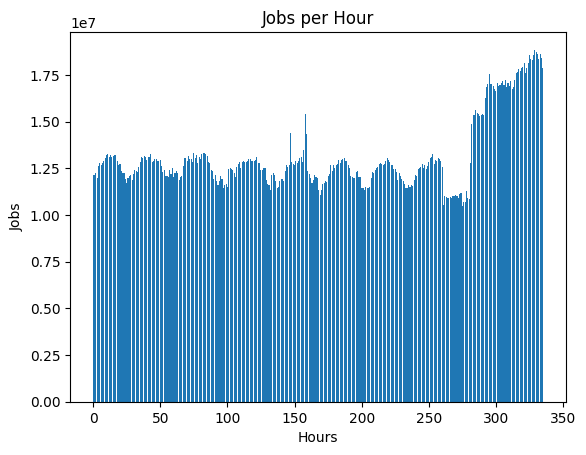

In [7]:
plt.bar(df19.index, df19.y)
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

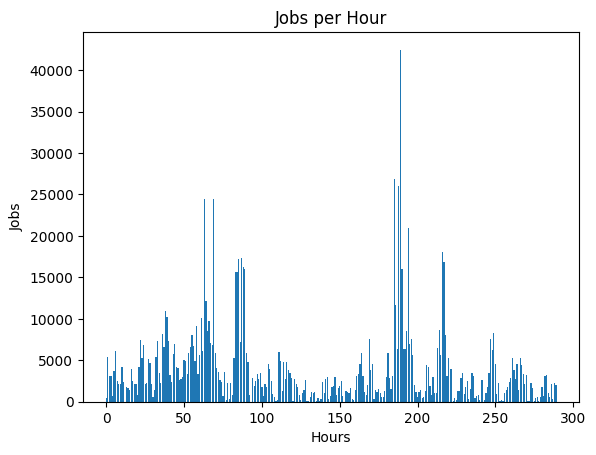

In [8]:
plt.bar(data_df.index, data_df['y'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

In [10]:
m = Prophet()
m.fit(df19)
future = m.make_future_dataframe(periods=100, freq = 'H')
future.tail()

12:11:49 - cmdstanpy - INFO - Chain [1] start processing
12:11:49 - cmdstanpy - INFO - Chain [1] done processing


ds
431 2023-01-18 23:00:00
432 2023-01-19 00:00:00
433 2023-01-19 01:00:00
434 2023-01-19 02:00:00
435 2023-01-19 03:00:00

In [11]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

ds          yhat    yhat_lower    yhat_upper
431 2023-01-18 23:00:00  2.905979e+07  2.748417e+07  3.065980e+07
432 2023-01-19 00:00:00  2.914043e+07  2.755610e+07  3.069776e+07
433 2023-01-19 01:00:00  2.928005e+07  2.776451e+07  3.093009e+07
434 2023-01-19 02:00:00  2.944563e+07  2.785150e+07  3.096441e+07
435 2023-01-19 03:00:00  2.960721e+07  2.792808e+07  3.115579e+07

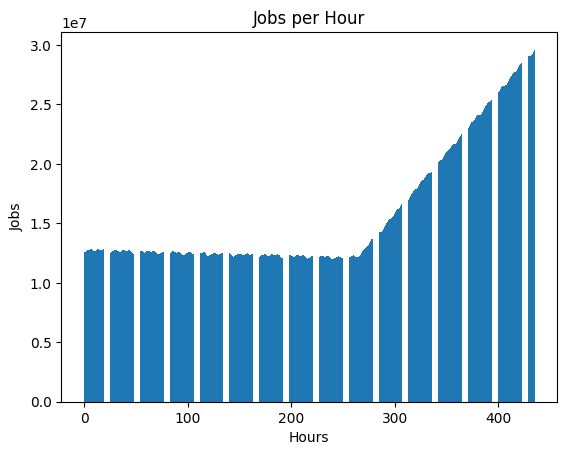

In [12]:
plt.bar(forecast['ds'].index, forecast['yhat'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

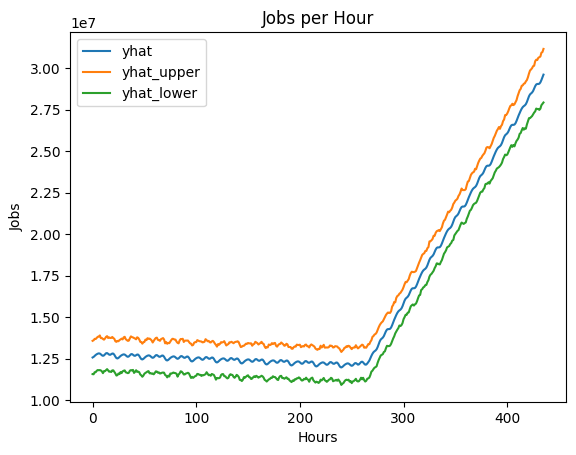

In [13]:
plt.plot(forecast['ds'].index, forecast['yhat'])
plt.plot(forecast['ds'].index, forecast['yhat_upper'])
plt.plot(forecast['ds'].index, forecast['yhat_lower'])
plt.title("Jobs per Hour")
plt.legend(["yhat", "yhat_upper", "yhat_lower"])
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

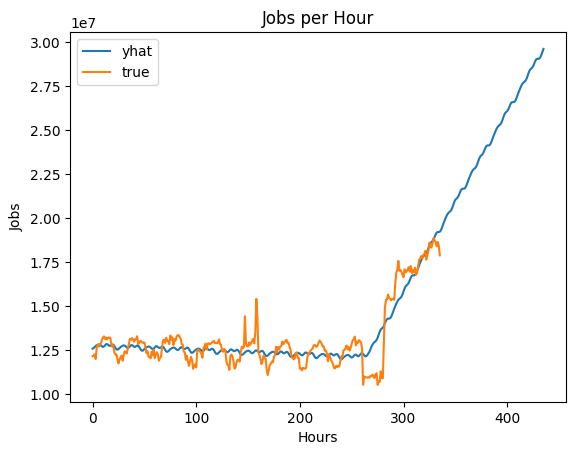

In [14]:
plt.plot(forecast.index, forecast['yhat'])
plt.plot(df19.index, df19.y)
plt.title("Jobs per Hour")
plt.legend(["yhat", "true"])
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

13:32:28 - cmdstanpy - INFO - Chain [1] start processing
13:32:28 - cmdstanpy - INFO - Chain [1] done processing


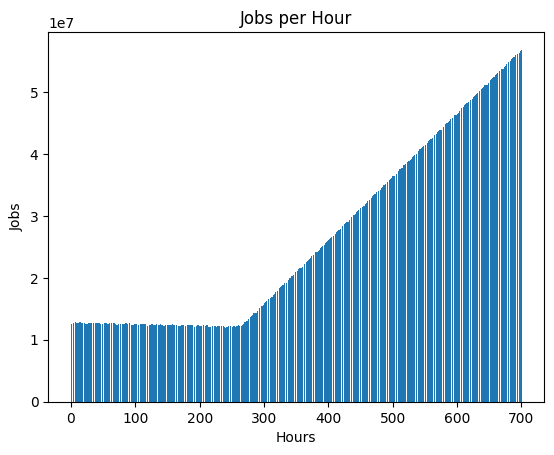

In [15]:
m = Prophet()
m.fit(df19)
future = m.make_future_dataframe(periods=365, freq = 'H')
forecast = m.predict(future)
plt.bar(forecast['ds'].index, forecast['yhat'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

In [12]:

def AzureFunctions2019_workload_per_day(day):
    top_funcs = [
        '063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794860338638212d30dfb',
        '93d4c31373200d74272af6e0feb443ea1206b83034d563ad7bc934e89b12e170',
        'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c',
        '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc',
        '8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e'
    ]
    
    fileString = './Workloads/Azure/AzureFunctionsDataset2019/invocations_per_function_md.anon.d' + str(day).zfill(2) + '.csv'
    azuredf = pd.read_csv(fileString)

    sel_func_series = azuredf[azuredf.columns[4:]].sum()
    sel_hourly = sel_func_series.groupby((sel_func_series.index.astype(int) - 1) // 60).sum()

    return sel_hourly

def AzureFunctions2019_total_workload():
    dateString = '2019-01-'
    outputList = []

    for i in range(1,15):
        dayString = dateString + str(i).zfill(2)
        date_object = datetime.strptime(dayString, '%Y-%m-%d').date()
        datetime_object = datetime(date_object.year, date_object.month, date_object.day)
        hourlySeries = AzureFunctions2019_workload_per_day(i)
        for index, value in hourlySeries.items():
            datetime_ind = datetime_object + timedelta(hours=index)
            outputList.append([datetime.strftime(datetime_ind, '%Y-%m-%d %H:%M:%S'), value])
        
    return outputList


In [13]:
x = AzureFunctions2019_total_workload()
totaldf = pd.DataFrame(x, columns =['ds', 'y'])
totaldf.head()

ds         y
0  2019-01-01 00:00:00  32862030
1  2019-01-01 01:00:00  32746554
2  2019-01-01 02:00:00  34385569
3  2019-01-01 03:00:00  33641370
4  2019-01-01 04:00:00  34801510

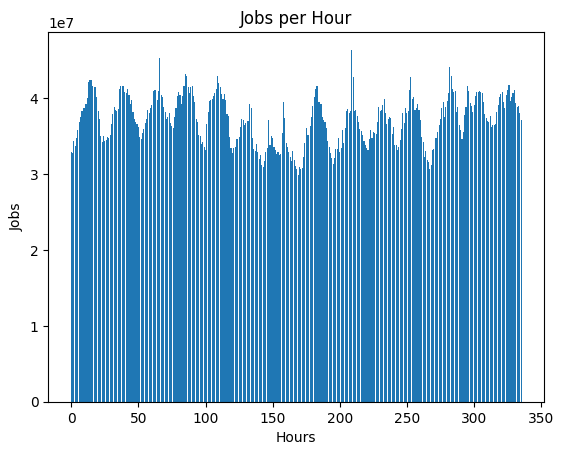

In [14]:
plt.bar(totaldf.index, totaldf.y)
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

16:21:06 - cmdstanpy - INFO - Chain [1] start processing
16:21:06 - cmdstanpy - INFO - Chain [1] done processing


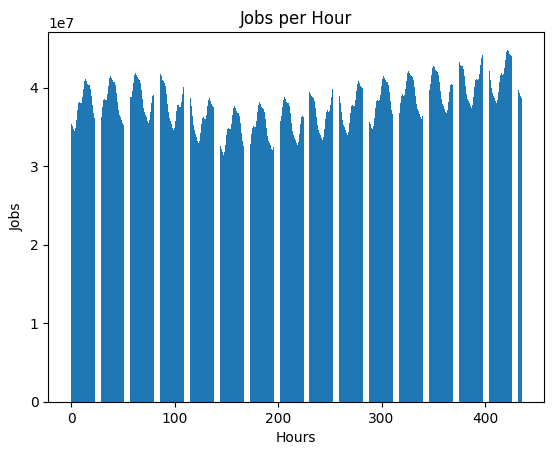

In [18]:
m = Prophet()
m.fit(totaldf)
future = m.make_future_dataframe(periods=100, freq = 'H')
forecast = m.predict(future)
plt.bar(forecast['ds'].index, forecast['yhat'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

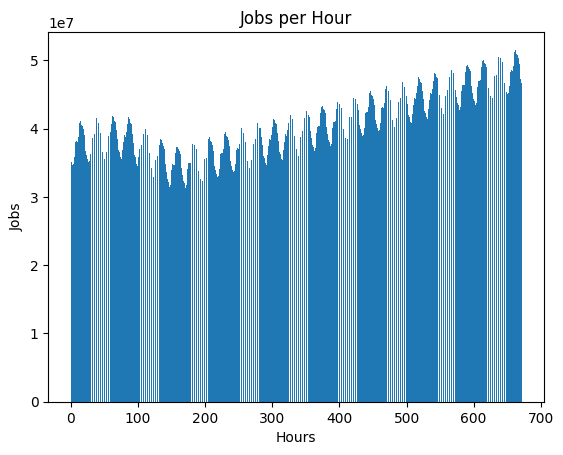

In [16]:
future = m.make_future_dataframe(periods=336, freq = 'H')
forecast = m.predict(future)
plt.bar(forecast['ds'].index, forecast['yhat'])
plt.title("Jobs per Hour")
plt.xlabel("Hours")
plt.ylabel("Jobs")
plt.show()

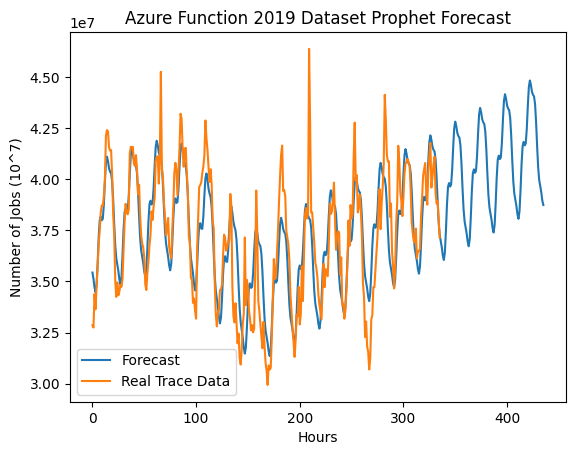

In [19]:
plt.plot(forecast.index, forecast['yhat'])
plt.plot(totaldf.index, totaldf.y)
plt.title("Azure Function 2019 Dataset Prophet Forecast")
plt.legend(["Forecast", "Real Trace Data"])
plt.xlabel("Hours")
plt.ylabel("Number of Jobs (10^7)")
plt.show()

In [9]:
x = './output/azure_2021_data/requests_watttime.csv'
df = pd.read_csv(x, header=None, names=['datetime', 'reqs', 'emissions'])
df['reqs'].groupby(df.index // 24).sum().mean()

80825.07142857143

In [3]:
x = './output/azure_2021_data/requests_marginal.csv'
y = './output/gen_AI/requests_marginal.csv'
df21 = pd.read_csv(x, header=None, names=['datetime', 'reqs', 'emissions'])
dfai = pd.read_csv(y, header=None, names=['datetime', 'reqs', 'emissions'])
dfai.head()

datetime         reqs      emissions
0  2022-01-01 00:00:00  2368.247461  386301.035284
1  2022-01-01 01:00:00  2766.521941  453505.540529
2  2022-01-01 02:00:00  3060.959672  512856.768661
3  2022-01-01 03:00:00  3209.316261  543863.405341
4  2022-01-01 04:00:00  3313.450194  560333.675340

In [4]:
df21.head()

datetime  reqs      emissions
0  2022-01-01 00:00:00     0       0.000000
1  2022-01-01 01:00:00   485   79504.226546
2  2022-01-01 02:00:00  5411  906600.632766
3  2022-01-01 03:00:00  3071  520423.785580
4  2022-01-01 04:00:00  3073  519671.425081

In [5]:
print(dfai['emissions'].sum())
print(df21['emissions'].sum())

176888452.76588553
177672909.8982283


In [4]:
x = pd.read_csv('./Data/post_processing/average_ci.csv', index_col='datetime')
y = pd.read_csv('./Data/post_processing/marginal_ci.csv', index_col='datetime')
x.tail()

FR  US-MIDA-PJM      KR      SG   JP-TK  AU-NSW   
datetime                                                                  
2023-12-31 19:00:00  25.16       372.48  404.04  495.11  582.18  626.22  \
2023-12-31 20:00:00  25.42       370.29  405.42  495.06  582.07  493.16   
2023-12-31 21:00:00  26.11       373.99  403.72  495.23  580.42  361.71   
2023-12-31 22:00:00  26.83       380.73  404.61  495.33  563.89  316.87   
2023-12-31 23:00:00  29.06       386.86  402.19  494.52  481.58  320.83   

                     BR-CS      DE   IT-NO      IE      GB  
datetime                                                    
2023-12-31 19:00:00  83.46  186.76  333.72  155.84  117.05  
2023-12-31 20:00:00  83.75  186.06  342.93  165.02   99.20  
2023-12-31 21:00:00  87.39  188.34  324.02  179.89   90.35  
2023-12-31 22:00:00  85.59  188.80  337.50  187.62   92.56  
2023-12-31 23:00:00  85.15  192.64  323.51  196.68   96.58

In [12]:
marFR = y.loc['2023-01-01 00:00:00':'2023-12-31 23:00:00']['FR']
marFR.rename('marginal', inplace=True)
aveFR = x['FR']
aveFR.rename('average', inplace=True)
aveFR

datetime
2023-01-01 00:00:00    56.64
2023-01-01 01:00:00    58.17
2023-01-01 02:00:00    56.65
2023-01-01 03:00:00    57.90
2023-01-01 04:00:00    57.72
                       ...  
2023-12-31 19:00:00    25.16
2023-12-31 20:00:00    25.42
2023-12-31 21:00:00    26.11
2023-12-31 22:00:00    26.83
2023-12-31 23:00:00    29.06
Name: average, Length: 8760, dtype: float64

In [13]:
FRavemar = pd.concat([marFR, aveFR], axis=1)
FRavemar

marginal  average
datetime                                
2023-01-01 00:00:00  195.294428    56.64
2023-01-01 01:00:00  195.315802    58.17
2023-01-01 02:00:00  195.150244    56.65
2023-01-01 03:00:00  195.781293    57.90
2023-01-01 04:00:00  193.028383    57.72
...                         ...      ...
2023-12-31 19:00:00  199.422272    25.16
2023-12-31 20:00:00  203.097007    25.42
2023-12-31 21:00:00  215.059782    26.11
2023-12-31 22:00:00  232.907155    26.83
2023-12-31 23:00:00  224.279989    29.06

[8760 rows x 2 columns]

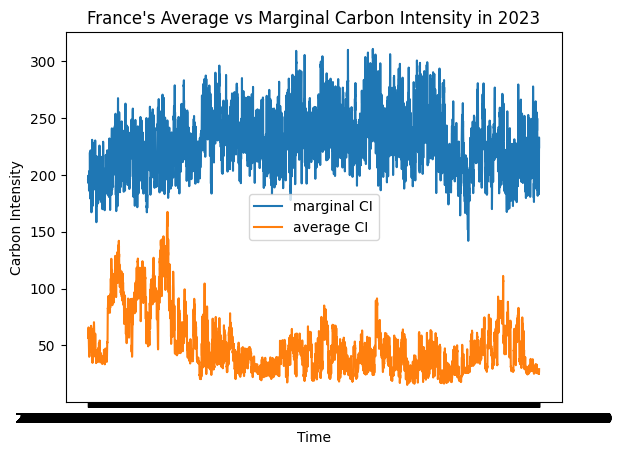

done


In [22]:
plt.plot(FRavemar.index, FRavemar['marginal'])
plt.plot(FRavemar.index, FRavemar['average'])
plt.title("France's Average vs Marginal Carbon Intensity in 2023")
plt.legend(["marginal CI", "average CI"])
plt.xlabel("Time")
plt.ylabel("Carbon Intensity")
plt.show()
print("done")

<Axes: title={'center': "France's Average vs Marginal Carbon Intensity in 2023"}, xlabel='Date Time', ylabel='Carbon Intensity (gCO₂eq/kWh)'>

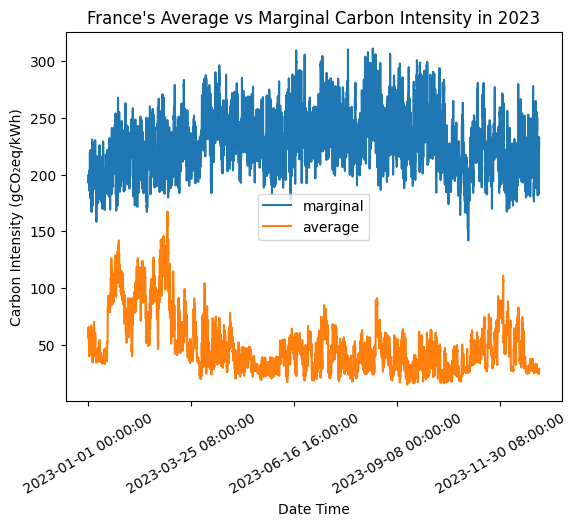

In [29]:
plot = FRavemar.plot(title="France's Average vs Marginal Carbon Intensity in 2023", rot=30, ylabel='Carbon Intensity (gCO₂eq/kWh)', xlabel='Date Time')
plot

In [2]:
temporal_module = os.path.join(currdir,"./Workloads/",  "Temporal")
sys.path.append(temporal_module)
import temporalWorkload
w_list = temporalWorkload.t_workload(80825, 0, 721)
df = pd.DataFrame(w_list, columns=['datetime', 'jobs'])
df = df.set_index('datetime')
df

jobs
datetime                   
2023-01-01 00:00:00  110515
2023-01-01 01:00:00   95139
2023-01-01 02:00:00   96100
2023-01-01 03:00:00  104749
2023-01-01 04:00:00  110515
...                     ...
2023-01-31 19:00:00  104749
2023-01-31 20:00:00  115320
2023-01-31 21:00:00   90334
2023-01-31 22:00:00  106671
2023-01-31 23:00:00  113398

[744 rows x 1 columns]

<Axes: title={'center': 'Temporal Jobs Per Hour'}, xlabel='Date Time', ylabel='Number of Jobs'>

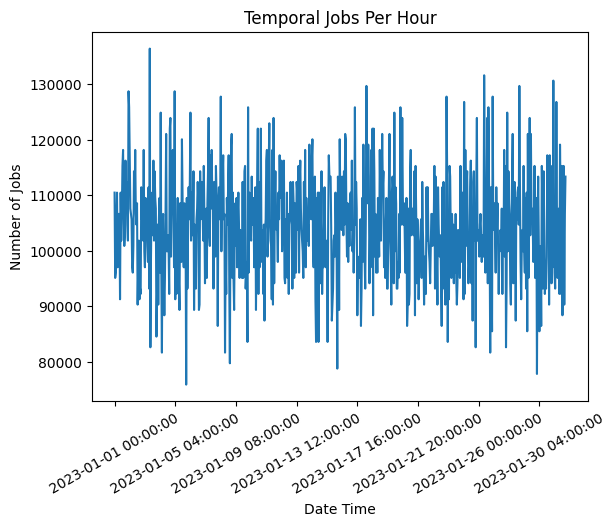

In [11]:
plot = df.plot(title="Temporal Jobs Per Hour", rot=30, ylabel='Number of Jobs', xlabel='Date Time', legend=False)
plot

In [22]:
data_df = Azure_processing.AzureFunctionsInvocationTraceForTwoWeeksJan2021()
data_df = data_df.set_index('start_hour')
data_df

count
start_hour                
2021-01-31 00:00:00      0
2021-01-31 01:00:00    485
2021-01-31 02:00:00   5411
2021-01-31 03:00:00   3071
2021-01-31 04:00:00   3073
...                    ...
2021-02-13 19:00:00   2183
2021-02-13 20:00:00      0
2021-02-13 21:00:00    273
2021-02-13 22:00:00   2222
2021-02-13 23:00:00   2005

[336 rows x 1 columns]

<Axes: title={'center': '2021 Azure Function Invocation Trace'}, xlabel='Date', ylabel='Number of Jobs'>

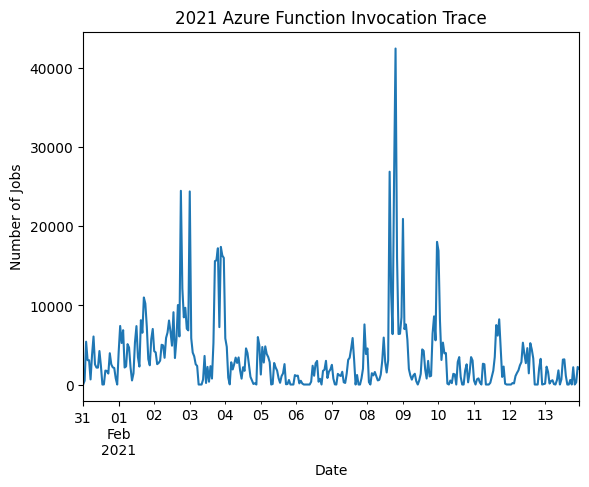

In [27]:
plot = data_df.plot(title="2021 Azure Function Invocation Trace", ylabel='Number of Jobs', xlabel='Date', legend=False)
plot

In [12]:
ave = pd.read_csv('./output/gen_AI/requests_average.csv', header=None, usecols=[1,2], names=['reqs', 'ElectricityMaps average'])
mar = pd.read_csv('./output/gen_AI/requests_marginal.csv', header=None, usecols=[1,2], names=['reqs', 'ElectricityMaps marginal'])
wat = pd.read_csv('./output/gen_AI/requests_watttime.csv', header=None, usecols=[1,2], names=['reqs', 'WattTime marginal'])
mar.head()

reqs  ElectricityMaps marginal
0  2368.247461             386301.035284
1  2766.521941             453505.540529
2  3060.959672             512856.768661
3  3209.316261             543863.405341
4  3313.450194             560333.675340

In [19]:
genAIems = pd.concat([ave['ElectricityMaps average'], mar['ElectricityMaps marginal'], wat['WattTime marginal']], axis=1)
genAIems.loc[:, 'WattTime marginal'] *=(453.592/1000)
genAIems.head()

ElectricityMaps average  ElectricityMaps marginal  WattTime marginal
0            198392.165460             386301.035284       9.445022e+05
1            227674.682842             453505.540529       1.073303e+06
2            252772.245488             512856.768661       1.146270e+06
3            270967.017149             543863.405341       1.086105e+06
4            284336.736994             560333.675340       1.299766e+06

<Axes: title={'center': 'CarbonMin Emissions with Generative AI Workload and DIfferent Carbon Metrics'}, xlabel='Hours', ylabel='Carbon Emissions (gCO₂eq/kWh)'>

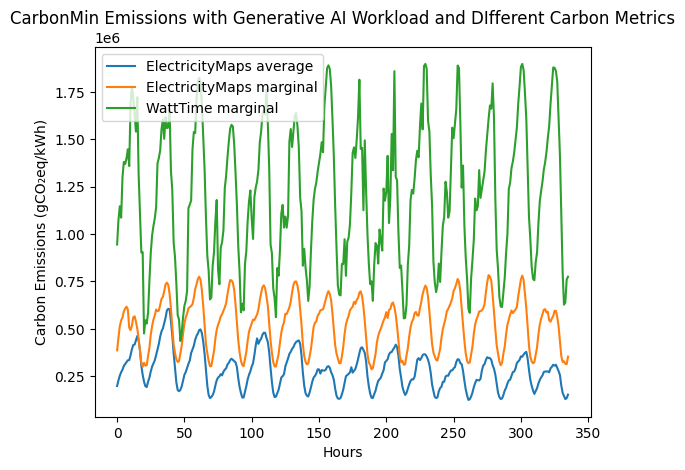

In [22]:
plot = genAIems.plot(title="CarbonMin Emissions with Generative AI Workload and DIfferent Carbon Metrics", ylabel='Carbon Emissions (gCO₂eq/kWh)', xlabel='Hours')
plot

In [23]:
ave = pd.read_csv('./output/azure_2019_data/requests_average.csv', header=None, usecols=[1,2], names=['reqs', 'ElectricityMaps average'])
mar = pd.read_csv('./output/azure_2019_data/requests_marginal.csv', header=None, usecols=[1,2], names=['reqs', 'ElectricityMaps marginal'])
wat = pd.read_csv('./output/azure_2019_data/requests_watttime.csv', header=None, usecols=[1,2], names=['reqs', 'WattTime marginal'])
mar.head()

reqs  ElectricityMaps marginal
0  12138489              1.979992e+09
1  12166481              1.994405e+09
2  12238125              2.050470e+09
3  11985696              2.031143e+09
4  12643481              2.138124e+09

In [24]:
a19ems = pd.concat([ave['ElectricityMaps average'], mar['ElectricityMaps marginal'], wat['WattTime marginal']], axis=1)
a19ems.loc[:, 'WattTime marginal'] *=(453.592/1000)
a19ems.head()

ElectricityMaps average  ElectricityMaps marginal  WattTime marginal
0             1.016862e+09              1.979992e+09       4.841061e+09
1             1.001257e+09              1.994405e+09       4.720120e+09
2             1.010617e+09              2.050470e+09       4.582942e+09
3             1.011969e+09              2.031143e+09       4.056229e+09
4             1.084974e+09              2.138124e+09       4.959655e+09

<Axes: title={'center': 'CarbonMin Emissions with Azure 2019 Workload and DIfferent Carbon Metrics'}, xlabel='Hours', ylabel='Carbon Emissions (gCO₂eq/kWh)'>

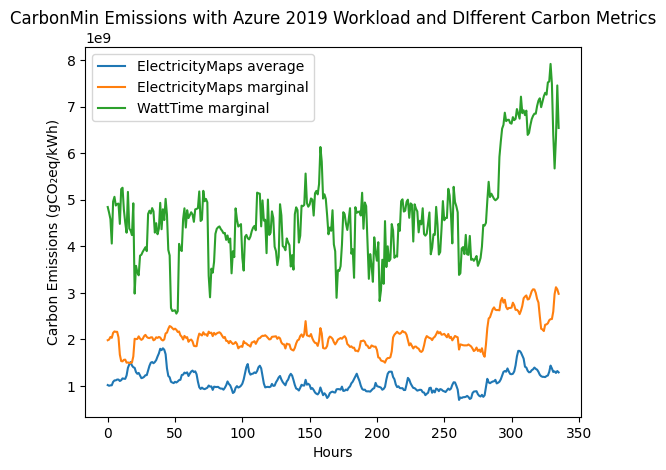

In [26]:
plot = a19ems.plot(title="CarbonMin Emissions with Azure 2019 Workload and DIfferent Carbon Metrics", ylabel='Carbon Emissions (gCO₂eq/kWh)', xlabel='Hours')
plot

In [27]:
ave = pd.read_csv('./output/azure_2021_data/requests_average.csv', header=None, usecols=[1,2], names=['reqs', 'ElectricityMaps average'])
mar = pd.read_csv('./output/azure_2021_data/requests_marginal.csv', header=None, usecols=[1,2], names=['reqs', 'ElectricityMaps marginal'])
wat = pd.read_csv('./output/azure_2021_data/requests_watttime.csv', header=None, usecols=[1,2], names=['reqs', 'WattTime marginal'])
a21ems = pd.concat([ave['ElectricityMaps average'], mar['ElectricityMaps marginal'], wat['WattTime marginal']], axis=1)
a21ems.loc[:, 'WattTime marginal'] *=(453.592/1000)
a21ems.head()

ElectricityMaps average  ElectricityMaps marginal  WattTime marginal
0                 0.000000                  0.000000       0.000000e+00
1             39913.734113              79504.226546       1.881611e+05
2            446837.190632             906600.632766       2.026315e+06
3            259288.783630             520423.785580       1.039296e+06
4            263703.010937             519671.425081       1.205445e+06

<Axes: title={'center': 'CarbonMin Emissions with Azure 2021 Workload and DIfferent Carbon Metrics'}, xlabel='Hours', ylabel='Carbon Emissions (gCO₂eq/kWh)'>

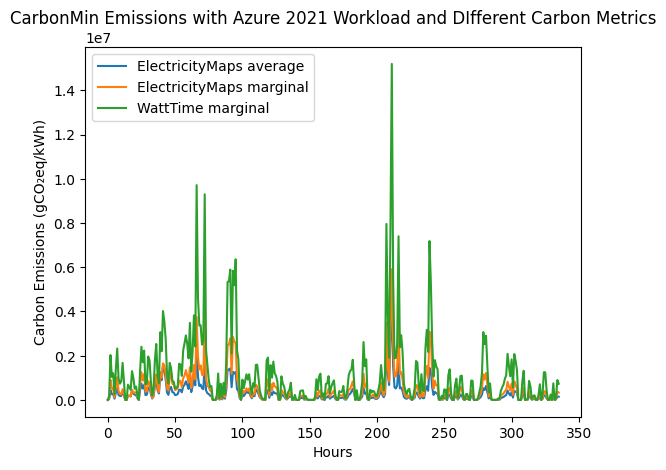

In [28]:
plot = a21ems.plot(title="CarbonMin Emissions with Azure 2021 Workload and DIfferent Carbon Metrics", ylabel='Carbon Emissions (gCO₂eq/kWh)', xlabel='Hours')
plot

In [30]:
a21 = pd.read_csv('./output/azure_2021_data/requests_average.csv', header=None, usecols=[1], names=['Azure 2021 Requests'])
a19 = pd.read_csv('./output/azure_2019_data/requests_average.csv', header=None, usecols=[1], names=['Azure 2019 Requests'])
gen = pd.read_csv('./output/gen_AI/requests_marginal.csv', header=None, usecols=[1], names=['Generative AI Requests'])
gen.head()

Generative AI Requests
0             2368.247461
1             2766.521941
2             3060.959672
3             3209.316261
4             3313.450194

In [31]:
combinedReqs = pd.concat([a21, a19, gen], axis=1)
combinedReqs.head()

Azure 2021 Requests  Azure 2019 Requests  Generative AI Requests
0                    0             12138489             2368.247461
1                  485             12166481             2766.521941
2                 5411             12238125             3060.959672
3                 3071             11985696             3209.316261
4                 3073             12643481             3313.450194

<Axes: title={'center': 'Requests Across Different Workloads'}, xlabel='Hours', ylabel='Requests'>

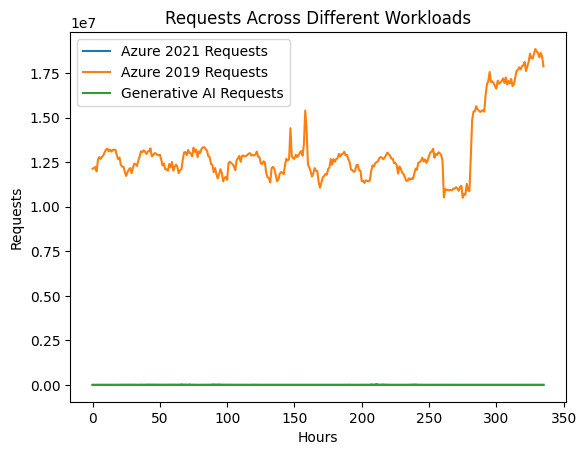

In [32]:
plot = combinedReqs.plot(title="Requests Across Different Workloads", ylabel='Requests', xlabel='Hours')
plot

<Axes: title={'center': 'Requests Across Generative AI and Azure 2021 Workloads'}, xlabel='Hours', ylabel='Requests'>

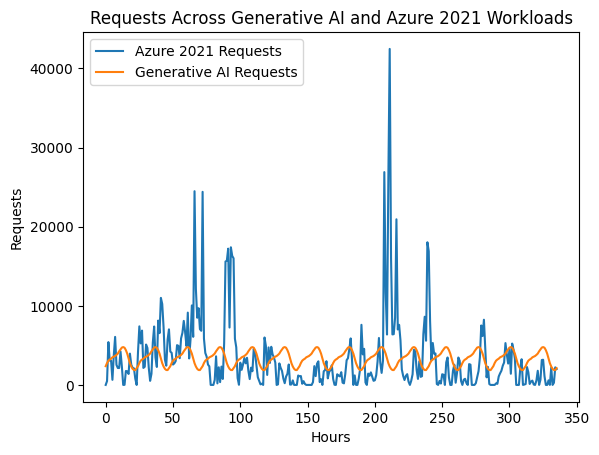

In [36]:
#combinedReqs = combinedReqs.drop(columns=['Azure 2019 Requests'])
plot = combinedReqs.plot(title="Requests Across Generative AI and Azure 2021 Workloads", ylabel='Requests', xlabel='Hours')
plot

In [15]:
top_funcs = ['063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794860338638212d30dfb',
     '93d4c31373200d74272af6e0feb443ea1206b83034d563ad7bc934e89b12e170',
     'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c',
     '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc',
     '8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e']
df = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/function_durations_percentiles.anon.d11.csv', usecols=[2,3])
x = df.loc[df['HashFunction'].isin(top_funcs)]
x.head()

HashFunction  Average
10     8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0...     1562
19     dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13...      276
32393  93d4c31373200d74272af6e0feb443ea1206b83034d563...       16
32394  063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794...        3
46961  5315be05fc3b21a3f483ed0759bce825764dcf8a762623...      284

In [16]:
x.loc[:, 'Average'] *= 0.001 #(1/1000)
x

HashFunction  Average
10     8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0...    1.562
19     dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13...    0.276
32393  93d4c31373200d74272af6e0feb443ea1206b83034d563...    0.016
32394  063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794...    0.003
46961  5315be05fc3b21a3f483ed0759bce825764dcf8a762623...    0.284

In [3]:
top_funcs = ['063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794860338638212d30dfb',
     '93d4c31373200d74272af6e0feb443ea1206b83034d563ad7bc934e89b12e170',
     'dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13d1b5f30b4f6c381d5c',
     '5315be05fc3b21a3f483ed0759bce825764dcf8a762623a1d94ff63f9d9ce4cc',
     '8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0811a15194b3a507f0e']
df = pd.read_csv('./Workloads/Azure/AzureFunctionsDataset2019/function_durations_percentiles.anon.d10.csv', usecols=[2,3,4])

x = df.loc[df['HashFunction'].isin(top_funcs)]
x.loc[:, 'Average'] *= 0.001
sum = x.Count.sum()
x.loc[:, 'Count'] /= sum
x

HashFunction  Average     Count
7      dd833bb70b3a57caaa6b4e4560975d9ba5a77fd0151e13...    0.258  0.160344
93     8203ff88388384a6f9ed28664e8e9484119ff340cb7dc0...    1.666  0.404089
32181  93d4c31373200d74272af6e0feb443ea1206b83034d563...    0.016  0.074035
32182  063ba6f3c1d425f6f5c3bde3b9ba1eba7c6d81c57fd794...    0.003  0.068850
47119  5315be05fc3b21a3f483ed0759bce825764dcf8a762623...    0.286  0.292682

In [5]:
print(x.Count.sum())
x[['Average', 'Count']].values.tolist()

1.0


[[0.258, 0.1603437306551932],
 [1.666, 0.40408868702627393],
 [0.016, 0.07403532369394347],
 [0.003, 0.06884983620632518],
 [0.28600000000000003, 0.29268242241826425]]

In [2]:
print('1')
z = Azure_processing.AzureFunctions2019_total_workload()
print('2')
q = z.to_df()
q.head()

1
2


start_timestamp duration location num_of_requests
0  2019-01-01 00:00:00    0.265      N/A    33348.807344
1  2019-01-01 00:00:00    1.633      N/A    86946.073583
2  2019-01-01 00:00:00    0.004      N/A    15035.592015
3  2019-01-01 00:00:00    0.019      N/A     16385.47345
4  2019-01-01 00:00:00    0.295      N/A    57010.053609

In [3]:
q

start_timestamp duration location num_of_requests
0       2019-01-01 00:00:00    0.265      N/A    33348.807344
1       2019-01-01 00:00:00    1.633      N/A    86946.073583
2       2019-01-01 00:00:00    0.004      N/A    15035.592015
3       2019-01-01 00:00:00    0.019      N/A     16385.47345
4       2019-01-01 00:00:00    0.295      N/A    57010.053609
...                     ...      ...      ...             ...
100795  2019-01-14 23:59:00    0.076      N/A   124092.712517
100796  2019-01-14 23:59:00    1.555      N/A    84228.246736
100797  2019-01-14 23:59:00    0.004      N/A    14704.513759
100798  2019-01-14 23:59:00    0.016      N/A    16036.291544
100799  2019-01-14 23:59:00    0.282      N/A    58388.235443

[100800 rows x 4 columns]

In [2]:
df = Azure_processing.AzureFunctionsInvocationTraceForTwoWeeksJan2021()
df.head()

start_timestamp  duration location  num_of_requests
0 2021-01-31 01:47:09     0.611      N/A                1
1 2021-01-31 01:47:10     0.007      N/A                1
2 2021-01-31 01:47:10     0.171      N/A                1
3 2021-01-31 01:47:12     0.001      N/A                1
4 2021-01-31 01:47:12     0.006      N/A                1

In [3]:
#df.start_timestamp = pd.to_datetime(df.start_timestamp)
x = df.set_index('start_timestamp').resample('H').num_of_requests.sum().reset_index()
#x.start_timestamp = x.start_timestamp.astype(str)
x

start_timestamp  num_of_requests
0   2021-01-31 01:00:00              485
1   2021-01-31 02:00:00             5411
2   2021-01-31 03:00:00             3071
3   2021-01-31 04:00:00             3073
4   2021-01-31 05:00:00              644
..                  ...              ...
330 2021-02-13 19:00:00             2183
331 2021-02-13 20:00:00                0
332 2021-02-13 21:00:00              273
333 2021-02-13 22:00:00             2222
334 2021-02-13 23:00:00             2005

[335 rows x 2 columns]

In [4]:
df.dtypes

start_timestamp    datetime64[ns]
duration                  float64
location                   object
num_of_requests             int64
dtype: object

In [5]:
x.dtypes

start_timestamp    datetime64[ns]
num_of_requests             int64
dtype: object

In [6]:
print('1')
z = Azure_processing.AzureFunctions2019_total_workload()
print('2')
z.head(10)

1
2


start_timestamp  duration location  num_of_requests
0      2019-01-01     0.265      N/A            33348
1      2019-01-01     1.633      N/A            86946
2      2019-01-01     0.004      N/A            15035
3      2019-01-01     0.019      N/A            16385
4      2019-01-01     0.295      N/A            57010

In [7]:
z.dtypes

start_timestamp    datetime64[ns]
duration                  float64
location                   object
num_of_requests             int64
dtype: object

In [3]:
y = temporalWorkload.t_workload(jobs = 80825, start_dt = 0, end_dt = 744, loc="FR")
y.head()

start_timestamp  duration location  num_of_requests
0      2023-01-01      1740       FR                1
1      2023-01-01      3660       FR                2
2      2023-01-01      4800       FR                3
3      2023-01-01      1260       FR                1
4      2023-01-01      4140       FR                4

In [4]:
y.dtypes

start_timestamp    datetime64[ns]
duration                    int64
location                   object
num_of_requests             int64
dtype: object

In [5]:
y

start_timestamp  duration location  num_of_requests
0     2023-01-01 00:00:00      1740       FR                1
1     2023-01-01 00:00:00      3660       FR                2
2     2023-01-01 00:00:00      4800       FR                3
3     2023-01-01 00:00:00      1260       FR                1
4     2023-01-01 00:00:00      4140       FR                4
...                   ...       ...      ...              ...
44381 2023-01-31 23:00:00      2880       FR                1
44382 2023-01-31 23:00:00      2160       FR                1
44383 2023-01-31 23:00:00      4920       FR                1
44384 2023-01-31 23:00:00      4740       FR                1
44385 2023-01-31 23:00:00      2700       FR                1

[44386 rows x 4 columns]

In [2]:
my_cal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal.csv', parse_dates=True, index_col='datetime')
#my_fr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_fr.csv', parse_dates=True, index_col='datetime')
#my_gb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_gb.csv', parse_dates=True, index_col='datetime')
#my_ger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_ger.csv', parse_dates=True, index_col='datetime')

#o_ger = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_ger.csv', parse_dates=True, index_col='Time')
#o_gb = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_gb.csv', parse_dates=True, index_col='Time')
#o_fr = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_fr.csv', parse_dates=True, index_col='Time')
o_cal = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_cal.csv', parse_dates=True, index_col='Time')

my_cal

active_jobs          ci   emissions
datetime                                                
2020-01-01 09:30:00          1.0  198.038260  198.038260
2020-01-01 10:00:00          1.0  198.004460  198.004460
2020-01-01 10:30:00          2.0  193.978108  387.956215
2020-01-01 11:00:00          2.0  191.614939  383.229878
2020-01-01 11:30:00          4.0  189.749617  758.998469
...                          ...         ...         ...
2021-01-09 21:30:00          0.0  384.748858    0.000000
2021-01-09 22:00:00          0.0  384.678774    0.000000
2021-01-09 22:30:00          0.0  384.936327    0.000000
2021-01-09 23:00:00          0.0  380.925641    0.000000
2021-01-09 23:30:00          0.0  380.722918    0.000000

[17981 rows x 3 columns]

In [17]:
o_cal.head(25)

active_jobs          ci    emissions
Time                                                     
2020-01-01 00:00:00          0.0  342.092256     0.000000
2020-01-01 00:30:00          0.0  347.220539     0.000000
2020-01-01 01:00:00          0.0  344.967632     0.000000
2020-01-01 01:30:00          0.0  339.952418     0.000000
2020-01-01 02:00:00          0.0  336.563101     0.000000
2020-01-01 02:30:00          0.0  337.679261     0.000000
2020-01-01 03:00:00          0.0  336.802710     0.000000
2020-01-01 03:30:00          0.0  337.903643     0.000000
2020-01-01 04:00:00          0.0  334.472237     0.000000
2020-01-01 04:30:00          0.0  325.146220     0.000000
2020-01-01 05:00:00          0.0  325.820187     0.000000
2020-01-01 05:30:00          0.0  331.867930     0.000000
2020-01-01 06:00:00          0.0  320.465876     0.000000
2020-01-01 06:30:00          0.0  334.398645     0.000000
2020-01-01 07:00:00          0.0  324.922309     0.000000
2020-01-01 07:30:00          0.0  312.447197     0.000000
2020-01-01 08:00:00          0.0  272.807254     0.000000
2020-01-01 08:30:00          0.0  242.908057     0.000000
2020-01-01 09:00:00          0.0  218.413992     0.000000
2020-01-01 09:30:00          1.0  198.038260   198.038260
2020-01-01 10:00:00          1.0  198.004460   198.004460
2020-01-01 10:30:00          2.0  193.978108   387.956215
2020-01-01 11:00:00          2.0  191.614939   383.229878
2020-01-01 11:30:00          4.0  189.749617   758.998469
2020-01-01 12:00:00          7.0  176.511346  1235.579419

In [4]:
em_msd = []
job_msd = []

countries = ["cal", "gb", "ger", "fr"]
interr = [True, False]
errors = [0, 0.05, 0.1]
forcastmethods = ["next_workday", "semi_weekly"]
for country in countries:
    for inter in interr:
        for error in errors:
            for forecast_method in forcastmethods:
                i = "_i" if inter else ""
                e = f"_{error}" if error else ""
                o_series  = pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/results/ml_{forecast_method}{e}{i}_{country}.csv', parse_dates=True, index_col='Time')
                my_series = pd.read_csv(f'./output/lets_wait_awhile/temporal/LWA/ml_{forecast_method}{e}{i}_{country}.csv', parse_dates=True, index_col='datetime')

                o_series = o_series[my_series.index[0]:]
                
                print(f'o {forecast_method}{error}{i}_{country} min jobs: {o_series.active_jobs.min()}')
                print(f'o {forecast_method}{error}{i}_{country} max jobs: {o_series.active_jobs.max()}')
                print(f'my {forecast_method}{error}{i}_{country} min jobs: {my_series.active_jobs.min()}')
                print(f'my {forecast_method}{error}{i}_{country} max jobs: {my_series.active_jobs.max()}')
                
                diff_series = (my_series.emissions - o_series.emissions).dropna()
                square_series = diff_series.pow(2)
                sum = square_series.sum()
                em_msd.append(f'{forecast_method}{error}{i}_{country} emission mean squared difference: {sum/square_series.size}')
                
                diff_series = (my_series.active_jobs - o_series.active_jobs).dropna()
                square_series = diff_series.pow(2)
                sum = square_series.sum()
                job_msd.append(f'{forecast_method}{error}{i}_{country} active job mean squared difference: {sum/square_series.size}')

for x in em_msd:
    print(x)
for x in job_msd:
    print(x)

o next_workday0_i_cal min jobs: 0.0
o next_workday0_i_cal max jobs: 45.0
my next_workday0_i_cal min jobs: 0.0
my next_workday0_i_cal max jobs: 45.0
o semi_weekly0_i_cal min jobs: 0.0
o semi_weekly0_i_cal max jobs: 65.0
my semi_weekly0_i_cal min jobs: 0.0
my semi_weekly0_i_cal max jobs: 65.0
o next_workday0.05_i_cal min jobs: 0.0
o next_workday0.05_i_cal max jobs: 44.9
my next_workday0.05_i_cal min jobs: 0.0
my next_workday0.05_i_cal max jobs: 44.9
o semi_weekly0.05_i_cal min jobs: 0.0
o semi_weekly0.05_i_cal max jobs: 65.0
my semi_weekly0.05_i_cal min jobs: 0.0
my semi_weekly0.05_i_cal max jobs: 65.0
o next_workday0.1_i_cal min jobs: 0.0
o next_workday0.1_i_cal max jobs: 44.8
my next_workday0.1_i_cal min jobs: 0.0
my next_workday0.1_i_cal max jobs: 44.8
o semi_weekly0.1_i_cal min jobs: 0.0
o semi_weekly0.1_i_cal max jobs: 65.0
my semi_weekly0.1_i_cal min jobs: 0.0
my semi_weekly0.1_i_cal max jobs: 65.0
o next_workday0_cal min jobs: 0.0
o next_workday0_cal max jobs: 38.0
my next_workday

In [3]:
em_msd = []
job_msd = []
countries = ["cal", "gb", "ger", "fr"]
for country in countries:
    o_series  = pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/results/ml_0_{country}.csv', parse_dates=True, index_col='Time')
    my_series = pd.read_csv(f'./output/lets_wait_awhile/temporal/LWA/ml_0_{country}.csv', parse_dates=True, index_col='datetime')

    print(f'original ml_0_{country} min jobs: {o_series.active_jobs.min()}')
    print(f'original ml_0_{country} max jobs: {o_series.active_jobs.max()}')
    print(f'my ml_0_{country} min jobs: {my_series.active_jobs.min()}')
    print(f'my ml_0_{country} max jobs: {my_series.active_jobs.max()}')
    diff_series = (my_series.emissions - o_series.emissions).dropna()
    sum = diff_series.sum()
    print(f'ml_0_{country} sum of emission difference: {sum}')
    square_series = diff_series.pow(2)
    sum = square_series.sum()
    em_msd.append(f'ml_0_{country} emission mean squared difference: {sum/square_series.size}')
    diff_series = (my_series.active_jobs - o_series.active_jobs).dropna()
    sum = diff_series.sum()
    print(f'ml_0_{country} sum of active job difference: {sum}')
    square_series = diff_series.pow(2)
    sum = square_series.sum()
    job_msd.append(f'ml_0_{country} active job mean squared difference: {sum/square_series.size}')

    print(f'sum of my ml_0_{country} emissions: {my_series.emissions.sum()}')
    print(f'sum of o ml_0_{country} emissions: {o_series.emissions.sum()}')

for x in em_msd:
    print(x)
for x in job_msd:
    print(x)

original ml_0_cal min jobs: 0.0
original ml_0_cal max jobs: 45.0
my ml_0_cal min jobs: 0.0
my ml_0_cal max jobs: 45.0
ml_0_cal sum of emission difference: 1.1482370609883219e-11
ml_0_cal sum of active job difference: 0.0
sum of my ml_0_cal emissions: 87403257.09550653
sum of o ml_0_cal emissions: 87403257.09550653
original ml_0_gb min jobs: 0.0
original ml_0_gb max jobs: 45.0
my ml_0_gb min jobs: 0.0
my ml_0_gb max jobs: 45.0
ml_0_gb sum of emission difference: -1.2732925824820995e-11
ml_0_gb sum of active job difference: 0.0
sum of my ml_0_gb emissions: 67289066.8808628
sum of o ml_0_gb emissions: 67289066.8808628
original ml_0_ger min jobs: 0.0
original ml_0_ger max jobs: 45.0
my ml_0_ger min jobs: 0.0
my ml_0_ger max jobs: 45.0
ml_0_ger sum of emission difference: -1.2107648217352107e-11
ml_0_ger sum of active job difference: 0.0
sum of my ml_0_ger emissions: 99017964.67259885
sum of o ml_0_ger emissions: 99017964.67259885
original ml_0_fr min jobs: 0.0
original ml_0_fr max jobs: 45

In [2]:
countries = ["cal", "gb", "ger", "fr"]
errors = [0, 0.05]
mse_list = []
diff_list = []
my_sum = []
o_sum = []
for country in countries:
    for error in errors:
        o_series  = pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/results/periodic_{error}.csv')
        my_series = pd.read_csv(f'./output/lets_wait_awhile/temporal/LWA/periodic_{error}.csv')
    
        o_ems = o_series[country]
        my_ems = my_series[country]
        diff_series = (my_ems - o_ems).dropna()
        sum = diff_series.sum()
        diff_list.append(f'e{error} {country} sum of emission difference: {sum}')
        square_series = diff_series.pow(2)
        sum = square_series.sum()
        #print(f'e{error} {country} sum of emission difference squared: {sum}')
        mse_list.append(f'e{error} {country} emission mean squared difference: {sum/square_series.size}')
    
        my_sum.append(f'sum of my periodic{error} {country} emissions: {my_ems.sum()}')
        o_sum.append(f'sum of o periodic{error} {country} emissions: {o_ems.sum()}')
for i, val in enumerate(o_sum):
    print(o_sum[i])
    print(my_sum[i])
for i in diff_list:
    print(i)
for i in mse_list:
    print(i)

sum of o periodic0 cal emissions: 4925.9421214576205
sum of my periodic0 cal emissions: 4925.9421214576205
sum of o periodic0.05 cal emissions: 4996.502481291151
sum of my periodic0.05 cal emissions: 4996.502481291151
sum of o periodic0 gb emissions: 2894.1437823143283
sum of my periodic0 gb emissions: 2894.1437823143283
sum of o periodic0.05 gb emissions: 2958.989859486185
sum of my periodic0.05 gb emissions: 2958.989859486185
sum of o periodic0 ger emissions: 4914.096091081887
sum of my periodic0 ger emissions: 4914.096091081887
sum of o periodic0.05 ger emissions: 4997.694003850395
sum of my periodic0.05 ger emissions: 4997.694003850395
sum of o periodic0 fr emissions: 837.6115541905241
sum of my periodic0 fr emissions: 837.6115541905241
sum of o periodic0.05 fr emissions: 853.4289495635769
sum of my periodic0.05 fr emissions: 853.4289495635769
e0 cal sum of emission difference: 0.0
e0.05 cal sum of emission difference: -8.526512829121202e-14
e0 gb sum of emission difference: 0.0
e0

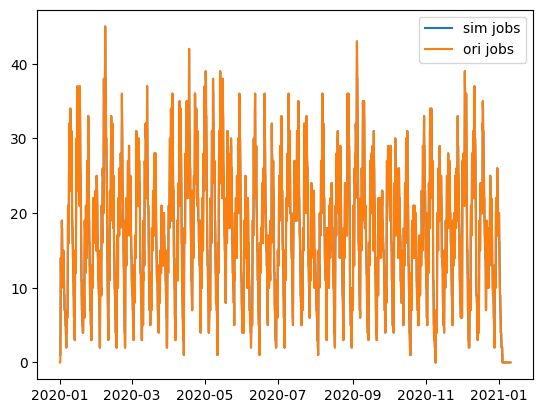

In [11]:
plt.plot(my_cal.index, my_cal.active_jobs)
plt.plot(o_cal.index, o_cal.active_jobs)
plt.legend(["sim jobs", "ori jobs"])
plt.show()

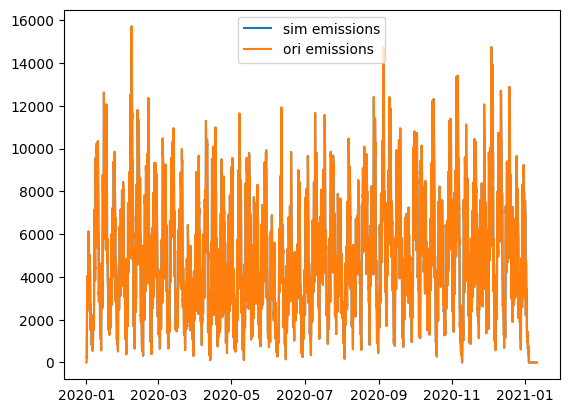

In [14]:
plt.plot(my_cal.index, my_cal.emissions)
plt.plot(o_cal.index, o_cal.emissions)
plt.legend(["sim emissions", "ori emissions"])
plt.show()

In [2]:
fr = pd.read_csv('./periodic_0.05_fr_jobs.csv', parse_dates=True)
gb = pd.read_csv('./periodic_0.05_gb_jobs.csv', parse_dates=True)
ger = pd.read_csv('./periodic_0.05_ger_jobs.csv', parse_dates=True)
cal = pd.read_csv('./periodic_0.05_cal_jobs.csv', parse_dates=True)
cal

time  jobs
0      2020-01-01 00:00:00   0.0
1      2020-01-01 00:30:00   0.0
2      2020-01-01 01:00:00   0.0
3      2020-01-01 01:30:00   0.0
4      2020-01-01 02:00:00   0.0
...                    ...   ...
18043  2021-01-10 21:30:00   0.0
18044  2021-01-10 22:00:00   0.0
18045  2021-01-10 22:30:00   0.0
18046  2021-01-10 23:00:00   0.0
18047  2021-01-10 23:30:00   0.0

[18048 rows x 2 columns]

In [3]:
ger.time = pd.to_datetime(ger.time).dt.time
gb.time = pd.to_datetime(gb.time).dt.time
fr.time = pd.to_datetime(fr.time).dt.time
cal.time = pd.to_datetime(cal.time).dt.time
cal

time  jobs
0      00:00:00   0.0
1      00:30:00   0.0
2      01:00:00   0.0
3      01:30:00   0.0
4      02:00:00   0.0
...         ...   ...
18043  21:30:00   0.0
18044  22:00:00   0.0
18045  22:30:00   0.0
18046  23:00:00   0.0
18047  23:30:00   0.0

[18048 rows x 2 columns]

In [4]:
cal = cal.groupby('time').jobs.sum()
ger = ger.groupby('time').jobs.sum()
gb = gb.groupby('time').jobs.sum()
fr = fr.groupby('time').jobs.sum()
fr

time
00:00:00    12.0
00:30:00    14.0
01:00:00    17.0
01:30:00    29.0
02:00:00    26.0
02:30:00    24.0
03:00:00    23.0
03:30:00    18.0
04:00:00    12.0
04:30:00    10.0
05:00:00     3.0
05:30:00     6.0
06:00:00     3.0
06:30:00     5.0
07:00:00     4.0
07:30:00     3.0
08:00:00     9.0
08:30:00     8.0
09:00:00     8.0
09:30:00     0.0
10:00:00     0.0
10:30:00     0.0
11:00:00     0.0
11:30:00     0.0
12:00:00     0.0
12:30:00     0.0
13:00:00     0.0
13:30:00     0.0
14:00:00     0.0
14:30:00     0.0
15:00:00     0.0
15:30:00     0.0
16:00:00     0.0
16:30:00     0.0
17:00:00     8.0
17:30:00     6.0
18:00:00    10.0
18:30:00    10.0
19:00:00    13.0
19:30:00    10.0
20:00:00    12.0
20:30:00     5.0
21:00:00     7.0
21:30:00     8.0
22:00:00     9.0
22:30:00    10.0
23:00:00     7.0
23:30:00    15.0
Name: jobs, dtype: float64

In [20]:
y = cal[0:19]
x = cal[34:48]
call = pd.concat([x, y])

frr = pd.concat([fr[34:48], fr[0:19]])
gerr = pd.concat([ger[34:48], ger[0:19]])
gbb = pd.concat([gb[34:48], gb[0:19]])
frr

time
17:00:00     8.0
17:30:00     6.0
18:00:00    10.0
18:30:00    10.0
19:00:00    13.0
19:30:00    10.0
20:00:00    12.0
20:30:00     5.0
21:00:00     7.0
21:30:00     8.0
22:00:00     9.0
22:30:00    10.0
23:00:00     7.0
23:30:00    15.0
00:00:00    12.0
00:30:00    14.0
01:00:00    17.0
01:30:00    29.0
02:00:00    26.0
02:30:00    24.0
03:00:00    23.0
03:30:00    18.0
04:00:00    12.0
04:30:00    10.0
05:00:00     3.0
05:30:00     6.0
06:00:00     3.0
06:30:00     5.0
07:00:00     4.0
07:30:00     3.0
08:00:00     9.0
08:30:00     8.0
09:00:00     8.0
Name: jobs, dtype: float64

<Axes: xlabel='time'>

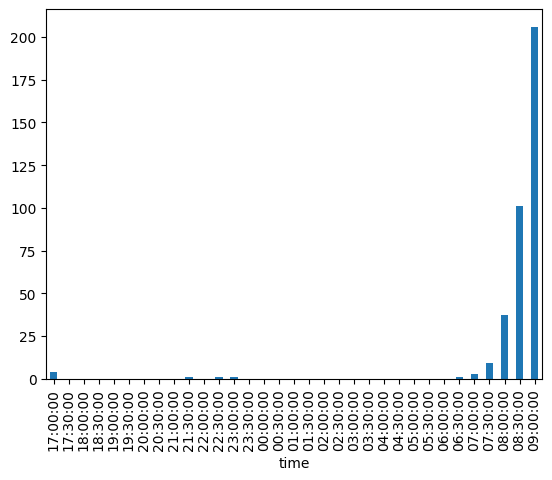

In [22]:
call.plot(kind='bar')

<Axes: xlabel='time'>

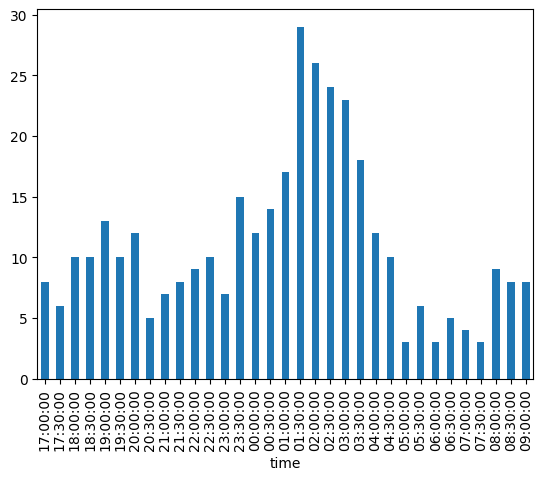

In [23]:
frr.plot(kind='bar')

<Axes: xlabel='time'>

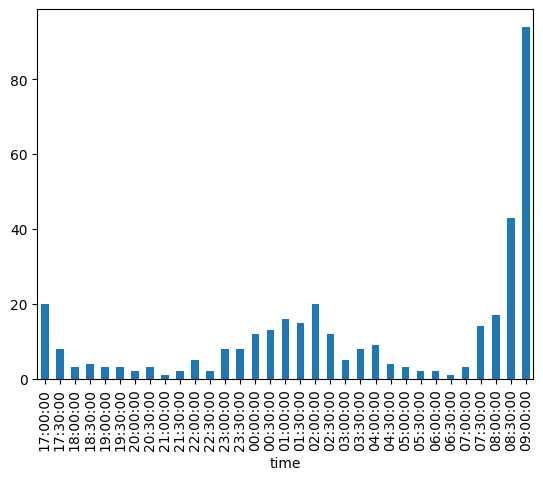

In [24]:
gerr.plot(kind='bar')

<Axes: xlabel='time'>

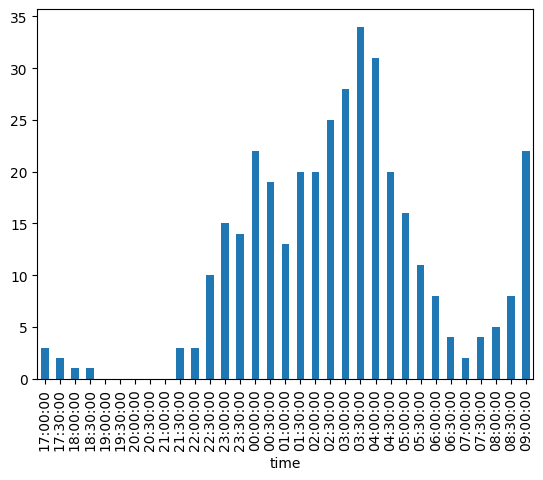

In [25]:
gbb.plot(kind='bar')

In [2]:
cdf = country_users.country_processing()
cdf

countries code  UTC   percent   users
0            India   IN  5.5  0.256284  467.00
1    United States   US -4.0  0.135002  246.00
2           Brazil   BR -2.0  0.083635  152.40
3        Indonesia   ID  7.0  0.091647  167.00
4           Mexico   MX -6.0  0.051586   94.00
5            Japan   JP  9.0  0.050488   92.00
6         Pakistan   PK  5.0  0.039348   71.70
7          Germany   DE  2.0  0.038909   70.90
8          Vietnam   VN  7.0  0.038415   70.00
9           Turkey   TR  3.0  0.034327   62.55
10     Philippines   PH  8.0  0.046345   84.45
11      Bangladesh   BD  6.0  0.024531   44.70
12        Thailand   TH  7.0  0.028674   52.25
13           Egypt   EG  3.0  0.025381   46.25
14  United Kingdom   GB  1.0  0.031336   57.10
15           Italy   IT  2.0  0.024092   43.90

In [5]:
cdf.values.tolist()

[['India', 'IN', 5.5, 0.2562836132147953, 467.0],
 ['United States', 'US', -4.0, 0.135001646361541, 246.0],
 ['Brazil', 'BR', -2.0, 0.08363516628251565, 152.4],
 ['Indonesia', 'ID', 7.0, 0.09164745911535506, 167.0],
 ['Mexico', 'MX', -6.0, 0.05158599495115794, 94.0],
 ['Japan', 'JP', 9.0, 0.050488420590495006, 92.0],
 ['Pakistan', 'PK', 5.0, 0.039348040829766215, 71.7],
 ['Germany', 'DE', 2.0, 0.038909011085501044, 70.9],
 ['Vietnam', 'VN', 7.0, 0.03841510262320272, 70.0],
 ['Turkey', 'TR', 3.0, 0.034326638129733286, 62.55],
 ['Philippines', 'PH', 8.0, 0.046345077378992426, 84.45],
 ['Bangladesh', 'BD', 6.0, 0.024530786960816595, 44.7],
 ['Thailand', 'TH', 7.0, 0.028674130172319175, 52.25],
 ['Egypt', 'EG', 3.0, 0.02538140709033037, 46.25],
 ['United Kingdom', 'GB', 1.0, 0.031335747996926795, 57.1],
 ['Italy', 'IT', 2.0, 0.02409175721655142, 43.9]]

In [3]:
paperdf = pd.read_csv('./Workloads/carbonMin_paper_country_data.csv')
paperdf

country code  UTC  percent
0   United States   US -4.0     0.39
1          France   FR  2.0     0.07
2         Germany   DE  2.0     0.12
3     Netherlands   NL  2.0     0.04
4  United Kingdom   GB  1.0     0.12
5           India   IN  5.5     0.18
6           Japan   JP  9.0     0.08

In [3]:
owork = genAI.workloadOverADay(requestsADay=80825, end_index=744, start_date= datetime.strptime('2022-01-01', '%Y-%m-%d').date())
owork

start_timestamp               duration location  num_of_requests
0     2022-01-01 00:00:00 0 days 00:00:02.075321       IN              104
1     2022-01-01 00:00:00 0 days 00:00:02.075321       US              687
2     2022-01-01 00:00:00 0 days 00:00:02.075321       BR              297
3     2022-01-01 00:00:00 0 days 00:00:02.075321       ID              289
4     2022-01-01 00:00:00 0 days 00:00:02.075321       MX              263
...                   ...                    ...      ...              ...
11899 2022-01-31 23:00:00 0 days 00:00:02.075321       BD               10
11900 2022-01-31 23:00:00 0 days 00:00:02.075321       TH               49
11901 2022-01-31 23:00:00 0 days 00:00:02.075321       EG                8
11902 2022-01-31 23:00:00 0 days 00:00:02.075321       GB               23
11903 2022-01-31 23:00:00 0 days 00:00:02.075321       IT               10

[11904 rows x 4 columns]

In [6]:
nwork = genAI.workloadOverADay(requestsADay=80825, total_hours=744, start_date= datetime.strptime('2022-01-01', '%Y-%m-%d'), countryDF=paperdf)
nwork

start_timestamp               duration location  num_of_requests
0    2022-01-01 00:00:00 0 days 00:00:02.075321       US             1986
1    2022-01-01 00:00:00 0 days 00:00:02.075321       FR               23
2    2022-01-01 00:00:00 0 days 00:00:02.075321       DE               39
3    2022-01-01 00:00:00 0 days 00:00:02.075321       NL               13
4    2022-01-01 00:00:00 0 days 00:00:02.075321       GB               48
...                  ...                    ...      ...              ...
5203 2022-01-31 23:00:00 0 days 00:00:02.075321       DE               48
5204 2022-01-31 23:00:00 0 days 00:00:02.075321       NL               16
5205 2022-01-31 23:00:00 0 days 00:00:02.075321       GB               87
5206 2022-01-31 23:00:00 0 days 00:00:02.075321       IN               44
5207 2022-01-31 23:00:00 0 days 00:00:02.075321       JP              323

[5208 rows x 4 columns]

In [7]:
nwork.start_timestamp = pd.to_datetime(nwork.start_timestamp).dt.hour

hourdf = pd.DataFrame(nwork.drop(columns=['duration']).groupby(['start_timestamp', 'location']).num_of_requests.sum())
hourdf = hourdf.reset_index()
hourdf['start_timestamp'] = hourdf['start_timestamp'].apply(lambda x: f'{country_users.hour_localization(x, -8):0>2}:00:00')

hourdf

start_timestamp location  num_of_requests
0          16:00:00       DE             1209
1          16:00:00       FR              713
2          16:00:00       GB             1488
3          16:00:00       IN             2263
4          16:00:00       JP            11036
..              ...      ...              ...
163        15:00:00       GB             2697
164        15:00:00       IN             1364
165        15:00:00       JP            10013
166        15:00:00       NL              496
167        15:00:00       US            61566

[168 rows x 3 columns]

In [8]:
frdf = hourdf[hourdf.location == 'FR'].drop(columns=['location']).set_index('start_timestamp')
frdf = pd.concat([frdf[8:24], frdf[0:8]])
usdf = hourdf[hourdf.location == 'US'].drop(columns=['location']).set_index('start_timestamp')
usdf = pd.concat([usdf[8:24], usdf[0:8]])
dedf = hourdf[hourdf.location == 'DE'].drop(columns=['location']).set_index('start_timestamp')
dedf = pd.concat([dedf[8:24], dedf[0:8]])
nldf = hourdf[hourdf.location == 'NL'].drop(columns=['location']).set_index('start_timestamp')
nldf = pd.concat([nldf[8:24], nldf[0:8]])
gbdf = hourdf[hourdf.location == 'GB'].drop(columns=['location']).set_index('start_timestamp')
gbdf = pd.concat([gbdf[8:24], gbdf[0:8]])
indf = hourdf[hourdf.location == 'IN'].drop(columns=['location']).set_index('start_timestamp')
indf = pd.concat([indf[8:24], indf[0:8]])
jpdf = hourdf[hourdf.location == 'JP'].drop(columns=['location']).set_index('start_timestamp')
jpdf = pd.concat([jpdf[8:24], jpdf[0:8]])
sumdf = hourdf.drop(columns=['location']).groupby(['start_timestamp']).num_of_requests.sum()
sumdf

start_timestamp
00:00:00     94147
01:00:00     98208
02:00:00    115165
03:00:00    132463
04:00:00    142600
05:00:00    145080
06:00:00    145793
07:00:00    144770
08:00:00    143406
09:00:00    135501
10:00:00    125364
11:00:00    118172
12:00:00    106919
13:00:00     93465
14:00:00     82522
15:00:00     78492
16:00:00     78678
17:00:00     82119
18:00:00     75423
19:00:00     60202
20:00:00     59427
21:00:00     72974
22:00:00     84382
23:00:00     90055
Name: num_of_requests, dtype: int64

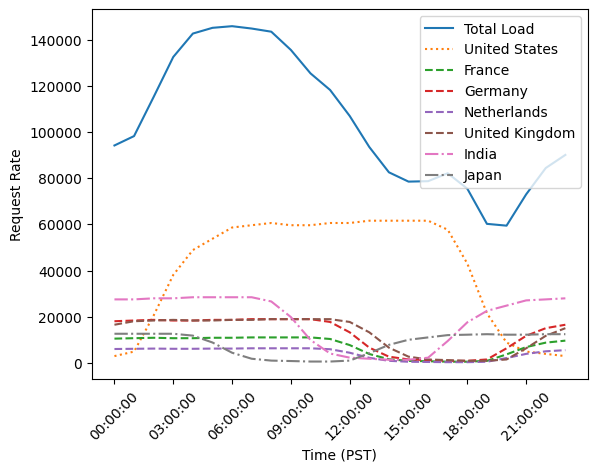

In [17]:
plt.plot(sumdf.index, sumdf)
plt.plot(usdf.index, usdf.num_of_requests, linestyle = 'dotted')
plt.plot(frdf.index, frdf.num_of_requests, linestyle = 'dashed')
plt.plot(dedf.index, dedf.num_of_requests, linestyle = 'dashed')
plt.plot(nldf.index, nldf.num_of_requests, linestyle = 'dashed')
plt.plot(gbdf.index, gbdf.num_of_requests, linestyle = 'dashed')
plt.plot(indf.index, indf.num_of_requests, linestyle = 'dashdot')
plt.plot(jpdf.index, jpdf.num_of_requests, linestyle = 'dashdot')
plt.legend(["Total Load", "United States", "France", "Germany", "Netherlands", "United Kingdom", "India", "Japan"])#, bbox_to_anchor=(1, 1))
locs, labels = plt.xticks()
plt.xticks(locs[::3], labels[::3], rotation=45)
plt.xlabel("Time (PST)")
plt.ylabel("Request Rate")

plt.savefig('./Figures/m_cm_dist.png', dpi=300, bbox_inches='tight')
plt.show()

In [2]:
paper_cm_em = pd.read_csv('./output/carbon_min/gen_AI/requests_average.csv', parse_dates=True, header=None, usecols=[0,2], names=['datetime', 'emissions'])
paper_cm_em

datetime      emissions
0     2023-01-01 00:00:00  247953.276686
1     2023-01-01 01:00:00  251406.003945
2     2023-01-01 02:00:00  227972.457981
3     2023-01-01 03:00:00  185904.477622
4     2023-01-01 04:00:00  186789.063496
...                   ...            ...
8755  2023-12-31 19:00:00  215977.741463
8756  2023-12-31 20:00:00  180021.994554
8757  2023-12-31 21:00:00  156509.976680
8758  2023-12-31 22:00:00  136206.709730
8759  2023-12-31 23:00:00  130594.036809

[8760 rows x 2 columns]

<Axes: >

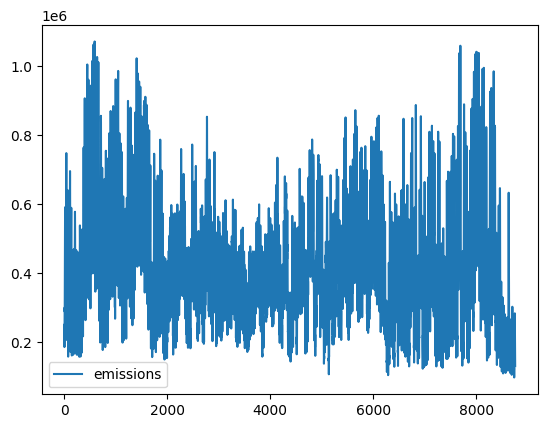

In [7]:
#max_em = paper_cm_em.emissions.max()
#print(max_em)
#print(paper_cm_em.emissions.min())
#paper_cm_em.loc[:, 'emissions'] /= max_em
#print(paper_cm_em)

paper_cm_em.plot()

<Axes: >

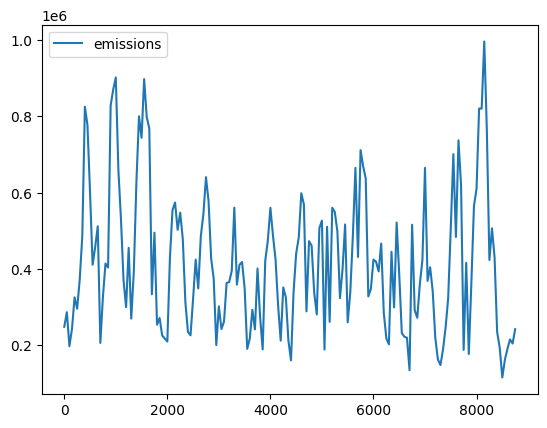

In [8]:
paper_cm_em.iloc[::50].plot()

In [9]:
countryDF = pd.read_csv('./Workloads/carbonMin_paper_country_data.csv')
carbon_string = 'average'
full_carbon_string = f'./Data/post_processing/{carbon_string}_ci.csv'
carbonDF = pd.read_csv(full_carbon_string, parse_dates=True)
carbonDF['datetime'] = carbonDF['datetime'].astype(str)
mini_carbondf = carbonDF[['datetime', 'IN-WE','NL','US-TEX-ERCO','FR','US-CAL-CISO','JP-TK','DE','GB']]
mini_carbondf.set_index(['datetime'])

work = genAI.workloadOverADay(requestsADay=80825, end_index=len(mini_carbondf.index), start_date=datetime.strptime('2023-01-01', '%Y-%m-%d').date(), countryDF=countryDF).drop(columns=['duration'])
work

start_timestamp location  num_of_requests
0     2023-01-01 00:00:00       US             1986
1     2023-01-01 00:00:00       FR               23
2     2023-01-01 00:00:00       DE               39
3     2023-01-01 00:00:00       NL               13
4     2023-01-01 00:00:00       GB               48
...                   ...      ...              ...
61315 2023-12-31 23:00:00       DE               48
61316 2023-12-31 23:00:00       NL               16
61317 2023-12-31 23:00:00       GB               87
61318 2023-12-31 23:00:00       IN               44
61319 2023-12-31 23:00:00       JP              323

[61320 rows x 3 columns]

In [10]:
def test_cm_paper(loca, reqs, time):
    zone_dict = {
        'IN': 'IN-WE',
        'NL': 'NL',
        'FR': 'FR',
        'JP': 'JP-TK',
        'DE': 'DE',
        'GB': 'GB',
        'US': 'US-CAL-CISO'
    }
    zone = zone_dict[loca]
    x = mini_carbondf.loc[mini_carbondf['datetime'] == str(time)][zone].iloc[0]

    return carbon_min_algorithm.operational_carbon_emissions(x, reqs) + carbon_min_algorithm.embodied_carbon_emissions(reqs, reqs)

In [11]:
list = []
print('started')
for i in work.start_timestamp.unique():
    sum = 0
    for j in work.loc[work['start_timestamp'] == i].values.tolist():
        sum += test_cm_paper(j[1],j[2],j[0])
    list.append([i, sum])
print('done')

started
done


In [12]:
local = pd.DataFrame(list, columns=['datetime', 'emissions'])#.set_index(['datetime'])
print(local.emissions.max())
print(local.emissions.min())
print(paper_cm_em.emissions.max())
print(paper_cm_em.emissions.min())
local

2180698.2543172715
363780.9049614768
1072492.8070676134
97664.25534914024


datetime      emissions
0    2023-01-01 00:00:00  778964.515864
1    2023-01-01 01:00:00  904045.308985
2    2023-01-01 02:00:00  958773.118819
3    2023-01-01 03:00:00  894278.649210
4    2023-01-01 04:00:00  890598.049399
...                  ...            ...
8755 2023-12-31 19:00:00  807308.900378
8756 2023-12-31 20:00:00  731719.266121
8757 2023-12-31 21:00:00  738363.513309
8758 2023-12-31 22:00:00  771381.927190
8759 2023-12-31 23:00:00  834347.366055

[8760 rows x 2 columns]

In [13]:
ave_em = (mini_carbondf['GB'].sum() + mini_carbondf['DE'].sum() + mini_carbondf['JP-TK'].sum() + mini_carbondf['US-CAL-CISO'].sum() + mini_carbondf['FR'].sum() + mini_carbondf['US-TEX-ERCO'].sum() + mini_carbondf['NL'].sum() + mini_carbondf['IN-WE'].sum())/8
ave_em

3130892.43125

<Axes: >

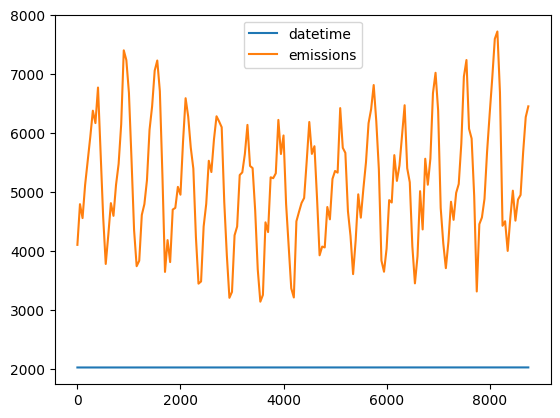

In [14]:
local.iloc[::50].plot()

3130892.43125
                 datetime  CarbonMin     Local
0     2023-01-01 00:00:00   0.079196  0.248800
1     2023-01-01 01:00:00   0.080299  0.288750
2     2023-01-01 02:00:00   0.072814  0.306230
3     2023-01-01 03:00:00   0.059377  0.285631
4     2023-01-01 04:00:00   0.059660  0.284455
...                   ...        ...       ...
8755  2023-12-31 19:00:00   0.068983  0.257853
8756  2023-12-31 20:00:00   0.057499  0.233709
8757  2023-12-31 21:00:00   0.049989  0.235832
8758  2023-12-31 22:00:00   0.043504  0.246378
8759  2023-12-31 23:00:00   0.041711  0.266489

[8760 rows x 3 columns]


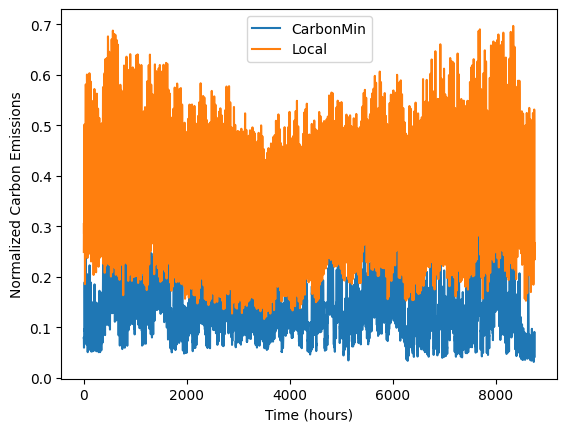

In [19]:
print(ave_em)
cm_em_copy = paper_cm_em.copy(deep=True)

cm_em_copy.loc[:, 'emissions'] /= ave_em
cm_em_copy = cm_em_copy.rename(columns={"emissions": "CarbonMin"})
cm_em_copy['Local'] = local.emissions
cm_em_copy.loc[:, 'Local'] /= ave_em
print(cm_em_copy)

ax = cm_em_copy.plot()
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Normalized Carbon Emissions")

plt.savefig('./Figures/m_cmVlo.png')

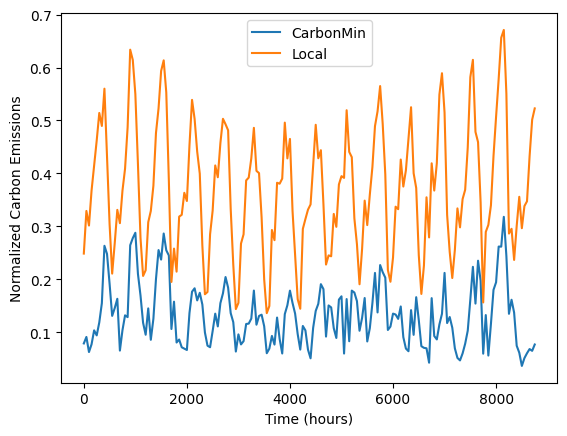

In [20]:
ax = cm_em_copy.iloc[::50].plot()
ax.set_xlabel("Time (hours)")
ax.set_ylabel("Normalized Carbon Emissions")

plt.savefig('./Figures/m_cmVlo_reduced.png')

In [16]:
poorcm = cm_em_copy[cm_em_copy['CarbonMin'].gt(cm_em_copy['Local'])]
poorcm

Empty DataFrame
Columns: [datetime, CarbonMin, Local]
Index: []

In [18]:
poorcm = cm_em_copy[cm_em_copy['CarbonMin'].ge(cm_em_copy['Local'])]
poorcm

Empty DataFrame
Columns: [datetime, CarbonMin, Local]
Index: []

In [71]:
temp = (cm_em_copy['Local'] - cm_em_copy['CarbonMin'])/cm_em_copy['Local']
print(1-temp.mean())
temp

0.3730780708363489


0       0.681689
1       0.721910
2       0.762225
3       0.792118
4       0.790266
          ...   
8755    0.732472
8756    0.753974
8757    0.788031
8758    0.823425
8759    0.843478
Length: 8760, dtype: float64

In [21]:
first = True
ofr = pd.DataFrame()
ogb = pd.DataFrame()
ocal = pd.DataFrame()
oger = pd.DataFrame()

mfr = pd.DataFrame()
mger = pd.DataFrame()
mgb = pd.DataFrame()
mcal = pd.DataFrame()
for seed in range(0,10):
    for win in range(16,17):
        if first:
            ofr = pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/fr/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            oger= pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/ger/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            ogb= pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/gb/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            ocal= pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/cal/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            
            mfr = pd.read_csv(f'./recreateExp/fr/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            mger = pd.read_csv(f'./recreateExp/ger/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            mgb = pd.read_csv(f'./recreateExp/gb/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            mcal = pd.read_csv(f'./recreateExp/cal/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)
            first = False
        else:
            ofr['jobs'] = ofr['jobs'] + pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/fr/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            oger['jobs'] = oger['jobs'] + pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/ger/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            ogb['jobs'] = ogb['jobs'] + pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/gb/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            ocal['jobs'] = ocal['jobs'] + pd.read_csv(f'./temp/full_lwa/lets-wait-awhile-master/recreateExp/cal/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            
            mfr['jobs'] = mfr['jobs'] + pd.read_csv(f'./recreateExp/fr/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            mger['jobs'] = mger['jobs'] + pd.read_csv(f'./recreateExp/ger/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            mgb['jobs'] = mgb['jobs'] + pd.read_csv(f'./recreateExp/gb/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
            mcal['jobs'] = mcal['jobs'] + pd.read_csv(f'./recreateExp/cal/periodic_0.05_{seed}_{win}_jobs.csv', index_col='time', parse_dates=True)['jobs']
mfr

jobs
time                     
2020-01-01 00:00:00   0.0
2020-01-01 00:30:00   0.0
2020-01-01 01:00:00   0.0
2020-01-01 01:30:00   0.0
2020-01-01 02:00:00   0.0
...                   ...
2021-01-09 20:30:00   0.0
2021-01-09 21:00:00   0.0
2021-01-09 21:30:00   0.0
2021-01-09 22:00:00   0.0
2021-01-09 22:30:00   0.0

[17998 rows x 1 columns]

In [22]:
diff_series = (mfr['jobs'] - ofr['jobs'])
sum = diff_series.sum()
square_series = diff_series.pow(2)
sum = square_series.sum()
print(f'fr job mean squared difference: {sum/square_series.size}')
diff_series = (mger['jobs'] - oger['jobs'])
sum = diff_series.sum()
square_series = diff_series.pow(2)
sum = square_series.sum()
print(f'ger job mean squared difference: {sum/square_series.size}')
diff_series = (mgb['jobs'] - ogb['jobs'])
sum = diff_series.sum()
square_series = diff_series.pow(2)
sum = square_series.sum()
print(f'gb job mean squared difference: {sum/square_series.size}')
diff_series = (mcal['jobs'] - ocal['jobs'])
sum = diff_series.sum()
square_series = diff_series.pow(2)
sum = square_series.sum()
print(f'cal job mean squared difference: {sum/square_series.size}')

fr job mean squared difference: 0.0
ger job mean squared difference: 0.0
gb job mean squared difference: 0.0
cal job mean squared difference: 0.0


[Text(0.5, 0, '')]

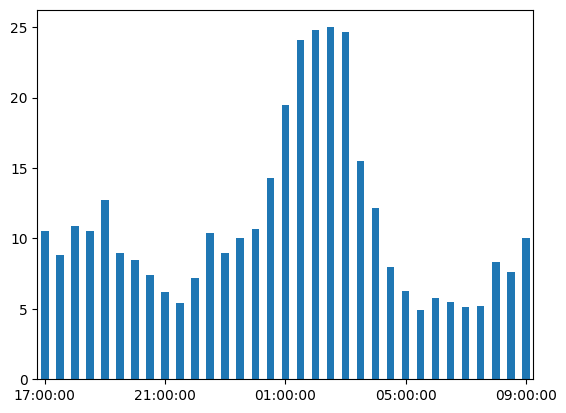

In [23]:
ofr = ofr.reset_index()
ofr.loc[:, 'jobs'] /= 10
ofr.time = pd.to_datetime(ofr.time).dt.time
ofr = ofr.groupby('time').jobs.sum()
ofrr = pd.concat([ofr[34:48], ofr[0:19]])
ax = ofrr.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/fr_o_periodic.png')

[Text(0.5, 0, '')]

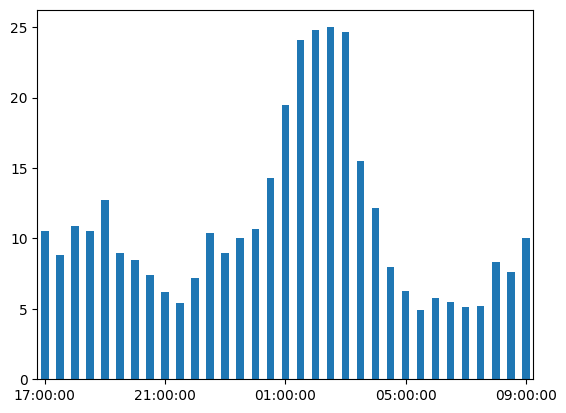

In [24]:
mfr = mfr.reset_index()
mfr.loc[:, 'jobs'] /= 10
mfr.time = pd.to_datetime(mfr.time).dt.time
mfr = mfr.groupby('time').jobs.sum()
mfrr = pd.concat([mfr[34:48], mfr[0:19]])
ax = mfrr.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/fr_m_periodic.png')

[Text(0.5, 0, '')]

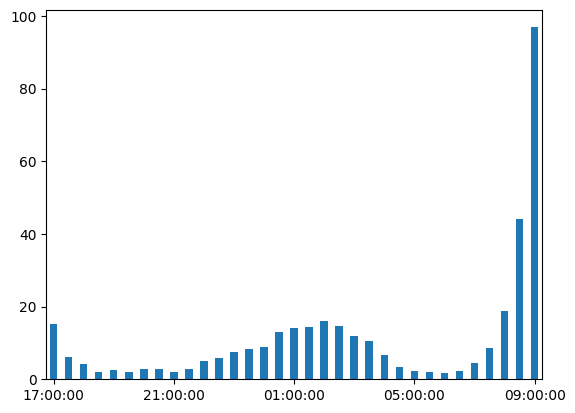

In [25]:
oger = oger.reset_index()
oger.loc[:, 'jobs'] /= 10
oger.time = pd.to_datetime(oger.time).dt.time
oger = oger.groupby('time').jobs.sum()
ogerr = pd.concat([oger[34:48], oger[0:19]])
ax = ogerr.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/ger_o_periodic.png')

[Text(0.5, 0, '')]

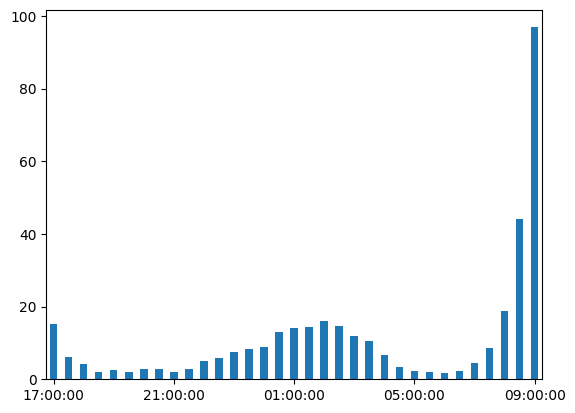

In [26]:
mger = mger.reset_index()
mger.loc[:, 'jobs'] /= 10
mger.time = pd.to_datetime(mger.time).dt.time
mger = mger.groupby('time').jobs.sum()
mgerr = pd.concat([mger[34:48], mger[0:19]])
ax = mgerr.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/ger_m_periodic.png')

[Text(0.5, 0, '')]

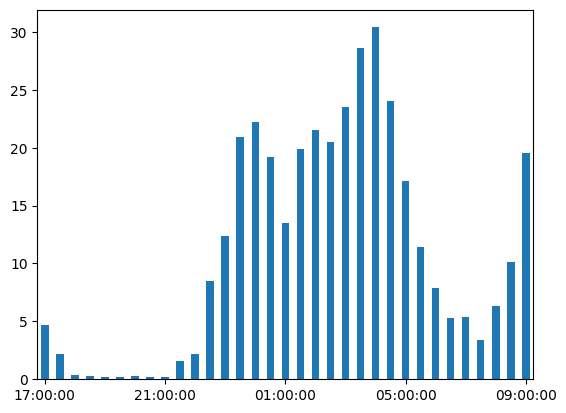

In [27]:
ogb = ogb.reset_index()
ogb.loc[:, 'jobs'] /= 10
ogb.time = pd.to_datetime(ogb.time).dt.time
ogb = ogb.groupby('time').jobs.sum()
ogbb = pd.concat([ogb[34:48], ogb[0:19]])
ax = ogbb.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/gb_o_periodic.png')

[Text(0.5, 0, '')]

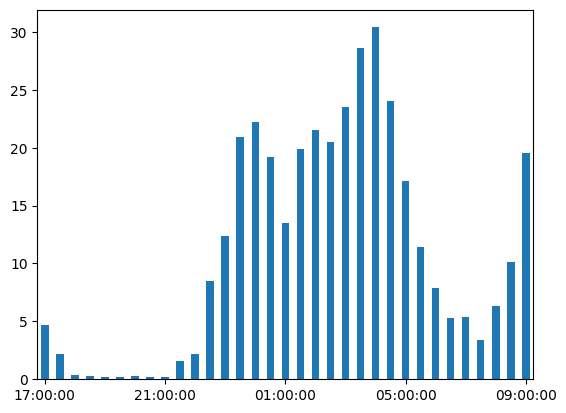

In [28]:
mgb = mgb.reset_index()
mgb.loc[:, 'jobs'] /= 10
mgb.time = pd.to_datetime(mgb.time).dt.time
mgb = mgb.groupby('time').jobs.sum()
mgbb = pd.concat([mgb[34:48], mgb[0:19]])
ax = mgbb.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/gb_m_periodic.png')

[Text(0.5, 0, '')]

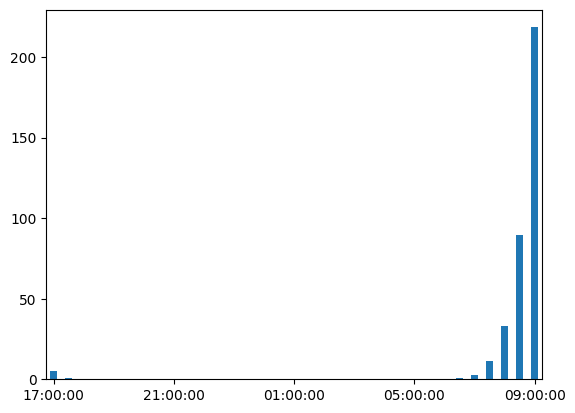

In [29]:
ocal = ocal.reset_index()
ocal.loc[:, 'jobs'] /= 10
ocal.time = pd.to_datetime(ocal.time).dt.time
ocal = ocal.groupby('time').jobs.sum()
ocall = pd.concat([ocal[34:48], ocal[0:19]])
ax = ocall.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/cal_o_periodic.png')

[Text(0.5, 0, '')]

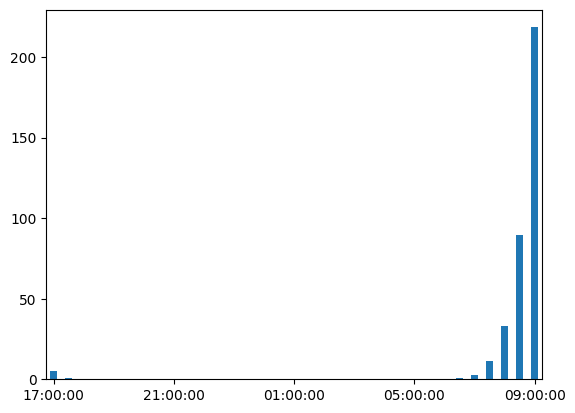

In [30]:
mcal = mcal.reset_index()
mcal.loc[:, 'jobs'] /= 10
mcal.time = pd.to_datetime(mcal.time).dt.time
mcal = mcal.groupby('time').jobs.sum()
mcall = pd.concat([mcal[34:48], mcal[0:19]])
ax = mcall.plot(kind='bar')
ax.set_xticks(ax.get_xticks()[::8])
plt.xticks(rotation=0)
ax.set(xlabel=None)
#plt.savefig('./Figures/cal_m_periodic.png')

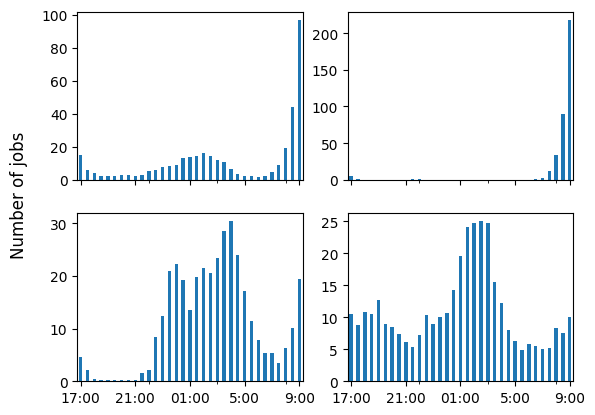

In [31]:
fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True)
labels=['17:00', '21:00', '01:00', '5:00', '9:00']

gax = ogerr.plot(ax=axes[0,0],kind='bar')
cax = ocall.plot(ax=axes[0,1],kind='bar')
bax = ogbb.plot(ax=axes[1,0],kind='bar')
fax = ofrr.plot(ax=axes[1,1],kind='bar')
gax.set_xticks(gax.get_xticks()[::8])
axes[1][1].tick_params(axis='x', rotation=0)
axes[1][0].tick_params(axis='x', rotation=0)
axes[1][1].set_xticklabels(labels)
axes[1][1].set(xlabel=None)
axes[1][0].set(xlabel=None)

fig.supylabel('Number of jobs')
plt.savefig('./Figures/o_periodic.png', dpi=300)
#plt.show()

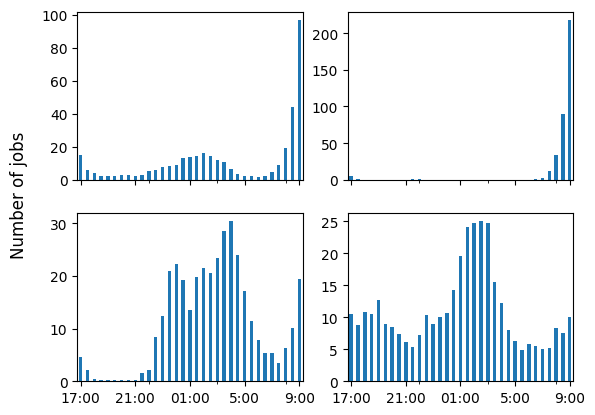

In [32]:
fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True)
labels=['17:00', '21:00', '01:00', '5:00', '9:00']

gax = mgerr.plot(ax=axes[0,0],kind='bar')
cax = mcall.plot(ax=axes[0,1],kind='bar')
bax = mgbb.plot(ax=axes[1,0],kind='bar')
fax = mfrr.plot(ax=axes[1,1],kind='bar')
gax.set_xticks(gax.get_xticks()[::8])
axes[1][1].tick_params(axis='x', rotation=0)
axes[1][0].tick_params(axis='x', rotation=0)
axes[1][1].set_xticklabels(labels)
axes[1][1].set(xlabel=None)
axes[1][0].set(xlabel=None)

fig.supylabel('Number of jobs')
plt.savefig('./Figures/m_periodic.png', dpi=300)

In [4]:
mbfr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_fr.csv', parse_dates=True).emissions.sum()
obfr = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_fr.csv', parse_dates=True).emissions.sum()
mbgb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_gb.csv', parse_dates=True).emissions.sum()
obgb = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_gb.csv', parse_dates=True).emissions.sum()
mbger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_ger.csv', parse_dates=True).emissions.sum()
obger = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_ger.csv', parse_dates=True).emissions.sum()
mbcal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal.csv', parse_dates=True).emissions.sum()
obcal = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_0_cal.csv', parse_dates=True).emissions.sum()
obcal

87403257.09550653

In [5]:
mdfr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_fr.csv', parse_dates=True).emissions.sum()
odfr = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_fr.csv', parse_dates=True).emissions.sum()
mdgb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_gb.csv', parse_dates=True).emissions.sum()
odgb = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_gb.csv', parse_dates=True).emissions.sum()
mdger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_ger.csv', parse_dates=True).emissions.sum()
odger = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_ger.csv', parse_dates=True).emissions.sum()
mdcal = pd.read_csv('output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_cal.csv', parse_dates=True).emissions.sum()
odcal = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_cal.csv', parse_dates=True).emissions.sum()
odcal

85257901.46445537

In [6]:
mdifr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_i_fr.csv', parse_dates=True).emissions.sum()
odifr = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_i_fr.csv', parse_dates=True).emissions.sum()
mdigb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_i_gb.csv', parse_dates=True).emissions.sum()
odigb = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_i_gb.csv', parse_dates=True).emissions.sum()
mdiger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_i_ger.csv', parse_dates=True).emissions.sum()
odiger = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_i_ger.csv', parse_dates=True).emissions.sum()
mdical = pd.read_csv('output/lets_wait_awhile/temporal/LWA/ml_next_workday_0.05_i_cal.csv', parse_dates=True).emissions.sum()
odical = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_next_workday_0.05_i_cal.csv', parse_dates=True).emissions.sum()
odical

82416884.18228078

In [7]:
mwfr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_fr.csv', parse_dates=True).emissions.sum()
owfr = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_fr.csv', parse_dates=True).emissions.sum()
mwgb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_gb.csv', parse_dates=True).emissions.sum()
owgb = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_gb.csv', parse_dates=True).emissions.sum()
mwger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_ger.csv', parse_dates=True).emissions.sum()
owger = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_ger.csv', parse_dates=True).emissions.sum()
mwcal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_cal.csv', parse_dates=True).emissions.sum()
owcal = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_cal.csv', parse_dates=True).emissions.sum()
owcal

82036754.22826952

In [8]:
mwifr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_i_fr.csv', parse_dates=True).emissions.sum()
owifr = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_i_fr.csv', parse_dates=True).emissions.sum()
mwigb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_i_gb.csv', parse_dates=True).emissions.sum()
owigb = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_i_gb.csv', parse_dates=True).emissions.sum()
mwiger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_i_ger.csv', parse_dates=True).emissions.sum()
owiger = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_i_ger.csv', parse_dates=True).emissions.sum()
mwical = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_semi_weekly_0.05_i_cal.csv', parse_dates=True).emissions.sum()
owical = pd.read_csv('./temp/full_lwa/lets-wait-awhile-master/results/ml_semi_weekly_0.05_i_cal.csv', parse_dates=True).emissions.sum()
owical

74881838.71713226

In [9]:
mllist = []

mllist.append([(obger - odger)/obger, 'Germany', 'Next Workday', 'Non-Interrupting'])
mllist.append([(obcal - odcal)/obcal, 'California', 'Next Workday', 'Non-Interrupting'])
mllist.append([(obgb - odgb)/obgb, 'Great Britain', 'Next Workday', 'Non-Interrupting'])
mllist.append([(obfr - odfr)/obfr, 'France', 'Next Workday', 'Non-Interrupting'])

mllist.append([(obger - odiger)/obger, 'Germany', 'Next Workday', 'Interrupting'])
mllist.append([(obcal - odical)/obcal, 'California', 'Next Workday', 'Interrupting'])
mllist.append([(obgb - odigb)/obgb, 'Great Britain', 'Next Workday', 'Interrupting'])
mllist.append([(obfr - odifr)/obfr, 'France', 'Next Workday', 'Interrupting'])

mllist.append([(obger - owger)/obger, 'Germany', 'Semi-Weekly', 'Non-Interrupting'])
mllist.append([(obcal - owcal)/obcal, 'California', 'Semi-Weekly', 'Non-Interrupting'])
mllist.append([(obgb - owgb)/obgb, 'Great Britain', 'Semi-Weekly', 'Non-Interrupting'])
mllist.append([(obfr - owfr)/obfr, 'France', 'Semi-Weekly', 'Non-Interrupting'])

mllist.append([(obger - owiger)/obger, 'Germany', 'Semi-Weekly', 'Interrupting'])
mllist.append([(obcal - owical)/obcal, 'California', 'Semi-Weekly', 'Interrupting'])
mllist.append([(obgb - owigb)/obgb, 'Great Britain', 'Semi-Weekly', 'Interrupting'])
mllist.append([(obfr - owifr)/obfr, 'France', 'Semi-Weekly', 'Interrupting'])

In [10]:
omllist = []
for x in range(len(mllist)):
    temp = []
    for elem in mllist[x]:
        temp.append(elem)
    omllist.append(temp)

omldf = pd.DataFrame(mllist, columns=['Percentage of emissions saved', 'Country', 'Scheduling_strategy', 'Interrupting'])
#omldf
omllist

[[0.059124477610451774, 'Germany', 'Next Workday', 'Non-Interrupting'],
 [0.02454548837587269, 'California', 'Next Workday', 'Non-Interrupting'],
 [0.0655623808787712, 'Great Britain', 'Next Workday', 'Non-Interrupting'],
 [0.047658631398748624, 'France', 'Next Workday', 'Non-Interrupting'],
 [0.07926401485848959, 'Germany', 'Next Workday', 'Interrupting'],
 [0.05705019559828404, 'California', 'Next Workday', 'Interrupting'],
 [0.09032073701860208, 'Great Britain', 'Next Workday', 'Interrupting'],
 [0.05921340616011367, 'France', 'Next Workday', 'Interrupting'],
 [0.14105060611519124, 'Germany', 'Semi-Weekly', 'Non-Interrupting'],
 [0.06139934649543984, 'California', 'Semi-Weekly', 'Non-Interrupting'],
 [0.1472620823505204, 'Great Britain', 'Semi-Weekly', 'Non-Interrupting'],
 [0.11115033576801032, 'France', 'Semi-Weekly', 'Non-Interrupting'],
 [0.18107015984226227, 'Germany', 'Semi-Weekly', 'Interrupting'],
 [0.14326031768692535, 'California', 'Semi-Weekly', 'Interrupting'],
 [0.19656

In [11]:
mllist = []

mllist.append([(mbger - mdger)/mbger, 'Germany', 'Next Workday', 'Non-Interrupting'])
mllist.append([(mbcal - mdcal)/mbcal, 'California', 'Next Workday', 'Non-Interrupting'])
mllist.append([(mbgb - mdgb)/mbgb, 'Great Britain', 'Next Workday', 'Non-Interrupting'])
mllist.append([(mbfr - mdfr)/mbfr, 'France', 'Next Workday', 'Non-Interrupting'])

mllist.append([(mbger - mdiger)/mbger, 'Germany', 'Next Workday', 'Interrupting'])
mllist.append([(mbcal - mdical)/mbcal, 'California', 'Next Workday', 'Interrupting'])
mllist.append([(mbgb - mdigb)/mbgb, 'Great Britain', 'Next Workday', 'Interrupting'])
mllist.append([(mbfr - mdifr)/mbfr, 'France', 'Next Workday', 'Interrupting'])

mllist.append([(mbger - mwger)/mbger, 'Germany', 'Semi-Weekly', 'Non-Interrupting'])
mllist.append([(mbcal - mwcal)/mbcal, 'California', 'Semi-Weekly', 'Non-Interrupting'])
mllist.append([(mbgb - mwgb)/mbgb, 'Great Britain', 'Semi-Weekly', 'Non-Interrupting'])
mllist.append([(mbfr - mwfr)/mbfr, 'France', 'Semi-Weekly', 'Non-Interrupting'])

mllist.append([(mbger - mwiger)/mbger, 'Germany', 'Semi-Weekly', 'Interrupting'])
mllist.append([(mbcal - mwical)/mbcal, 'California', 'Semi-Weekly', 'Interrupting'])
mllist.append([(mbgb - mwigb)/mbgb, 'Great Britain', 'Semi-Weekly', 'Interrupting'])
mllist.append([(mbfr - mwifr)/mbfr, 'France', 'Semi-Weekly', 'Interrupting'])

In [12]:
mmllist = []
for x in range(len(mllist)):
    temp = []
    for elem in mllist[x]:
        temp.append(elem)
    mmllist.append(temp)

mmldf = pd.DataFrame(mllist, columns=['Percentage of emissions saved', 'Country', 'Scheduling_strategy', 'Interrupting'])
mmldf

Percentage of emissions saved        Country Scheduling_strategy   
0                        0.059124        Germany        Next Workday  \
1                        0.024545     California        Next Workday   
2                        0.065562  Great Britain        Next Workday   
3                        0.047659         France        Next Workday   
4                        0.079264        Germany        Next Workday   
5                        0.057050     California        Next Workday   
6                        0.090321  Great Britain        Next Workday   
7                        0.059213         France        Next Workday   
8                        0.141051        Germany         Semi-Weekly   
9                        0.061399     California         Semi-Weekly   
10                       0.147262  Great Britain         Semi-Weekly   
11                       0.111150         France         Semi-Weekly   
12                       0.181070        Germany         Semi-Weekly   
13                       0.143260     California         Semi-Weekly   
14                       0.196562  Great Britain         Semi-Weekly   
15                       0.133258         France         Semi-Weekly   

        Interrupting  
0   Non-Interrupting  
1   Non-Interrupting  
2   Non-Interrupting  
3   Non-Interrupting  
4       Interrupting  
5       Interrupting  
6       Interrupting  
7       Interrupting  
8   Non-Interrupting  
9   Non-Interrupting  
10  Non-Interrupting  
11  Non-Interrupting  
12      Interrupting  
13      Interrupting  
14      Interrupting  
15      Interrupting

In [13]:
mmllist

[[0.059124477610451774, 'Germany', 'Next Workday', 'Non-Interrupting'],
 [0.02454548837587269, 'California', 'Next Workday', 'Non-Interrupting'],
 [0.0655623808787712, 'Great Britain', 'Next Workday', 'Non-Interrupting'],
 [0.047658631398748624, 'France', 'Next Workday', 'Non-Interrupting'],
 [0.07926401485848959, 'Germany', 'Next Workday', 'Interrupting'],
 [0.05705019559828404, 'California', 'Next Workday', 'Interrupting'],
 [0.09032073701860208, 'Great Britain', 'Next Workday', 'Interrupting'],
 [0.05921340616011367, 'France', 'Next Workday', 'Interrupting'],
 [0.14105060611519124, 'Germany', 'Semi-Weekly', 'Non-Interrupting'],
 [0.06139934649543967, 'California', 'Semi-Weekly', 'Non-Interrupting'],
 [0.1472620823505204, 'Great Britain', 'Semi-Weekly', 'Non-Interrupting'],
 [0.11115033576801032, 'France', 'Semi-Weekly', 'Non-Interrupting'],
 [0.18107015984226227, 'Germany', 'Semi-Weekly', 'Interrupting'],
 [0.14326031768692535, 'California', 'Semi-Weekly', 'Interrupting'],
 [0.19656

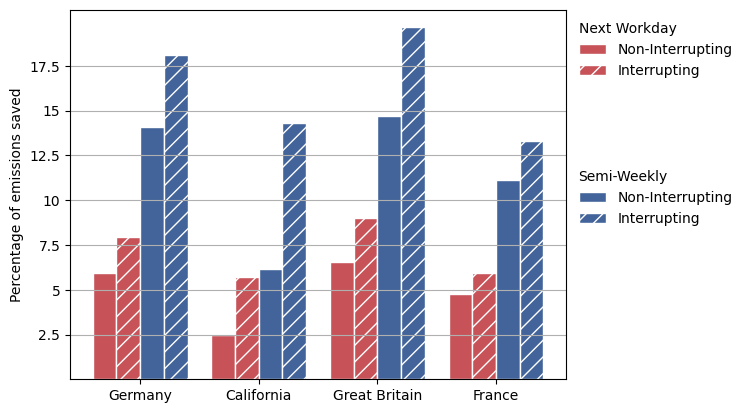

In [19]:
barWidth = 0.2
bardata = np.zeros((4,4))

# set heights of bars
nextw = [mmllist[0][0]*100, mmllist[1][0]*100, mmllist[2][0]*100, mmllist[3][0]*100]
nextw_i = [mmllist[4][0]*100, mmllist[5][0]*100, mmllist[6][0]*100, mmllist[7][0]*100]
nextmt = [mmllist[8][0]*100, mmllist[9][0]*100, mmllist[10][0]*100, mmllist[11][0]*100]
nextmt_i = [mmllist[12][0]*100, mmllist[13][0]*100, mmllist[14][0]*100, mmllist[15][0]*100]

# Set position of bar on X axis
r1 = np.arange(len(bardata))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, nextw, color='#C75359', width=barWidth, edgecolor='white', label='Non-Interrupting')
plt.bar(r2, nextw_i, color='#C75359', width=barWidth, edgecolor='white', hatch="//", label='Interrupting')
plt.bar(r3, nextmt, color='#42649A', width=barWidth, edgecolor='white', label='Non-Interrupting')
plt.bar(r4, nextmt_i, color='#42649A', width=barWidth, edgecolor='white', hatch="//", label='Interrupting')
 
# Add xticks on the middle of the group bars
#plt.xlabel('group', fontweight='bold')
plt.xticks([r + 1.5*barWidth for r in range(len(bardata))], ['Germany', 'California', 'Great Britain', 'France'])
plt.ylabel("Percentage of emissions saved")

plt.yticks([2.5, 5, 7.5, 10, 12.5, 15, 17.5], ["2.5", "5", "7.5", "10", "12.5", "15", "17.5"])
#plt.yticks([2.5], [""], minor=True)
 
# Create legend & Show graphic
#plt.legend(loc='upper left', bbox_to_anchor=(0, 1.35), frameon=False)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#leg1 = plt.legend(handles=handles[:2], labels=labels[:2], title="Next Workday", loc='upper right', bbox_to_anchor=(1.39, 1), frameon=False)
leg1 = plt.legend(handles=handles[:2], labels=labels[:2], title="Next Workday", loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
leg1._legend_box.align = "left"
#leg2 = plt.legend(handles=handles[2:], labels=labels[2:], title="Next Mon/Thu", loc='upper right', bbox_to_anchor=(1.39, 0.75), frameon=False)
leg2 = plt.legend(handles=handles[2:], labels=labels[2:], title="Semi-Weekly", loc='upper left', bbox_to_anchor=(1, 0.6), frameon=False)
leg2._legend_box.align = "left"
ax.add_artist(leg1)
ax.grid(axis='y')

fig = plt.gcf()
plt.savefig('./Figures/m_ml.png', dpi=300, bbox_inches='tight')

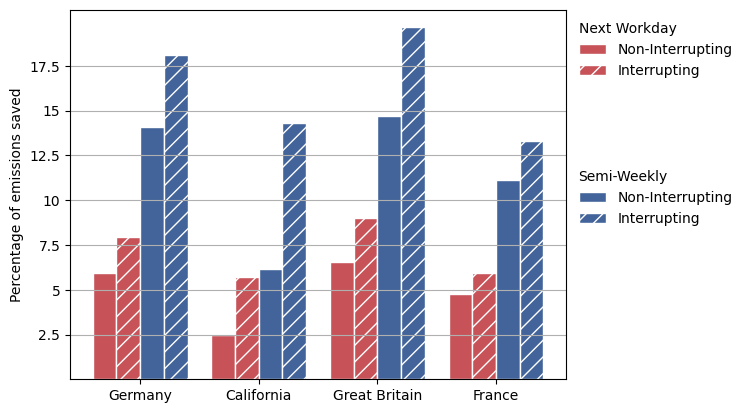

In [33]:
barWidth = 0.2
bardata = np.zeros((4,4))

# set heights of bars
nextw = [omllist[0][0]*100, omllist[1][0]*100, omllist[2][0]*100, omllist[3][0]*100]
nextw_i = [omllist[4][0]*100, omllist[5][0]*100, omllist[6][0]*100, omllist[7][0]*100]
nextmt = [omllist[8][0]*100, omllist[9][0]*100, omllist[10][0]*100, omllist[11][0]*100]
nextmt_i = [omllist[12][0]*100, omllist[13][0]*100, omllist[14][0]*100, omllist[15][0]*100]

# Set position of bar on X axis
r1 = np.arange(len(bardata))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]
r4 = [x + barWidth for x in r3]

# Make the plot
plt.bar(r1, nextw, color='#C75359', width=barWidth, edgecolor='white', label='Non-Interrupting')
plt.bar(r2, nextw_i, color='#C75359', width=barWidth, edgecolor='white', hatch="//", label='Interrupting')
plt.bar(r3, nextmt, color='#42649A', width=barWidth, edgecolor='white', label='Non-Interrupting')
plt.bar(r4, nextmt_i, color='#42649A', width=barWidth, edgecolor='white', hatch="//", label='Interrupting')
 
# Add xticks on the middle of the group bars
#plt.xlabel('group', fontweight='bold')
plt.xticks([r + 1.5*barWidth for r in range(len(bardata))], ['Germany', 'California', 'Great Britain', 'France'])
plt.ylabel("Percentage of emissions saved")

plt.yticks([2.5, 5, 7.5, 10, 12.5, 15, 17.5], ["2.5", "5", "7.5", "10", "12.5", "15", "17.5"])
#plt.yticks([2.5], [""], minor=True)
 
# Create legend & Show graphic
#plt.legend(loc='upper left', bbox_to_anchor=(0, 1.35), frameon=False)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#leg1 = plt.legend(handles=handles[:2], labels=labels[:2], title="Next Workday", loc='upper right', bbox_to_anchor=(1.39, 1), frameon=False)
leg1 = plt.legend(handles=handles[:2], labels=labels[:2], title="Next Workday", loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
leg1._legend_box.align = "left"
#leg2 = plt.legend(handles=handles[2:], labels=labels[2:], title="Next Mon/Thu", loc='upper right', bbox_to_anchor=(1.39, 0.75), frameon=False)
leg2 = plt.legend(handles=handles[2:], labels=labels[2:], title="Semi-Weekly", loc='upper left', bbox_to_anchor=(1, 0.6), frameon=False)
leg2._legend_box.align = "left"
ax.add_artist(leg1)
ax.grid(axis='y')

fig = plt.gcf()
plt.savefig('./Figures/o_ml.png', dpi=300, bbox_inches='tight')

In [15]:
ave = pd.read_csv('./output/lets_wait_awhile/temporal/average/periodic_demo_2.csv')
mar = pd.read_csv('./output/lets_wait_awhile/temporal/marginal/periodic_demo_2.csv')
lwa = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/periodic_demo_2.csv')

mar

FR  US-CAL-CISO          DE          GB
0   239.302738   392.080729  518.421790  417.165566
1   236.525146   392.079994  513.935591  414.950329
2   232.853143   390.995128  508.841260  412.406135
3   227.206592   390.995128  504.030635  409.327623
4   221.940710   390.995128  497.754796  406.401768
5   214.133829   390.995128  494.055324  404.355384
6   206.801303   390.995128  490.056298  401.817782
7   204.276757   390.995128  486.450043  400.110868
8   203.653626   390.995128  484.474170  398.970335
9   203.255137   390.971030  483.930099  397.548144
10  202.701447   389.647694  483.839183  394.933099
11  202.222411   385.227832  483.807937  390.862127
12  202.048338   382.667262  483.797073  387.319848
13  201.857019   381.944724  483.797073  384.232630
14  201.770832   381.849134  483.684023  381.792916
15  201.696273   381.814740  483.567155  380.611610
16  201.582917   381.798191  483.365426  379.711449

In [16]:
demo1_copy = ave.copy(deep=True)

demo1_copy = demo1_copy.rename(columns={"FR": "France Average.", "US-CAL-CISO":"California Average.", "DE":"Germany Average.", "GB":"United Kingdom Average"})
demo1_copy['France Marginal'] = mar.FR
demo1_copy['California Marginal'] = mar['US-CAL-CISO']
demo1_copy['Germany Marginal'] = mar.DE
demo1_copy['United Kingdom Marginal'] = mar.GB
demo1_copy['France LWA'] = lwa.fr
demo1_copy['Cal LWA'] = lwa.cal
demo1_copy['Ger LWA'] = lwa.ger
demo1_copy['GB LWA'] = lwa.gb
#print(demo1_copy)

#ax = demo1_copy.plot(style=['b-','m-','g-', 'r-', 'b--','m--','g--', 'r--'])
#    #color = ['blue', 'orange', 'grey', 'red', 'blue', 'orange', 'grey', 'red'], linestyle = ['-', '-', '-', '-', '--', '--', '--', '--'])
#ax.legend(bbox_to_anchor=(1, 1))
#ax.set_xlabel("Distribution Window (hours)")
#ax.set_ylabel("Carbon Emissions (gCO₂eq/kWh)")

In [17]:
demo1_copy

France Average.  California Average.  Germany Average.   
0         47.341863           277.301616        408.805178  \
1         46.799397           244.920740        405.799918   
2         46.104438           209.835562        402.963808   
3         45.863562           190.957151        401.505096   
4         45.554000           184.588822        400.545781   
5         45.318740           182.114219        399.130192   
6         45.141397           180.889945        397.805205   
7         45.051397           180.052521        395.812164   
8         44.569973           179.502877        390.865973   
9         43.142027           179.302986        379.051370   
10        41.288795           179.288658        355.838548   
11        40.123671           179.288658        330.024411   
12        39.685342           179.288658        312.371589   
13        39.472658           179.288658        302.479918   
14        39.393781           179.288658        298.554521   
15        39.351589           179.288658        297.380274   
16        39.300274           179.288658        297.157068   

    United Kingdom Average  France Marginal  California Marginal   
0               180.968466       239.302738           392.080729  \
1               179.035178       236.525146           392.079994   
2               176.092055       232.853143           390.995128   
3               174.487452       227.206592           390.995128   
4               173.810959       221.940710           390.995128   
5               173.448959       214.133829           390.995128   
6               172.966274       206.801303           390.995128   
7               172.260849       204.276757           390.995128   
8               170.849014       203.653626           390.995128   
9               168.064027       203.255137           390.971030   
10              162.124767       202.701447           389.647694   
11              155.026164       202.222411           385.227832   
12              150.532274       202.048338           382.667262   
13              148.585397       201.857019           381.944724   
14              147.706767       201.770832           381.849134   
15              147.124110       201.696273           381.814740   
16              146.864959       201.582917           381.798191   

    Germany Marginal  United Kingdom Marginal  France LWA     Cal LWA   
0         518.421790               417.165566   52.121063  320.330642  \
1         513.935591               414.950329   51.648688  318.834123   
2         508.841260               412.406135   51.057760  316.694079   
3         504.030635               409.327623   50.791735  316.189993   
4         497.754796               406.401768   50.488509  315.411815   
5         494.055324               404.355384   50.179459  314.799335   
6         490.056298               401.817782   49.847274  314.298177   
7         486.450043               400.110868   49.718390  311.032658   
8         484.474170               398.970335   49.569305  290.654276   
9         483.930099               397.548144   49.295239  256.419135   
10        483.839183               394.933099   49.002753  224.273674   
11        483.807937               390.862127   48.741404  208.889917   
12        483.797073               387.319848   48.583405  200.785231   
13        483.797073               384.232630   48.482645  195.628278   
14        483.684023               381.792916   48.453961  192.026883   
15        483.567155               380.611610   48.436557  189.644028   
16        483.365426               379.711449   48.373600  188.860637   

       Ger LWA      GB LWA  
0   305.328013  184.095932  
1   303.621421  179.748863  
2   301.561911  178.255722  
3   300.816687  178.223082  
4   300.261705  178.200913  
5   299.351629  178.162291  
6   298.756115  178.141637  
7   297.376395  177.950976  
8   293.756334  177.425217  
9   285.197568  175.434031  
10  273.191943  171.580019  

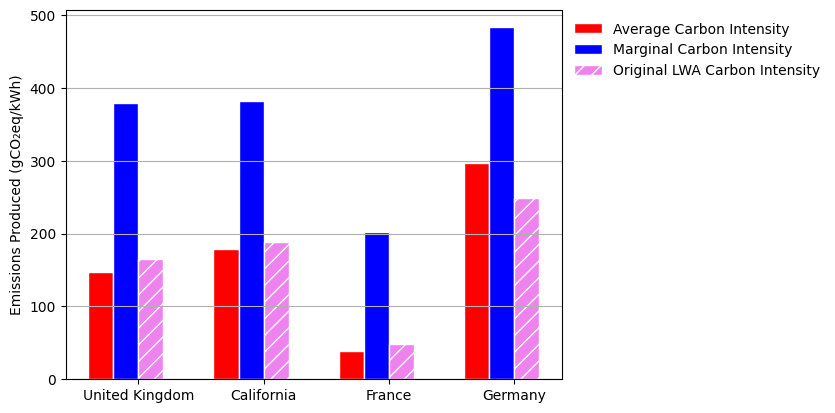

In [21]:
barWidth = 0.2
bardata = np.zeros((4,3))

# set heights of bars
thir = [demo1_copy.iloc[16][3], demo1_copy.iloc[16][1], demo1_copy.iloc[16][0], demo1_copy.iloc[16][2]]
sixt = [demo1_copy.iloc[16][7], demo1_copy.iloc[16][5], demo1_copy.iloc[16][4], demo1_copy.iloc[16][6]]
nint = [demo1_copy.iloc[16][11], demo1_copy.iloc[16][9], demo1_copy.iloc[16][8], demo1_copy.iloc[16][10]]

# Set position of bar on X axis
r1 = np.arange(len(bardata))
r2 = [x + barWidth for x in r1]
r3 = [x + barWidth for x in r2]

# Make the plot
plt.bar(r1, thir, color='red', width=barWidth, edgecolor='white', label='Average Carbon Intensity')
plt.bar(r2, sixt, color='blue', width=barWidth, edgecolor='white', label='Marginal Carbon Intensity')
plt.bar(r3, nint, color='violet', width=barWidth, edgecolor='white', hatch="//", label='Original LWA Carbon Intensity')

# Add xticks on the middle of the group bars
plt.xticks([r + 1.5*barWidth for r in range(len(bardata))], ['United Kingdom', 'California', 'France', 'Germany'])
plt.ylabel("Emissions Produced (gCO₂eq/kWh)")

# Create legend & Show graphic
#plt.legend(loc='upper left', bbox_to_anchor=(0, 1.35), frameon=False)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#leg1 = plt.legend(handles=handles[:2], labels=labels[:2], title="Next Workday", loc='upper right', bbox_to_anchor=(1.39, 1), frameon=False)
leg1 = plt.legend(handles=handles[:3], labels=labels[:3], loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
leg1._legend_box.align = "left"
ax.grid(axis='y')
plt.savefig('./Figures/demo1all.png', dpi=300, bbox_inches='tight')

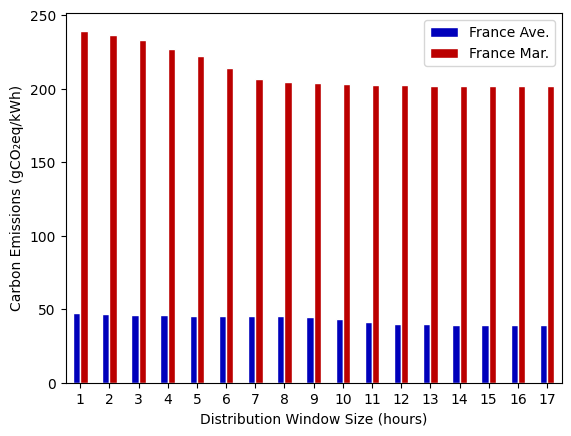

In [47]:
ax = demo1_copy[['France Ave.', 'France Mar.']].plot(kind='bar',color = ['#0000BB', '#BB0000'], edgecolor='white')
labels=['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17']
plt.legend(bbox_to_anchor=(1, 1))
ax.set_xticklabels(labels)
plt.xticks(rotation=0)
ax.set_xlabel("Distribution Window Size (hours)")
ax.set_ylabel("Carbon Emissions (gCO₂eq/kWh)")
plt.savefig('./Figures/dem01_FR.png', dpi=300, bbox_inches='tight')

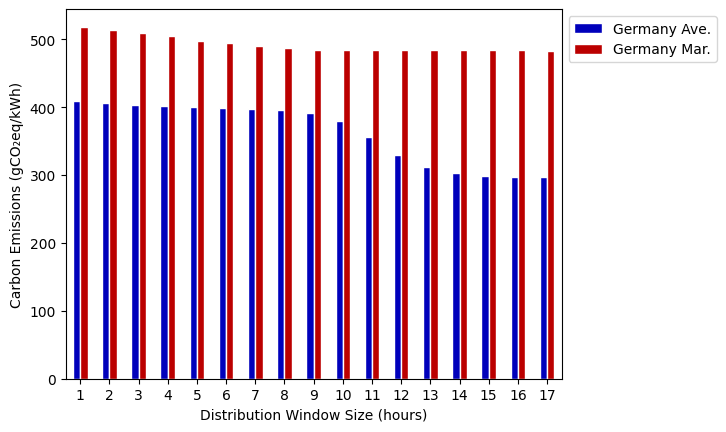

In [46]:
ax = demo1_copy[['Germany Ave.', 'Germany Mar.']].plot(kind='bar',color = ['#0000BB', '#BB0000'], edgecolor='white')
#labels=['17:00', '21:00', '01:00', '05:00', '09:00']
labels=['1', '2', '3','4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17']
plt.legend(bbox_to_anchor=(1, 1))
#ax.set_xticks(ax.get_xticks()[::4])
ax.set_xticklabels(labels)
plt.xticks(rotation=0)
ax.set_xlabel("Distribution Window Size (hours)")
ax.set_ylabel("Carbon Emissions (gCO₂eq/kWh)")
plt.savefig('./Figures/dem01_DE.png', dpi=300, bbox_inches='tight')

In [58]:
ori = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/periodic_demo_2_i30.csv')
exp = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/periodic_demo_2_i60.csv')

exp

gb         cal         fr         ger
0  184.095932  320.330642  52.121063  305.328013
1  179.748863  318.834123  51.648688  303.621421
2  178.255722  316.694079  51.057760  301.561911
3  178.223082  316.189993  50.791735  300.816687
4  178.200913  315.411815  50.488509  300.261705
5  178.162291  314.799335  50.179459  299.351629
6  178.141637  314.298177  49.847274  298.756115
7  177.950976  311.032658  49.718390  297.376395

In [59]:
ori

gb         cal         fr         ger
0   184.095932  320.330642  52.121063  305.328013
1   178.451748  318.444620  51.269907  302.587470
2   175.382620  316.778680  50.601589  300.162464
3   172.942747  314.799686  49.989616  297.839101
4   171.555282  313.723417  49.658729  296.785479
5   170.275107  313.110646  49.426317  295.948325
6   169.282330  312.678087  49.270251  295.132964
7   168.627764  312.165590  49.108216  294.359465
8   168.240503  311.586208  48.949132  293.216993
9   168.033356  309.776301  48.818774  291.604214
10  167.769671  302.248260  48.688577  289.256849
11  167.553393  290.119100  48.570897  286.289591
12  167.314708  272.945670  48.407383  282.360102
13  167.000034  254.588743  48.304555  278.281699
14  166.622498  234.295186  48.220485  273.180309
15  166.071678  219.562662  48.145701  268.453855
16  164.924411  208.788624  48.060360  263.309199

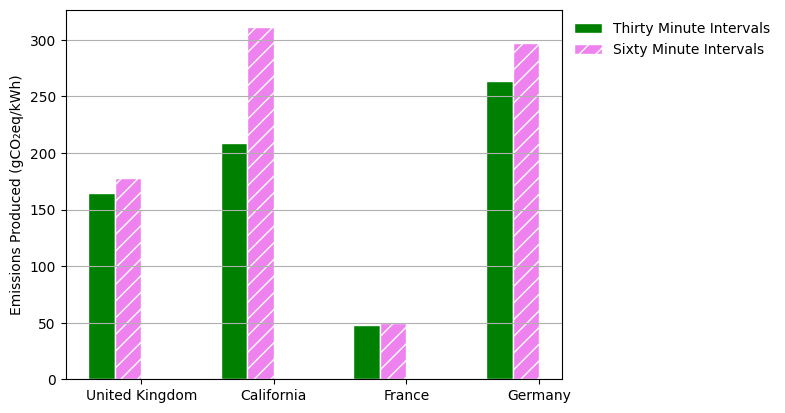

In [60]:
barWidth = 0.2
bardata = np.zeros((4,2))

# set heights of bars
thir = [ori.iloc[16][0], ori.iloc[16][1], ori.iloc[16][2], ori.iloc[16][3]]
sixt = [exp.iloc[7][0], exp.iloc[7][1], exp.iloc[7][2], exp.iloc[7][3]]

# Set position of bar on X axis
r1 = np.arange(len(bardata))
r2 = [x + barWidth for x in r1]

# Make the plot
plt.bar(r1, thir, color='green', width=barWidth, edgecolor='white', label='Thirty Minute Intervals')
plt.bar(r2, sixt, color='violet', width=barWidth, edgecolor='white', hatch="//", label='Sixty Minute Intervals')

# Add xticks on the middle of the group bars
plt.xticks([r + 1.5*barWidth for r in range(len(bardata))], ['United Kingdom', 'California', 'France', 'Germany'])
plt.ylabel("Emissions Produced (gCO₂eq/kWh)")

# Create legend & Show graphic
#plt.legend(loc='upper left', bbox_to_anchor=(0, 1.35), frameon=False)
ax = plt.gca()
handles, labels = ax.get_legend_handles_labels()
#leg1 = plt.legend(handles=handles[:2], labels=labels[:2], title="Next Workday", loc='upper right', bbox_to_anchor=(1.39, 1), frameon=False)
leg1 = plt.legend(handles=handles[:2], labels=labels[:2], loc='upper left', bbox_to_anchor=(1, 1), frameon=False)
leg1._legend_box.align = "left"
ax.grid(axis='y')
plt.savefig('./Figures/dem02.png', dpi=300, bbox_inches='tight')

In [22]:
half_cal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal__half.csv')
full_cal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal__full.csv')
print(half_cal.emissions.sum())
half_cal

79016250.1193684


datetime  active_jobs          ci  emissions
0      2020-01-01 00:00:00          0.0  342.092256        0.0
1      2020-01-01 00:30:00          0.0  347.220539        0.0
2      2020-01-01 01:00:00          0.0  344.967632        0.0
3      2020-01-01 01:30:00          0.0  339.952418        0.0
4      2020-01-01 02:00:00          0.0  336.563101        0.0
...                    ...          ...         ...        ...
10171  2020-07-30 21:30:00          0.0  354.340815        0.0
10172  2020-07-30 22:00:00          0.0  350.616392        0.0
10173  2020-07-30 22:30:00          0.0  346.637414        0.0
10174  2020-07-30 23:00:00          0.0  342.540687        0.0
10175  2020-07-30 23:30:00          0.0  343.415217        0.0

[10176 rows x 4 columns]

In [63]:
print(full_cal.emissions.sum())
full_cal

85956501.62962836


datetime  active_jobs          ci  emissions
0      2020-01-01 00:00:00          0.0  342.092256        0.0
1      2020-01-01 00:30:00          0.0  347.220539        0.0
2      2020-01-01 01:00:00          0.0  344.967632        0.0
3      2020-01-01 01:30:00          0.0  339.952418        0.0
4      2020-01-01 02:00:00          0.0  336.563101        0.0
...                    ...          ...         ...        ...
17515  2020-12-30 21:30:00          0.0  373.994590        0.0
17516  2020-12-30 22:00:00          0.0  370.034744        0.0
17517  2020-12-30 22:30:00          0.0  364.593252        0.0
17518  2020-12-30 23:00:00          0.0  361.169401        0.0
17519  2020-12-30 23:30:00          0.0  362.117060        0.0

[17520 rows x 4 columns]

In [23]:
demo_a_1 = full_cal[['datetime','emissions']]
demo_a_1 = demo_a_1.rename(columns={'emissions' : 'January-November Emissions'})
demo_a_1['January-June Emissions'] = half_cal.emissions
demo_a_1

datetime  January-November Emissions  January-June Emissions
0      2020-01-01 00:00:00                         0.0                     0.0
1      2020-01-01 00:30:00                         0.0                     0.0
2      2020-01-01 01:00:00                         0.0                     0.0
3      2020-01-01 01:30:00                         0.0                     0.0
4      2020-01-01 02:00:00                         0.0                     0.0
...                    ...                         ...                     ...
17515  2020-12-30 21:30:00                         0.0                     NaN
17516  2020-12-30 22:00:00                         0.0                     NaN
17517  2020-12-30 22:30:00                         0.0                     NaN
17518  2020-12-30 23:00:00                         0.0                     NaN
17519  2020-12-30 23:30:00                         0.0                     NaN

[17520 rows x 3 columns]

/tmp/ipykernel_644/2146344861.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(temp.index.date)


[437560. 439021. 440482. 441943. 443404. 444865. 446326. 447787.]


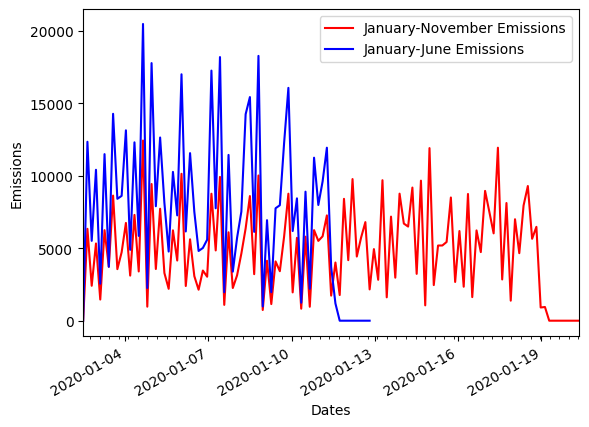

In [27]:
#demo_a_1['datetime'] = pd.to_datetime(demo_a_1['datetime'])
temp = demo_a_1[::150].set_index('datetime')
ax = temp.plot(color = ['red', 'blue'])#kind='bar', 
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.set_xticklabels(temp.index.date)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
xticks = ax.get_xticks()
print(xticks)
ax.set_xlabel("Dates")
ax.set_ylabel("Emissions")

plt.savefig('./Figures/demo3_cal.png', dpi=300, bbox_inches='tight')

In [29]:
print(full_gb.active_jobs.sum())
print(half_gb.active_jobs.sum())
print(full_gb.emissions.sum())
print(half_gb.emissions.sum())

311017.0
309318.0
66655812.66209933
63990358.31821209


In [3]:
demo_a_1 = full_gb[['datetime','active_jobs']]
demo_a_1 = demo_a_1.rename(columns={'active_jobs' : 'January-November Workload'})
demo_a_1['January-June Workload'] = half_gb.active_jobs
demo_a_1

datetime  January-November Workload  January-June Workload
0      2020-01-01 00:00:00                        0.0                    0.0
1      2020-01-01 00:30:00                        0.0                    0.0
2      2020-01-01 01:00:00                        0.0                    0.0
3      2020-01-01 01:30:00                        0.0                    0.0
4      2020-01-01 02:00:00                        0.0                    0.0
...                    ...                        ...                    ...
17515  2020-12-30 21:30:00                        0.0                    NaN
17516  2020-12-30 22:00:00                        0.0                    NaN
17517  2020-12-30 22:30:00                        0.0                    NaN
17518  2020-12-30 23:00:00                        0.0                    NaN
17519  2020-12-30 23:30:00                        0.0                    NaN

[17520 rows x 3 columns]

[  500.  2500.  4500.  6500.  8500. 10500. 12500. 14500. 16500. 18500.
 20500. 22500.]


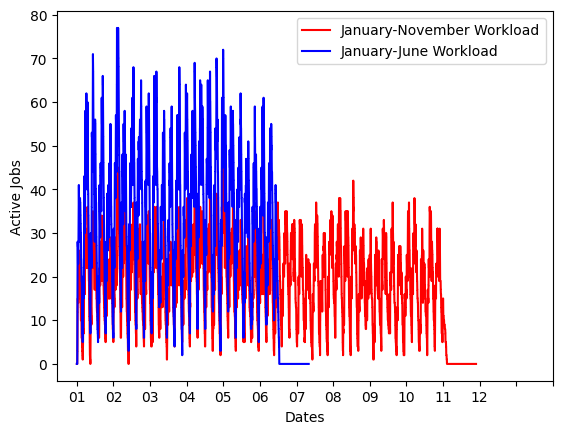

In [79]:
ax = demo_a_1.plot(color = ['red', 'blue'])#.set_index('datetime')
plt.locator_params(axis='x', nbins=12)
#labels=['01-01', '02-15', '04-01', '05-15', '07-01', '08-15', '10-01', '11-15', '12-30']
labels=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '', '']
xticks = ax.get_xticks()+2500
print(xticks)
last = xticks[-1]
#labels = ['01-01', '01-05', '01-09', '01-13', '01-17', '01-21', '01-25', '01-29', '02-02', '02-06']
ax.set_xticks([last*x/14 for x in range(14)])
ax.set_xticklabels(labels)
ax.set_xlabel("Dates")
ax.set_ylabel("Active Jobs")
plt.savefig('./Figures/demo3_GB.png', dpi=300, bbox_inches='tight')

[  0.  14.  31.  45.  59.  73.  90. 104.]


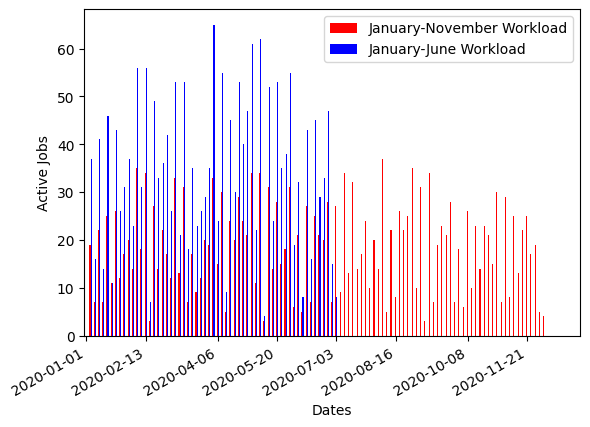

In [28]:
#demo_a_1['datetime'] = pd.to_datetime(demo_a_1['datetime'])
temp = demo_a_1[::150].set_index('datetime')
ax = temp.plot(kind='bar', color = ['red', 'blue'])
#plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y/%m/%d'))
ax.set_xticklabels(temp.index.date)
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
xticks = ax.get_xticks()
print(xticks)
ax.set_xlabel("Dates")
ax.set_ylabel("Active Jobs")

plt.savefig('./Figures/demo3_GB.png', dpi=300, bbox_inches='tight')

In [12]:
cstr = 'LWA'
full_carbon_string = f'./Data/post_processing/{cstr}_ci.csv'
ci_df = pd.read_csv(full_carbon_string, parse_dates=True)
ci_df['datetime'] = pd.to_datetime(ci_df['datetime'], format='%Y-%m-%d %H:%M:%S')
ci_df = ci_df.set_index(['datetime'])

origin = datetime.strptime("2020-01-01 00:00:00", '%Y-%m-%d %H:%M:%S')
ci_df

gb         cal         fr         ger
datetime                                                          
2019-12-20 00:00:00  120.995467  349.734382  42.341238  218.290031
2019-12-20 00:30:00  135.088696  347.238271  42.101656  217.494426
2019-12-20 01:00:00  141.357058  346.218074  41.997517  216.761357
2019-12-20 01:30:00  144.691745  346.432492  42.016643  215.191938
2019-12-20 02:00:00  141.128537  342.529566  42.146853  212.392223
...                         ...         ...        ...         ...
2021-01-10 21:30:00         NaN  390.124062        NaN         NaN
2021-01-10 22:00:00         NaN  391.747776        NaN         NaN
2021-01-10 22:30:00         NaN  393.676494        NaN         NaN
2021-01-10 23:00:00         NaN  392.328518        NaN         NaN
2021-01-10 23:30:00         NaN  390.621541        NaN         NaN

[18624 rows x 4 columns]

In [18]:
first = ci_df.loc[origin:end_dates[0]]
print(first.cal.mean())
first

253.60233287404782


gb         cal         fr         ger
datetime                                                          
2020-01-01 00:00:00  192.229224  342.092256  56.033471  353.319875
2020-01-01 00:30:00  194.251856  347.220539  52.740640  351.252335
2020-01-01 01:00:00  195.211861  344.967632  48.375163  349.628409
2020-01-01 01:30:00  190.238991  339.952418  43.531716  346.373119
2020-01-01 02:00:00  186.122673  336.563101  40.306003  347.674818
...                         ...         ...        ...         ...
2020-06-30 21:30:00  282.051802  307.396972  74.210335  289.363439
2020-06-30 22:00:00  270.108057  304.205774  69.552614  283.360872
2020-06-30 22:30:00  252.702130  304.389193  67.919923  280.835087
2020-06-30 23:00:00  236.224322  297.200847  67.720336  271.575119
2020-06-30 23:30:00  228.468723  294.023054  66.657512  268.296336

[8736 rows x 4 columns]

In [19]:
second = ci_df.loc[end_dates[0]:end_dates[1]+timedelta(days=31)]
print(second.cal.mean())
second

305.51533823062965


gb         cal         fr         ger
datetime                                                          
2020-06-30 23:30:00  228.468723  294.023054  66.657512  268.296336
2020-07-01 00:00:00  227.117873  289.566560  64.953042  268.252520
2020-07-01 00:30:00  219.188014  287.983749  63.307024  263.570734
2020-07-01 01:00:00  206.405796  284.959469  61.815687  272.163839
2020-07-01 01:30:00  198.432685  288.558677  60.471576  279.544745
...                         ...         ...        ...         ...
2020-12-31 21:30:00  252.261330  377.973888  67.316307  425.025554
2020-12-31 22:00:00  251.141608  376.835143  69.073480  426.575116
2020-12-31 22:30:00  243.237501  374.563315  68.195328  426.077061
2020-12-31 23:00:00  233.778838  371.903162  65.697676  427.580284
2020-12-31 23:30:00  229.335018  368.503891  63.288589  426.458266

[8833 rows x 4 columns]

In [20]:
print(first.gb.mean())
print(second.gb.mean())
print(first.fr.mean())
print(second.fr.mean())
print(first.ger.mean())
print(second.ger.mean())

201.20661229095782
224.54924090658636
47.970246876602374
64.61193035358534
267.0105715605902
359.2545870865583


In [2]:
half_cal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal__half.csv')
full_cal = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal__full.csv')
half_gb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_gb__half.csv')
full_gb = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_gb__full.csv')
half_fr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_fr__half.csv')
full_fr = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_fr__full.csv')
half_ger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_ger__half.csv')
full_ger = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_ger__full.csv')
print(half_fr.emissions.sum())
print(full_fr.emissions.sum())
half_fr

14874164.79932859
17276212.437948443


datetime  active_jobs         ci  emissions
0      2020-01-01 00:00:00          0.0  56.033471        0.0
1      2020-01-01 00:30:00          0.0  52.740640        0.0
2      2020-01-01 01:00:00          0.0  48.375163        0.0
3      2020-01-01 01:30:00          0.0  43.531716        0.0
4      2020-01-01 02:00:00          0.0  40.306003        0.0
...                    ...          ...        ...        ...
10171  2020-07-30 21:30:00          0.0  71.304771        0.0
10172  2020-07-30 22:00:00          0.0  63.423905        0.0
10173  2020-07-30 22:30:00          0.0  63.146268        0.0
10174  2020-07-30 23:00:00          0.0  67.582736        0.0
10175  2020-07-30 23:30:00          0.0  72.073624        0.0

[10176 rows x 4 columns]

In [77]:
print(full_gb.emissions.sum())
print(half_gb.emissions.sum())

print(full_cal.emissions.sum())
print(half_cal.emissions.sum())

print(full_ger.emissions.sum())
print(half_ger.emissions.sum())

print(full_fr.emissions.sum())
print(half_fr.emissions.sum())

66655812.66209933
63990358.31821209
85956501.62962836
79016250.1193684
96847223.65182051
84258750.32661547
17276212.437948443
14874164.79932859


In [2]:
gerlwa = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_ger_demo4_LWA.csv')
callwa = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_cal_demo4_LWA.csv')
gblwa = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_gb_demo4_LWA.csv')
frlwa = pd.read_csv('./output/lets_wait_awhile/temporal/LWA/ml_0_fr_demo4_LWA.csv')
print(gerlwa.emissions.sum())
print(gerlwa.active_jobs.sum())
print(frlwa.emissions.sum())
print(frlwa.active_jobs.sum())
print(gblwa.emissions.sum())
print(gblwa.active_jobs.sum())
print(callwa.emissions.sum())
print(callwa.active_jobs.sum())

germar = pd.read_csv('./output/lets_wait_awhile/temporal/marginal/ml_0_DE_demo4_marginal.csv')
calmar = pd.read_csv('./output/lets_wait_awhile/temporal/marginal/ml_0_US-CAL-CISO_demo4_marginal.csv')
gbmar = pd.read_csv('./output/lets_wait_awhile/temporal/marginal/ml_0_GB_demo4_marginal.csv')
frmar = pd.read_csv('./output/lets_wait_awhile/temporal/marginal/ml_0_FR_demo4_marginal.csv')
print(germar.emissions.sum())
print(germar.active_jobs.sum())
print(frmar.emissions.sum())
print(frmar.active_jobs.sum())
print(gbmar.emissions.sum())
print(gbmar.active_jobs.sum())
print(calmar.emissions.sum())
print(calmar.active_jobs.sum())

gerwat = pd.read_csv('./output/lets_wait_awhile/temporal/watttime/ml_0_DE_demo4_watttime.csv')
calwat = pd.read_csv('./output/lets_wait_awhile/temporal/watttime/ml_0_US-CAL-CISO_demo4_watttime.csv')
gbwat = pd.read_csv('./output/lets_wait_awhile/temporal/watttime/ml_0_GB_demo4_watttime.csv')
frwat = pd.read_csv('./output/lets_wait_awhile/temporal/watttime/ml_0_FR_demo4_watttime.csv')
print(gerwat.emissions.sum())
print(gerwat.active_jobs.sum())
print(frwat.emissions.sum())
print(frwat.active_jobs.sum())
print(gbwat.emissions.sum())
print(gbwat.active_jobs.sum())
print(calwat.emissions.sum())
print(calwat.active_jobs.sum())

4808621.851426246
13555.0
895539.4900467175
13555.0
3246358.40054706
13555.0
3909995.860369264
13555.0
6778208.321957604
13555.0
2545752.9863565685
13555.0
5511787.446495609
13555.0
5678778.862951821
13555.0
10124854.281592
13555.0
5245420.895336
13555.0
6218378.003296
13555.0
5440689.076191999
13555.0


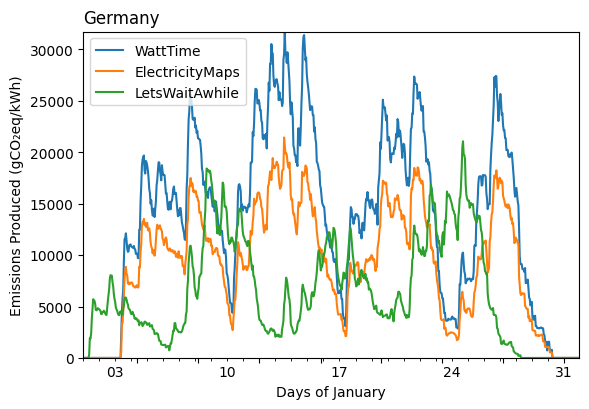

In [7]:
ger = gerwat[['datetime', 'emissions']]
ger = ger.rename(columns={'emissions' : 'WattTime'})
ger['ElectricityMaps'] = germar.emissions
ger['LetsWaitAwhile'] = gerlwa.emissions
ger['datetime'] = pd.to_datetime(ger['datetime'])
temp = ger.set_index('datetime')
ax = temp.plot()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
ax.set_xlabel("Days of January")
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
plt.margins(0)
plt.title("Germany", loc="left")
plt.savefig('./Figures/demo4de.png', dpi=300)

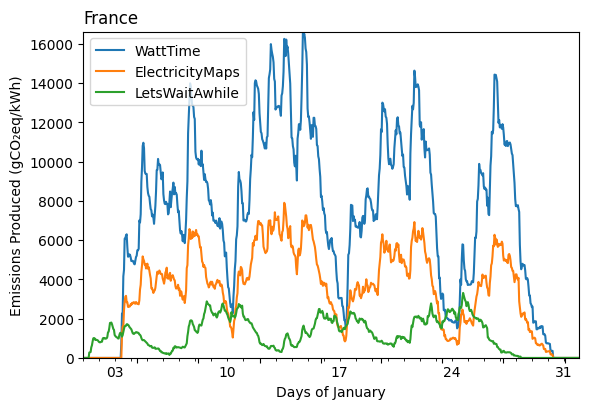

In [6]:
fr = frwat[['datetime', 'emissions']]
fr = fr.rename(columns={'emissions' : 'WattTime'})
fr['ElectricityMaps'] = frmar.emissions
fr['LetsWaitAwhile'] = frlwa.emissions
fr['datetime'] = pd.to_datetime(fr['datetime'])
temp = fr.set_index('datetime')
ax = temp.plot()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
ax.set_xlabel("Days of January")
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
plt.margins(0)
plt.title("France", loc="left")
plt.savefig('./Figures/demo4fr.png', dpi=300)

TypeError: tz must be string or tzinfo subclass.

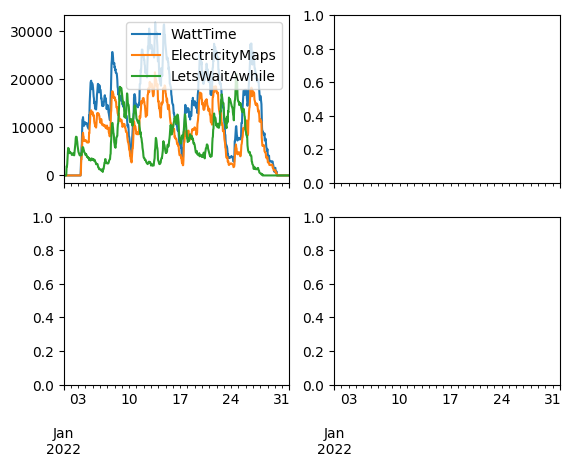

In [10]:
fr = frwat[['datetime', 'emissions']]
fr = fr.rename(columns={'emissions' : 'WattTime'})
fr['ElectricityMaps'] = frmar.emissions
fr['LetsWaitAwhile'] = frlwa.emissions

gb = gbwat[['datetime', 'emissions']]
gb = gb.rename(columns={'emissions' : 'WattTime'})
gb['ElectricityMaps'] = gbmar.emissions
gb['LetsWaitAwhile'] = gblwa.emissions

cal = calwat[['datetime', 'emissions']]
cal = cal.rename(columns={'emissions' : 'WattTime'})
cal['ElectricityMaps'] = calmar.emissions
cal['LetsWaitAwhile'] = callwa.emissions

fig, axes = plt.subplots(nrows=2, ncols=2,sharex=True)

gax = ger.set_index('datetime').plot(ax=axes[0,0])
cax = cal.set_index('datetime').plot(ax=axes[0,1])
bax = gb.set_index('datetime').plot(ax=axes[1,0])
fax = fr.set_index('datetime').plot(ax=axes[1,1])
xticks = gax.get_xticks()
print(xticks)
labels = ['01-01', '01-07', '01-13', '01-19', '01-25', '01-31']#, '01-25', '01-29', '02-02', '02-06']
gax.set_xticks(xticks+200)
gax.set_xticklabels(labels)
axes[1][1].tick_params(axis='x', rotation=0)
axes[1][0].tick_params(axis='x', rotation=0)
axes[1][1].set_xticklabels(labels)
#axes[1][1].set(xlabel=None)
fax.set_xlabel("Days of January")
#axes[1][0].set(xlabel=None)
bax.set_xlabel("Days of January")

plt.margins(0)
fig.supylabel("Emissions Produced (gCO₂eq/kWh)")
#plt.savefig('./Figures/demo4.png', dpi=300)

[-100.    0.  100.  200.  300.  400.  500.  600.  700.  800.]


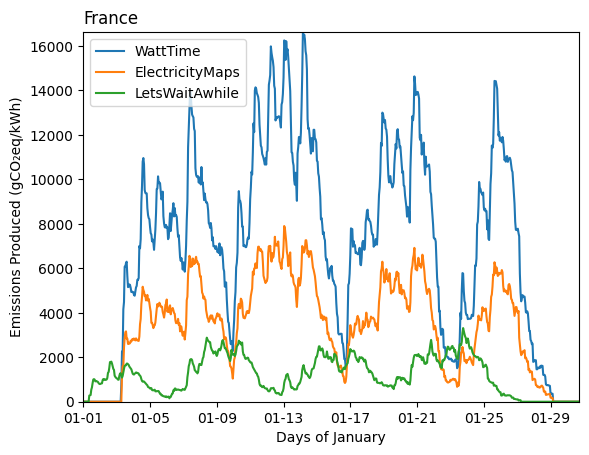

In [42]:
ax = fr.set_index('datetime').plot()
xticks = ax.get_xticks()
print(xticks)
labels = ['01-01', '01-05', '01-09', '01-13', '01-17', '01-21', '01-25', '01-29', '02-02', '02-06']
ax.set_xticks(xticks+100)
ax.set_xticklabels(labels)
ax.set_xlabel("Days of January")
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
plt.margins(0)
plt.title("France", loc="left")
#plt.savefig('./Figures/demo4fr.png', dpi=300)

In [47]:
print(fr.WattTime.sum())
print(fr.ElectricityMaps.sum())
print(fr.LetsWaitAwhile.sum())
print('\n')
print(ger.WattTime.sum())
print(ger.ElectricityMaps.sum())
print(ger.LetsWaitAwhile.sum())
print('\n')
print(gb.WattTime.sum())
print(gb.ElectricityMaps.sum())
print(gb.LetsWaitAwhile.sum())
print('\n')
print(cal.WattTime.sum())
print(cal.ElectricityMaps.sum())
print(cal.LetsWaitAwhile.sum())


5245420.895336
2545752.9863565685
895539.4900467175


10124854.281592
6778208.321957604
4808621.851426246


6218378.003296
5511787.446495609
3246358.40054706


5440689.076191999
5678778.862951821
3909995.860369264


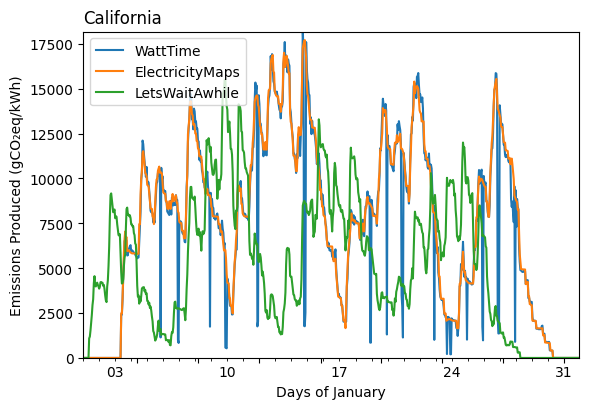

In [11]:
cal['datetime'] = pd.to_datetime(cal['datetime'])
temp = cal.set_index('datetime')
ax = temp.plot()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
ax.set_xlabel("Days of January")
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
plt.margins(0)
plt.title("California", loc="left")
plt.savefig('./Figures/demo4cal.png', dpi=300)

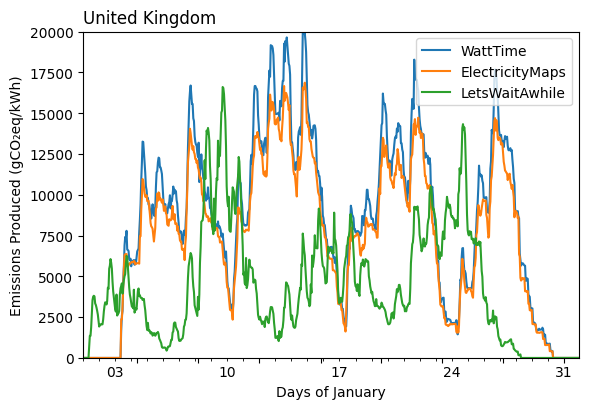

In [12]:
gb['datetime'] = pd.to_datetime(gb['datetime'])
temp = gb.set_index('datetime')
ax = temp.plot()
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
ax.set_xlabel("Days of January")
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
plt.margins(0)
plt.title("United Kingdom", loc="left")
plt.savefig('./Figures/demo4gb.png', dpi=300)

In [41]:
awsreq = pd.read_csv('./output/carbon_min/gen_AI/watttime/requests_AWS.csv')
awszon = pd.read_csv('./output/carbon_min/gen_AI/watttime/zones_used_AWS.csv', header=None)
#print(awsreq)
awsreq

datetime  requests     emissions
0    2022-01-01 00:00:00      2368  9.009867e+05
1    2022-01-01 01:00:00      2766  1.035439e+06
2    2022-01-01 02:00:00      3061  1.139188e+06
3    2022-01-01 03:00:00      3209  1.195533e+06
4    2022-01-01 04:00:00      3312  1.247660e+06
..                   ...       ...           ...
738  2022-01-31 18:00:00      2746  1.050083e+06
739  2022-01-31 19:00:00      2329  9.294613e+05
740  2022-01-31 20:00:00      2033  7.688860e+05
741  2022-01-31 21:00:00      1883  7.145355e+05
742  2022-01-31 22:00:00      1879  7.351318e+05

[743 rows x 3 columns]

In [42]:
gcpreq = pd.read_csv('./output/carbon_min/gen_AI/watttime/requests_GCP.csv')
print(gcpreq.requests.sum())
azureq = pd.read_csv('./output/carbon_min/gen_AI/watttime/requests_Azure.csv')
print(azureq.requests.sum())
basereq = pd.read_csv('./output/carbon_min/gen_AI/watttime/requests_base.csv')
print(basereq.requests.sum())
gcpreq

2503828
2503828
2503828


datetime  requests     emissions
0    2022-01-01 00:00:00      2368  9.300820e+05
1    2022-01-01 01:00:00      2766  1.059473e+06
2    2022-01-01 02:00:00      3061  1.139211e+06
3    2022-01-01 03:00:00      3209  1.060305e+06
4    2022-01-01 04:00:00      3312  1.279552e+06
..                   ...       ...           ...
738  2022-01-31 18:00:00      2746  1.077222e+06
739  2022-01-31 19:00:00      2329  9.601487e+05
740  2022-01-31 20:00:00      2033  7.733303e+05
741  2022-01-31 21:00:00      1883  7.177388e+05
742  2022-01-31 22:00:00      1879  7.362253e+05

[743 rows x 3 columns]

902838996.5738428
928144846.1782457
885951560.1500067
924955535.0694636
        AWS       GCP     Azure  All Regions
0  1.028029  0.981295  1.024497            1
[0]


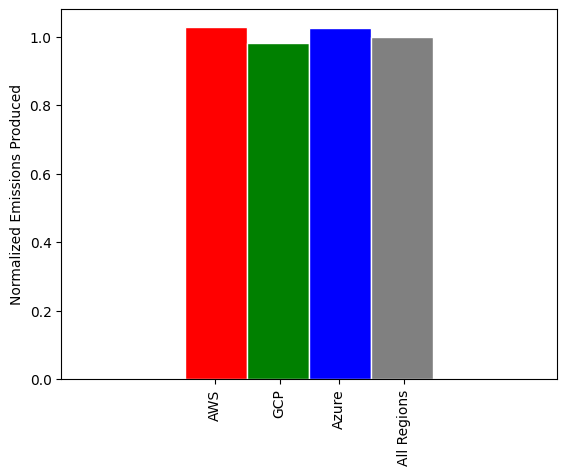

In [79]:
print(basereq.emissions.sum())
print(awsreq.emissions.sum())
print(gcpreq.emissions.sum())
print(azureq.emissions.sum())

ems = pd.DataFrame([[(awsreq.emissions.sum())/basereq.emissions.sum(),(gcpreq.emissions.sum())/basereq.emissions.sum(),(azureq.emissions.sum())/basereq.emissions.sum(), 1]], columns=['AWS', 'GCP', 'Azure', 'All Regions'])
#ems = pd.DataFrame({'va':{0:(awsreq.emissions.sum())/basereq.emissions.sum(), 1:(gcpreq.emissions.sum())/basereq.emissions.sum(), 2:(azureq.emissions.sum())/basereq.emissions.sum(), 3:1}, 'lab':{0:'AWS', 1:'GCP', 2:'Azure', 3:'All Regions'}})
print(ems)

#ems = ems.set_index('lab')
#print(ems)
ax = ems.plot(kind='bar', color=['Red', 'Green', 'Blue','Grey'], edgecolor='white', legend=False)



print(ax.get_xticks())
plt.xticks([-0.19,-0.06,0.06,0.19], ['AWS', 'GCP', 'Azure', 'All Regions'])

#ax.legend(bbox_to_anchor=(1, 1))
ax.set_ylabel("Normalized Emissions Produced")
plt.savefig('./Figures/demo6bar.png', dpi=300)

In [18]:
ems = awsreq[['datetime', 'emissions']]
ems = ems.rename(columns={'emissions' : 'AWS_emissions'})
ems['GCP_emissions'] = gcpreq.emissions
ems['Azure_emissions'] = azureq.emissions
ems

datetime  AWS_emissions  GCP_emissions  Azure_emissions
0    2022-01-01 00:00:00   9.009867e+05   9.300820e+05     9.600228e+05
1    2022-01-01 01:00:00   1.035439e+06   1.059473e+06     1.088925e+06
2    2022-01-01 02:00:00   1.139188e+06   1.139211e+06     1.141516e+06
3    2022-01-01 03:00:00   1.195533e+06   1.060305e+06     1.065268e+06
4    2022-01-01 04:00:00   1.247660e+06   1.279552e+06     1.329370e+06
..                   ...            ...            ...              ...
738  2022-01-31 18:00:00   1.050083e+06   1.077222e+06     1.131952e+06
739  2022-01-31 19:00:00   9.294613e+05   9.601487e+05     1.003191e+06
740  2022-01-31 20:00:00   7.688860e+05   7.733303e+05     7.956139e+05
741  2022-01-31 21:00:00   7.145355e+05   7.177388e+05     7.367504e+05
742  2022-01-31 22:00:00   7.351318e+05   7.362253e+05     7.578887e+05

[743 rows x 4 columns]

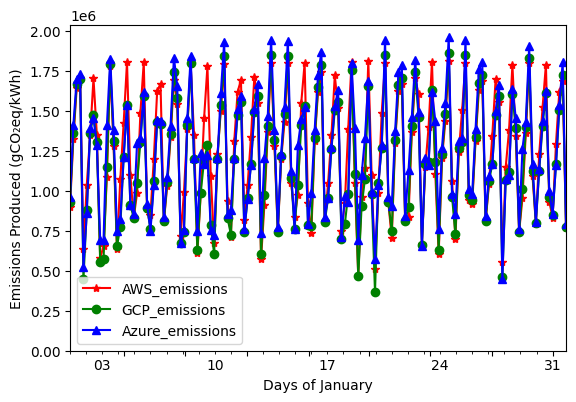

In [20]:
#ems['datetime'] = pd.to_datetime(ems['datetime'])
temp = ems.set_index('datetime')
ax = temp[::5].plot(style=['r*-','go-','b^-'])
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator())
plt.gcf().autofmt_xdate()
#ems.set_index('datetime')[::5].plot(style=['r*-','go-','b^-'])#color=['Red', 'Green', 'Blue'])#kind='bar', 
plt.ylim(bottom=0)
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
ax.set_xlabel("Days of January")
plt.savefig('./Figures/demo6line.png', dpi=300)

In [19]:
awszone = awszon.drop(columns=[0])
awszone

1           2           3           4           5           6    
0            FR  438.518519          ES  438.518519       IT-NO  438.518519  \
1            FR  512.222222  US-NW-BPAT  512.222222          ES  512.222222   
2            FR  566.851852  US-NW-BPAT  566.851852          ES  566.851852   
3            FR  594.259259          ES  594.259259  US-NW-BPAT  594.259259   
4            ES  613.333333  US-NW-BPAT  613.333333          FR  613.333333   
..          ...         ...         ...         ...         ...         ...   
738  US-NW-BPAT  508.518519          ES  508.518519       IT-NO  508.518519   
739          ES  431.296296       IT-NO  431.296296          SG  431.296296   
740          ES  376.481481  US-NW-BPAT  376.481481          SG  376.481481   
741  US-NW-BPAT  348.703704          ES  348.703704       IT-NO  348.703704   
742          ES  347.962963          FR  347.962963       IT-NO  347.962963   

        7           8            9           10           11          12  
0       GB  438.518519           SG  438.518519  US-CAL-CISO  175.407407  
1    IT-NO  512.222222           SG  512.222222  US-CAL-CISO  204.888889  
2    IT-NO  566.851852           SG  566.851852           GB  226.740741  
3    IT-NO  594.259259           SG  594.259259  US-CAL-CISO  237.703704  
4    IT-NO  613.333333           SG  613.333333  US-CAL-CISO  245.333333  
..     ...         ...          ...         ...          ...         ...  
738     SG  508.518519  US-CAL-CISO  508.518519           FR  203.407407  
739     FR  431.296296  US-CAL-CISO  431.296296           GB  172.518519  
740     FR  376.481481        IT-NO  376.481481  US-CAL-CISO  150.592593  
741     FR  348.703704           SG  348.703704  US-CAL-CISO  139.481481  
742     SG  347.962963           GB  347.962963  US-CAL-CISO  139.185185  

[743 rows x 12 columns]

In [20]:
creqs = [['FR', 0], ['ES', 0], ['IT-NO', 0], ['GB', 0], ['SG', 0], ['US-CAL-CISO', 0], ['US-NW-BPAT', 0], ['SE', 0], ['DE', 0], ['US-MIDA-PJM', 0], ['IN-WE', 0], ['BR-CS', 0], ['IE', 0], ['AU-NSW', 0], ['KR', 0], ['JP-TK', 0], ['AU-VIC', 0], ['JP-KN', 0]]
for row in awszone.itertuples(index=False, name=None):
    for i in range(0,len(row)-1,2):
        for y in range(len(creqs)):
            if row[i] == creqs[y][0]:
                creqs[y][1] += row[i+1]
                
print(creqs)

[['FR', 443671.29629629705], ['ES', 463671.8518518525], ['IT-NO', 460879.29629629693], ['GB', 80595.07407407413], ['SG', 336264.14814814867], ['US-CAL-CISO', 315465.03703703725], ['US-NW-BPAT', 330674.5185185192], ['SE', 0], ['DE', 3510.0], ['US-MIDA-PJM', 1532.0370370370372], ['IN-WE', 0], ['BR-CS', 0], ['IE', 16564.55555555556], ['AU-NSW', 2958.5185185185187], ['KR', 0], ['JP-TK', 0], ['AU-VIC', 48041.66666666668], ['JP-KN', 0]]


In [21]:
aws = pd.DataFrame(creqs, columns=['country', 'requests'])
aws= aws[aws['requests'] != 0]
print(aws.requests.sum())
aws

2503828.0000000033


country       requests
0            FR  443671.296296
1            ES  463671.851852
2         IT-NO  460879.296296
3            GB   80595.074074
4            SG  336264.148148
5   US-CAL-CISO  315465.037037
6    US-NW-BPAT  330674.518519
8            DE    3510.000000
9   US-MIDA-PJM    1532.037037
12           IE   16564.555556
13       AU-NSW    2958.518519
16       AU-VIC   48041.666667

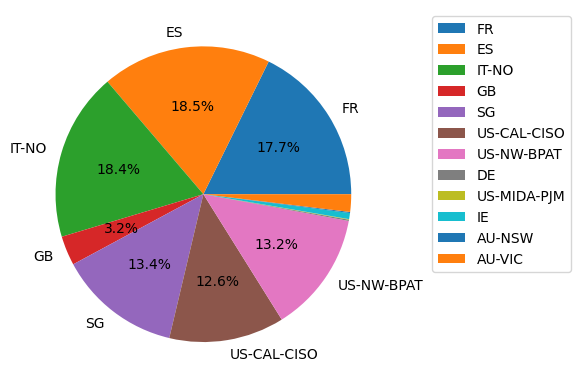

In [22]:
#aws.set_index('country').plot.pie(y='requests', autopct='%1.1f%%', labels=None)
x = aws.set_index('country')
fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(x['requests'], labels=x.index, autopct='%1.1f%%')

threshold = 2
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')
ax.legend(bbox_to_anchor=(1.1, 1))
plt.savefig('./Figures/demo6aws.png', dpi=300, bbox_inches='tight')

In [23]:
gcpzon = pd.read_csv('./output/carbon_min/gen_AI/watttime/zones_used_GCP.csv', header=None)
gcpzone = gcpzon.drop(columns=[0])
creqs = [['FR', 0], ['PL', 0], ['NL', 0], ['ES', 0], ['CA-ON', 0], ['IT-NO', 0], ['GB', 0], ['SG', 0], ['US-CAL-CISO', 0], ['US-NW-BPAT', 0], ['DE', 0], ['US-MIDA-PJM', 0], ['US-MIDW-MISO', 0], ['IN-WE', 0], ['BR-CS', 0], ['IE', 0], ['AU-NSW', 0], ['AU-VIC', 0], ['KR', 0], ['JP-TK', 0], ['JP-KN', 0], ['US-TEX-ERCO', 0]]
for row in gcpzone.itertuples(index=False, name=None):
    for i in range(0,len(row)-1,2):
        for y in range(len(creqs)):
            if row[i] == creqs[y][0]:
                creqs[y][1] += row[i+1]
                
print(creqs)

[['FR', 372917.15151515097], ['PL', 0], ['NL', 62441.57575757581], ['ES', 379367.8787878782], ['CA-ON', 122148.48484848498], ['IT-NO', 375388.7575757571], ['GB', 130323.4242424243], ['SG', 314332.78787878767], ['US-CAL-CISO', 293727.21212121187], ['US-NW-BPAT', 281796.03030303], ['DE', 2871.818181818182], ['US-MIDA-PJM', 1253.4848484848485], ['US-MIDW-MISO', 66086.96969696968], ['IN-WE', 0], ['BR-CS', 0], ['IE', 13433.787878787874], ['AU-NSW', 2420.6060606060605], ['AU-VIC', 39306.8181818182], ['KR', 0], ['JP-TK', 0], ['JP-KN', 0], ['US-TEX-ERCO', 46011.21212121213]]


In [24]:
gcp = pd.DataFrame(creqs, columns=['country', 'requests'])
gcp= gcp[gcp['requests'] != 0]
print(gcp.requests.sum())
gcp

2503827.9999999977


country       requests
0             FR  372917.151515
2             NL   62441.575758
3             ES  379367.878788
4          CA-ON  122148.484848
5          IT-NO  375388.757576
6             GB  130323.424242
7             SG  314332.787879
8    US-CAL-CISO  293727.212121
9     US-NW-BPAT  281796.030303
10            DE    2871.818182
11   US-MIDA-PJM    1253.484848
12  US-MIDW-MISO   66086.969697
15            IE   13433.787879
16        AU-NSW    2420.606061
17        AU-VIC   39306.818182
21   US-TEX-ERCO   46011.212121

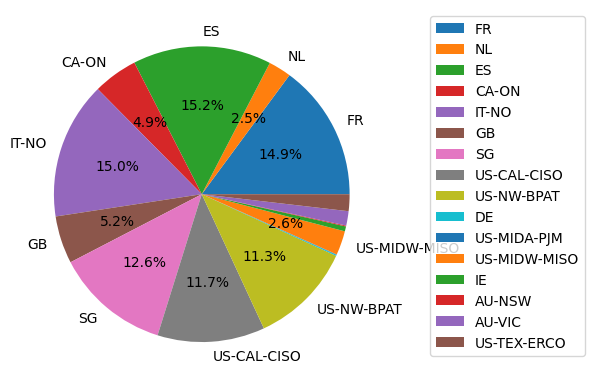

In [25]:
x = gcp.set_index('country')
fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(x['requests'], labels=x.index, autopct='%1.1f%%')

threshold = 2
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')
ax.legend(bbox_to_anchor=(1.1, 1))
plt.savefig('./Figures/demo6gcp.png', dpi=300, bbox_inches='tight')

In [26]:
azuzon = pd.read_csv('./output/carbon_min/gen_AI/watttime/zones_used_Azure.csv', header=None)
azuzone = azuzon.drop(columns=[0])
creqs = [['FR', 0], ['NL', 0], ['CA-ON', 0], ['PL', 0], ['IT-NO', 0], ['GB', 0], ['SE', 0], ['SG', 0], ['US-CAL-CISO', 0], ['US-NW-BPAT', 0], ['DE', 0], ['US-MIDA-PJM', 0], ['US-MIDW-MISO', 0], ['US-TEX-ERCO', 0], ['IN-WE', 0], ['BR-CS', 0], ['IE', 0], ['AU-NSW', 0], ['KR', 0], ['JP-TK', 0]]
for row in azuzone.itertuples(index=False, name=None):
    for i in range(0,len(row)-1,2):
        for y in range(len(creqs)):
            if row[i] == creqs[y][0]:
                creqs[y][1] += row[i+1]
                
print(creqs)
azu = pd.DataFrame(creqs, columns=['country', 'requests'])
azu= azu[azu['requests'] != 0]
print(azu.requests.sum())
azu

[['FR', 438912.6491228076], ['NL', 91910.70175438609], ['CA-ON', 270718.0000000003], ['PL', 0], ['IT-NO', 438808.1228070181], ['GB', 324286.8245614041], ['SE', 0], ['SG', 418543.70175438636], ['US-CAL-CISO', 0], ['US-NW-BPAT', 358774.94736842194], ['DE', 3325.2631578947367], ['US-MIDA-PJM', 1451.4035087719299], ['US-MIDW-MISO', 76521.75438596492], ['US-TEX-ERCO', 57594.52631578947], ['IN-WE', 0], ['BR-CS', 0], ['IE', 19692.035087719294], ['AU-NSW', 3288.0701754385964], ['KR', 0], ['JP-TK', 0]]
2503828.0000000037


country       requests
0             FR  438912.649123
1             NL   91910.701754
2          CA-ON  270718.000000
4          IT-NO  438808.122807
5             GB  324286.824561
7             SG  418543.701754
9     US-NW-BPAT  358774.947368
10            DE    3325.263158
11   US-MIDA-PJM    1451.403509
12  US-MIDW-MISO   76521.754386
13   US-TEX-ERCO   57594.526316
16            IE   19692.035088
17        AU-NSW    3288.070175

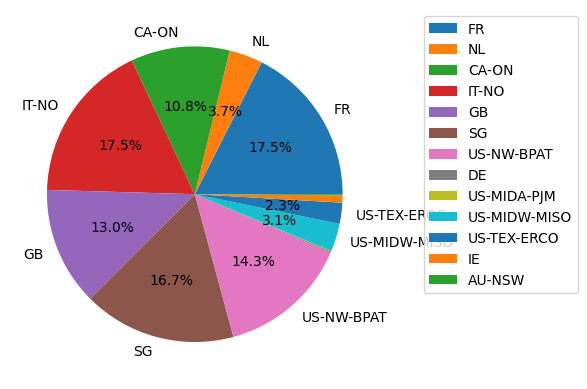

In [27]:
x = azu.set_index('country')
fig, ax = plt.subplots()

wedges, texts, autotexts = ax.pie(x['requests'], labels=x.index, autopct='%1.1f%%')

threshold = 2
for label, pct_label in zip(texts, autotexts):
    pct_value = pct_label.get_text().rstrip('%')
    if float(pct_value) < threshold:
        label.set_text('')
        pct_label.set_text('')
ax.legend(bbox_to_anchor=(1.1, 1))
plt.savefig('./Figures/demo6azu.png', dpi=300, bbox_inches='tight')

In [48]:
origin = datetime.strptime("2022-06-01 00:00:00", '%Y-%m-%d %H:%M:%S')
end_date = datetime.strptime("2022-6-30 23:00:00", '%Y-%m-%d %H:%M:%S')

ai_workload= genAI.workloadOverADay(requestsADay=80825, total_hours=720, start_date=origin)
temp_workload = temporalWorkload.t_workload(jobs = 80825, start_dt = origin, end_dt = end_date, loc="FR", min_duration=60, max_duration=120, measurement_interval = 60)
temp_workload

start_timestamp        duration  num_of_requests location
0   2022-06-01 09:00:00 0 days 01:00:00              468       FR
1   2022-06-01 10:00:00 0 days 01:00:00              453       FR
2   2022-06-01 11:00:00 0 days 01:00:00              468       FR
3   2022-06-01 12:00:00 0 days 01:00:00              455       FR
4   2022-06-01 13:00:00 0 days 01:00:00              475       FR
..                  ...             ...              ...      ...
171 2022-06-30 12:00:00 0 days 01:00:00              455       FR
172 2022-06-30 13:00:00 0 days 01:00:00              443       FR
173 2022-06-30 14:00:00 0 days 01:00:00              463       FR
174 2022-06-30 15:00:00 0 days 01:00:00              467       FR
175 2022-06-30 16:00:00 0 days 01:00:00              455       FR

[176 rows x 4 columns]

In [49]:
print(temp_workload.num_of_requests.sum())
print(ai_workload.num_of_requests.sum())

80825
2425110


In [28]:
ai = pd.read_csv('./output/carbon_min/gen_AI/marginal/requests_demo5.csv')
tem = pd.read_csv('./output/carbon_min/temporal/marginal/requests_demo5.csv')
tem

datetime  requests     emissions
0    2022-06-01 00:00:00     13889  2.721070e+06
1    2022-06-01 01:00:00     13744  2.631131e+06
2    2022-06-01 02:00:00     13793  2.599770e+06
3    2022-06-01 03:00:00     13900  2.576467e+06
4    2022-06-01 04:00:00     13805  2.504587e+06
..                   ...       ...           ...
699  2022-06-30 03:00:00     13657  2.559023e+06
700  2022-06-30 04:00:00     13920  2.550059e+06
701  2022-06-30 05:00:00     13749  2.434577e+06
702  2022-06-30 06:00:00     13804  2.404679e+06
703  2022-06-30 07:00:00     13852  2.354840e+06

[704 rows x 3 columns]

In [29]:
print(tem.requests.sum())
print(ai.requests.sum())
print(tem.emissions.sum())
print(ai.emissions.sum())

2424750
2425110
448871576.0540869
431714433.13000584


In [36]:
ems = tem[['datetime', 'emissions']]
ems = ems.rename(columns={'emissions' : 'temporal_workload'})
ems['generativeAI_workload'] = ai.emissions
ems['datetime'] = pd.to_datetime(ems['datetime'])
ems

datetime  temporal_workload  generativeAI_workload
0   2022-06-01 00:00:00       2.721070e+06          463927.737499
1   2022-06-01 01:00:00       2.631131e+06          529518.927269
2   2022-06-01 02:00:00       2.599770e+06          576951.845631
3   2022-06-01 03:00:00       2.576467e+06          594811.549285
4   2022-06-01 04:00:00       2.504587e+06          600883.051132
..                  ...                ...                    ...
699 2022-06-30 03:00:00       2.559023e+06          601296.253861
700 2022-06-30 04:00:00       2.550059e+06          606738.038467
701 2022-06-30 05:00:00       2.434577e+06          617807.773848
702 2022-06-30 06:00:00       2.404679e+06          621028.599114
703 2022-06-30 07:00:00       2.354840e+06          621009.826055

[704 rows x 3 columns]

[459456 460159]


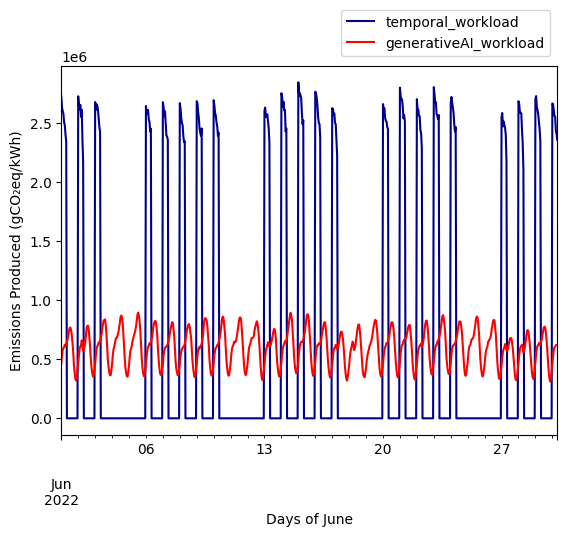

In [38]:
ax = ems.set_index('datetime').plot(color=['darkblue', 'red'])
xticks = ax.get_xticks()
print(xticks)
#labels = ['01-01', '01-05', '01-09', '01-13', '01-17', '01-21', '01-25', '01-29', '02-02', '02-06']
#ax.set_xticks(xticks+100)
#ax.set_xticklabels(labels)
ax.set_xlabel("Days of June")
ax.set_ylabel("Emissions Produced (gCO₂eq/kWh)")
#plt.margins(0)
ax.legend(bbox_to_anchor=(1, 1.17))
plt.savefig('./Figures/demo5.png', dpi=300, bbox_inches='tight')